In [3]:
# -*- coding: utf-8 -*-
"""
EHB 500 m buffer → POI extraction
- EHB：直接使用 lon_wgs84 / lat_wgs84
- POI：优先 wgs84_x/y 或 lon_wgs84/lat_wgs84；否则回退到 gcj02_x/y、lon_gcj/lat_gcj、bd09 等
"""

import os, glob, math, re
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# ---------- Paths ----------
POI_DIR = "/Users/sillyfish/Desktop/dissertation/上海_202407/csv"
EHB_XLSX = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
SHANGHAI_SHP = "/Users/sillyfish/Desktop/dissertation/DATA/data_shanghai_district/shanghai_district.shp"  # optional
OUTPUT_DIR = "/Users/sillyfish/Desktop/dissertation/OUTPUTS"
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUT_CSV   = os.path.join(OUTPUT_DIR, "ehb_poi_within_500m.csv")
OUT_GPKG  = os.path.join(OUTPUT_DIR, "ehb_poi_within_500m.gpkg")
OUT_LAYER = "ehb_poi_500m"
OUT_COUNT = os.path.join(OUTPUT_DIR, "ehb_poi_count_500m.csv")
RADIUS_M  = 500  # buffer radius in meters

# ---------- GCJ/BD09 converters (only when needed) ----------
x_pi = math.pi * 3000.0 / 180.0
pi = math.pi
a = 6378245.0
ee = 0.00669342162296594323

def _out_of_china(lon, lat):
    return not (72.004 <= lon <= 137.8347 and 0.8293 <= lat <= 55.8271)
def _transformlat(lon, lat):
    ret = -100 + 2*lon + 3*lat + 0.2*lat*lat + 0.1*lon*lat + 0.2*math.sqrt(abs(lon))
    ret += (20*math.sin(6*lon*pi) + 20*math.sin(2*lon*pi))*2/3
    ret += (20*math.sin(lat*pi) + 40*math.sin(lat/3*pi))*2/3
    ret += (160*math.sin(lat/12*pi) + 320*math.sin(lat/30*pi))*2/3
    return ret
def _transformlon(lon, lat):
    ret = 300 + lon + 2*lat + 0.1*lon*lon + 0.1*lon*lat + 0.1*math.sqrt(abs(lon))
    ret += (20*math.sin(6*lon*pi) + 20*math.sin(2*lon*pi))*2/3
    ret += (20*math.sin(lon*pi) + 40*math.sin(lon/3*pi))*2/3
    ret += (150*math.sin(lon/12*pi) + 300*math.sin(lon/30*pi))*2/3
    return ret
def gcj02_to_wgs84(lon, lat):
    if _out_of_china(lon, lat): return lon, lat
    dlat = _transformlat(lon - 105.0, lat - 35.0)
    dlon = _transformlon(lon - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = 1 - ee * (math.sin(radlat) ** 2)
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlon = (dlon * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mgLat = lat + dlat; mgLon = lon + dlon
    return lon - (mgLon - lon), lat - (mgLat - lat)
def bd09_to_gcj02(lon, lat):
    x = lon - 0.0065; y = lat - 0.006
    z = math.sqrt(x*x + y*y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * x_pi)
    return z * math.cos(theta), z * math.sin(theta)
def bd09_to_wgs84(lon, lat):
    lon_gcj, lat_gcj = bd09_to_gcj02(lon, lat)
    return gcj02_to_wgs84(lon_gcj, lat_gcj)

# ---------- Utils ----------
def _to_num(s): return pd.to_numeric(s, errors="coerce")
def _split_lonlat_text(val):
    if pd.isna(val): return None, None
    if isinstance(val, (int, float)): return None, None
    m = re.search(r'(-?\d+\.?\d*)\s*,\s*(-?\d+\.?\d*)', str(val))
    return (float(m.group(1)), float(m.group(2))) if m else (None, None)

def ensure_wgs84_for_poi(df, file_tag=""):
    """
    Detect POI coordinates and produce lon_wgs84/lat_wgs84.
    Newly added: wgs84_x / wgs84_y, gcj02_x / gcj02_y.
    """
    cols = {c.lower(): c for c in df.columns}
    def pick(*cands):
        for c in cands:
            if c in cols: return cols[c]
        return None

    # 1) WGS84 direct (covering wgs84_x/y)
    lon_w = pick("wgs84_x","lon_wgs84","wgs84_lon","wgs84_lng","longitude","lon","lng","x","经度")
    lat_w = pick("wgs84_y","lat_wgs84","wgs84_lat","latitude","lat","y","纬度")
    if lon_w and lat_w:
        df["lon_wgs84"] = _to_num(df[lon_w]); df["lat_wgs84"] = _to_num(df[lat_w])
        print(f"[INFO] {file_tag}: WGS84 -> ({lon_w},{lat_w})")
        return df

    # 2) GCJ02 numeric (including gcj02_x/y)
    lon_g = pick("gcj02_x","lon_gcj","gcj_lon","gcj_lng")
    lat_g = pick("gcj02_y","lat_gcj","gcj_lat")
    if lon_g and lat_g:
        lon = _to_num(df[lon_g]); lat = _to_num(df[lat_g])
        conv = lon.combine(lat, lambda x,y: gcj02_to_wgs84(x,y) if pd.notna(x) and pd.notna(y) else (None,None))
        df["lon_wgs84"] = [c[0] for c in conv]; df["lat_wgs84"] = [c[1] for c in conv]
        print(f"[INFO] {file_tag}: GCJ02 -> WGS84 ({lon_g},{lat_g})")
        return df

    # 3) BD09 numeric
    lon_b = pick("lon_bd09","bd09_lon","bd_lon","bd09_lng","bd_lng")
    lat_b = pick("lat_bd09","bd09_lat","bd_lat")
    if lon_b and lat_b:
        lon = _to_num(df[lon_b]); lat = _to_num(df[lat_b])
        conv = lon.combine(lat, lambda x,y: bd09_to_wgs84(x,y) if pd.notna(x) and pd.notna(y) else (None,None))
        df["lon_wgs84"] = [c[0] for c in conv]; df["lat_wgs84"] = [c[1] for c in conv]
        print(f"[INFO] {file_tag}: BD09 -> WGS84 ({lon_b},{lat_b})")
        return df

    # 4) 'location' text (GCJ02)
    loc_col = pick("location","坐标","coord","coords")
    if loc_col:
        lon_list, lat_list = [], []
        for v in df[loc_col]:
            lon, lat = _split_lonlat_text(v)
            if lon is not None:
                wlon, wlat = gcj02_to_wgs84(lon, lat)
            else:
                wlon, wlat = None, None
            lon_list.append(wlon); lat_list.append(wlat)
        df["lon_wgs84"] = lon_list; df["lat_wgs84"] = lat_list
        print(f"[INFO] {file_tag}: parsed GCJ02 from '{loc_col}' -> WGS84")
        return df

    # 5) fallback: x/y 当作 WGS84
    xcol = pick("x"); ycol = pick("y")
    if xcol and ycol:
        df["lon_wgs84"] = _to_num(df[xcol]); df["lat_wgs84"] = _to_num(df[ycol])
        print(f"[INFO] {file_tag}: fallback WGS84 ({xcol},{ycol})")
        return df

    raise ValueError("No recognizable coordinate columns.")

# ---------- Read EHB (already WGS84) ----------
ehb = pd.read_excel(EHB_XLSX).dropna(subset=["lon_wgs84","lat_wgs84"]).copy()
if "ehb_id" not in ehb.columns:
    ehb["ehb_id"] = range(1, len(ehb)+1)

gdf_ehb = gpd.GeoDataFrame(
    ehb,
    geometry=gpd.points_from_xy(ehb["lon_wgs84"], ehb["lat_wgs84"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)
gdf_ehb["buffer_500m"] = gdf_ehb.geometry.buffer(RADIUS_M)

# ---------- Read & merge POIs ----------
poi_files = sorted(glob.glob(os.path.join(POI_DIR, "*.csv")))
frames = []
for path in poi_files:
    try:
        df = pd.read_csv(path, encoding="utf-8", low_memory=False)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="gb18030", low_memory=False)
    try:
        df = ensure_wgs84_for_poi(df, file_tag=os.path.basename(path))
    except ValueError:
        print(f"[WARN] Skip (no coords): {os.path.basename(path)}")
        continue

    base = os.path.splitext(os.path.basename(path))[0]
    category = base.split("_")[-1] if "_" in base else base
    df["poi_category"] = category
    frames.append(df)

if not frames:
    raise RuntimeError("No POI with usable coordinates found.")

poi_all = pd.concat(frames, ignore_index=True).dropna(subset=["lon_wgs84","lat_wgs84"])
gdf_poi = gpd.GeoDataFrame(
    poi_all,
    geometry=gpd.points_from_xy(poi_all["lon_wgs84"], poi_all["lat_wgs84"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# ---------- (Optional) clip to Shanghai ----------
if os.path.exists(SHANGHAI_SHP):
    sh = gpd.read_file(SHANGHAI_SHP).to_crs(epsg=3857)
    # 如需严格裁剪到市界，取消下一行注释：
    # gdf_poi = gpd.overlay(gdf_poi, sh[["geometry"]], how="intersection")

# ---------- Spatial join: POI within 500 m buffers ----------
ehb_buf = gdf_ehb[["ehb_id","name","address","buffer_500m"]].rename(columns={"buffer_500m":"geometry"})
ehb_buf = ehb_buf.set_geometry("geometry"); ehb_buf.crs = gdf_ehb.crs
joined = gpd.sjoin(gdf_poi, ehb_buf, predicate="within", how="inner")

# ---------- Outputs ----------
joined_wgs = joined.to_crs(epsg=4326).copy()
joined_wgs["poi_lon"] = joined_wgs.geometry.x
joined_wgs["poi_lat"] = joined_wgs.geometry.y

cols = ["ehb_id","name_right","address_right","poi_category","name","address","poi_lon","poi_lat"]
cols = [c for c in cols if c in joined_wgs.columns]
out_df = joined_wgs[cols].rename(columns={
    "name_right":"ehb_name","address_right":"ehb_address",
    "name":"poi_name","address":"poi_address"
})
out_df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
joined_wgs.to_file(OUT_GPKG, layer=OUT_LAYER, driver="GPKG")

counts = out_df.groupby(["ehb_id","ehb_name"], as_index=False).size().rename(columns={"size":"poi_count_500m"})
counts.to_csv(OUT_COUNT, index=False, encoding="utf-8-sig")

print("[OK] CSV:", OUT_CSV)
print("[OK] GPKG:", OUT_GPKG, f"(layer={OUT_LAYER})")
print("[OK] Counts:", OUT_COUNT)


[INFO] 上海_202407_事件活动.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_交通设施服务.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_住宿服务.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_体育休闲服务.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_公共设施.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_公司企业.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_医疗保健服务.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_商务住宅.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_地名地址信息.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_室内设施.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_摩托车服务.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_政府机构及社会团体.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_汽车服务.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_汽车维修.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_汽车销售.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_生活服务.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_科教文化服务.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_202407_虚拟数据.csv: WGS84 -> (wgs84_x,wgs84_y)
[INFO] 上海_20

In [7]:
import requests
requests.utils.get_environ_proxies("https://restapi.amap.com")


{'http': 'http://127.0.0.1:33210',
 'https': 'http://127.0.0.1:33210',
 'socks': 'http://127.0.0.1:33211'}

In [37]:
# -*- coding: utf-8 -*-
import os, re, time, random, glob, json, math
from urllib.parse import quote, urlparse, urljoin
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
from requests.adapters import HTTPAdapter, Retry
from bs4 import BeautifulSoup
from tqdm import tqdm

# ======== CONFIG ========
AMAP_KEY   = "e3eee5d28604ad213691ef223c1826b9"
EHB_XLSX   = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
POI_DIR    = "/Users/sillyfish/Desktop/dissertation/上海_202407/csv"
OUT_DIR    = "/Users/sillyfish/Desktop/dissertation/OUTPUTS"
CITY_PINYIN = "shanghai"   # PC 端用全拼
CITY_MOBILE = "sh"         # 移动端用短码（关键修正点）
RADIUS_M    = 1000
MAX_AMAP_POIS_PER_EHB = 5
SLEEP_MIN, SLEEP_MAX   = 0.8, 1.6     # 稍微增加，降低风控概率
CONNECT_TIMEOUT, READ_TIMEOUT = 6, 12
SUBSET_N = 30  # 全量=0；调试可改小

os.makedirs(OUT_DIR, exist_ok=True)
OUT_COMM_RAW   = os.path.join(OUT_DIR, "anjuke_communities_raw.csv")
OUT_LINKED_CSV = os.path.join(OUT_DIR, f"ehb_anjuke_price_{RADIUS_M}m.csv")
OUT_STATS_CSV  = os.path.join(OUT_DIR, f"ehb_anjuke_price_{RADIUS_M}m_stats.csv")
AJK_CACHE_PATH = os.path.join(OUT_DIR, "ajk_cache.json")

# ======== NO PROXY + RETRIES ========
for k in ["HTTP_PROXY","HTTPS_PROXY","http_proxy","https_proxy","ALL_PROXY","all_proxy","NO_PROXY","no_proxy","socks_proxy","SOCKS_PROXY"]:
    os.environ.pop(k, None)

def build_session():
    s = requests.Session(); s.trust_env = False
    retries = Retry(total=4, connect=4, read=4, backoff_factor=0.7,
                    status_forcelist=[429,500,502,503,504], allowed_methods=["GET"], raise_on_status=False)
    adapter = HTTPAdapter(max_retries=retries, pool_connections=64, pool_maxsize=64)
    s.mount("https://", adapter); s.mount("http://", adapter)
    return s
SESSION = build_session()

UA_PC = [
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0 Safari/537.36",
]
UA_MOBILE = [
    "Mozilla/5.0 (iPhone; CPU iPhone OS 16_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.0 Mobile/15A372 Safari/604.1",
    "Mozilla/5.0 (Linux; Android 13; Pixel 7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0 Mobile Safari/537.36",
]

def H(mobile=False, referer=None):
    hdr = {
        "User-Agent": random.choice(UA_MOBILE if mobile else UA_PC),
        "Accept-Language":"zh-CN,zh;q=0.9",
    }
    if referer:
        hdr["Referer"] = referer
    return hdr

# ======== GCJ -> WGS84 ========
a=6378245.0; ee=0.00669342162296594323; pi=math.pi
def _out_of_china(lon, lat): return not (72.004<=lon<=137.8347 and 0.8293<=lat<=55.8271)
def _tl(lon, lat):
    r=-100+2*lon+3*lat+0.2*lat*lat+0.1*lon*lat+0.2*math.sqrt(abs(lon))
    r+=(20*math.sin(6*lon*pi)+20*math.sin(2*lon*pi))*2/3
    r+=(20*math.sin(lat*pi)+40*math.sin(lat/3*pi))*2/3
    r+=(160*math.sin(lat/12*pi)+320*math.sin(lat/30*pi))*2/3
    return r
def _tn(lon, lat):
    r=300+lon+2*lat+0.1*lon*lon+0.1*lon*lat+0.1*math.sqrt(abs(lon))
    r+=(20*math.sin(6*lon*pi)+20*math.sin(2*lon*pi))*2/3
    r+=(20*math.sin(lon*pi)+40*math.sin(lon/3*pi))*2/3
    r+=(150*math.sin(lon/12*pi)+300*math.sin(lon/30*pi))*2/3
    return r
def gcj02_to_wgs84(lon, lat):
    if _out_of_china(lon, lat): return lon, lat
    dlat=_tl(lon-105.0, lat-35.0); dlon=_tn(lon-105.0, lat-35.0)
    radlat=lat/180.0*pi; magic=1-ee*(math.sin(radlat)**2); sqrtm=math.sqrt(magic)
    dlat=(dlat*180.0)/((a*(1-ee))/(magic*sqrtm)*pi); dlon=(dlon*180.0)/(a/sqrtm*math.cos(radlat)*pi)
    mgLat=lat+dlat; mgLon=lon+dlon
    return lon-(mgLon-lon), lat-(mgLat-lat)

# ======== AMAP ========
def amap_around(lon, lat, radius=500, page=1):
    url="https://restapi.amap.com/v3/place/around"
    p={"key":AMAP_KEY,"location":f"{lon},{lat}","radius":radius,"types":"120300|120302",
       "offset":25,"page":page,"city":"上海","extensions":"base","output":"json"}
    r=SESSION.get(url,params=p,headers=H(),timeout=(CONNECT_TIMEOUT,READ_TIMEOUT),proxies={}); r.raise_for_status()
    return r.json()

# 放宽文本检索 types=None（避免过窄）
def amap_place_text(keyword, city="上海", types=None):
    url="https://restapi.amap.com/v3/place/text"
    p={"key":AMAP_KEY,"keywords":keyword,"city":city,"children":0,"page":1,"offset":1}
    if types: p["types"]=types
    r=SESSION.get(url,params=p,headers=H(),timeout=(CONNECT_TIMEOUT,READ_TIMEOUT),proxies={}); r.raise_for_status()
    js=r.json()
    if js.get("status")!="1": return None
    pois=js.get("pois") or []
    if not pois: return None
    loc=pois[0].get("location")
    if not loc or "," not in loc: return None
    glon,glat=[float(x) for x in loc.split(",")[:2]]
    return gcj02_to_wgs84(glon,glat)

def amap_preflight():
    try:
        js=amap_around(121.5,31.2,100,1); ok=js.get("status")=="1"
        print("[OK] AMAP preflight passed." if ok else "[INFO] AMAP preflight failed.")
        return ok
    except Exception:
        print("[INFO] AMAP preflight failed (exception)."); return False

def get_nearby_by_amap(lon,lat,radius=RADIUS_M):
    items=[]; page=1
    while len(items)<MAX_AMAP_POIS_PER_EHB:
        js=amap_around(lon,lat,radius,page)
        if js.get("status")!="1": break
        pois=js.get("pois") or []
        if not pois: break
        for p in pois:
            nm=p.get("name"); ad=p.get("adname")
            if not nm: continue
            items.append({"cand_name":nm,"district":ad})
            if len(items)>=MAX_AMAP_POIS_PER_EHB: break
        page+=1; time.sleep(random.uniform(SLEEP_MIN,SLEEP_MAX))
    return items

# ======== Local POI fallback ========
def load_local_residential_poi(poi_dir):
    frames=[]
    for path in sorted(glob.glob(os.path.join(poi_dir,"*.csv"))):
        try: df=pd.read_csv(path,encoding="utf-8",low_memory=False)
        except UnicodeDecodeError: df=pd.read_csv(path,encoding="gb18030",low_memory=False)
        frames.append(df)
    if not frames: return gpd.GeoDataFrame()
    poi=pd.concat(frames,ignore_index=True)
    def pick(*cands):
        cols={c.lower():c for c in poi.columns}
        for c in cands:
            if c in cols: return cols[c]
        return None
    lon=pick("wgs84_x","lon_wgs84","longitude","lon","lng","x","经度")
    lat=pick("wgs84_y","lat_wgs84","latitude","lat","y","纬度")
    name=pick("name","poi_name")
    if not (lon and lat and name): return gpd.GeoDataFrame()
    poi["_lon"]=pd.to_numeric(poi[lon],errors="coerce"); poi["_lat"]=pd.to_numeric(poi[lat],errors="coerce")
    poi=poi.dropna(subset=["_lon","_lat"]).copy()
    kws=["住宅区","住宅小区","小区","花苑","家园","公寓","社区","名苑","花园"]
    mask=poi[name].astype(str).apply(lambda s:any(k in s for k in kws))
    res=poi[mask].copy().rename(columns={name:"cand_name"})
    return gpd.GeoDataFrame(res,geometry=gpd.points_from_xy(res["_lon"],res["_lat"]),crs=4326).to_crs(3857)[["cand_name","geometry"]]

def get_nearby_by_localpoi(gdf_local, ehb_buf):
    inside=gpd.sjoin(gdf_local, gpd.GeoDataFrame(geometry=[ehb_buf],crs=3857), predicate="within", how="inner")
    names=inside["cand_name"].dropna().astype(str).unique().tolist()
    return [{"cand_name":n} for n in names[:MAX_AMAP_POIS_PER_EHB]]

# ======== Anjuke ========

def _norm_url(href, base):
    if not href: return None
    if href.startswith("//"): href = "https:" + href
    if href.startswith("/"): href = urljoin(base, href)
    return href

def _is_ajk_comm_detail(href, city_pinyin, city_mobile):
    """接受 PC: {pinyin}.anjuke.com；移动: m.anjuke.com/{mobile}/... 的详情页"""
    try:
        u = urlparse(href)
    except:
        return False
    host = u.netloc
    path = (u.path or "") + (("?" + u.query) if u.query else "")
    host_ok = (host == f"{city_pinyin}.anjuke.com") or (host == "m.anjuke.com" and f"/{city_mobile}/" in (u.path or "/"))
    if not host_ok:
        return False
    # 详情页路径特征
    if "/community/view/" in path:
        return True
    if u.path.startswith("/community/") and not u.path.rstrip("/").endswith("/community"):
        return True
    return False

def ajk_search_url(city_pinyin, kw, district=None):
    """优先 PC；失败走移动端（移动端必须用移动 UA + 城市短码）"""
    q = kw if (not district or (district and district in kw)) else f"{kw} {district}"

    # 1) PC 搜索页
    base_pc = f"https://{city_pinyin}.anjuke.com"
    url_pc  = f"{base_pc}/community/?kw={quote(str(q))}"
    r = SESSION.get(url_pc, headers=H(mobile=False), timeout=(CONNECT_TIMEOUT,READ_TIMEOUT), proxies={})
    if r.status_code == 200:
        soup = BeautifulSoup(r.text, "lxml")
        for a in soup.find_all("a", href=True):
            href = _norm_url(a["href"], base_pc)
            if _is_ajk_comm_detail(href, city_pinyin, CITY_MOBILE):
                return href

    # 2) 移动端兜底（关键修正：用城市短码 + 移动 UA）
    base_m = f"https://m.anjuke.com/{CITY_MOBILE}"
    url_m  = f"{base_m}/community/?q={quote(str(q))}"
    r = SESSION.get(url_m, headers=H(mobile=True, referer=base_pc), timeout=(CONNECT_TIMEOUT,READ_TIMEOUT), proxies={})
    if r.status_code == 200:
        soup = BeautifulSoup(r.text, "lxml")
        for a in soup.find_all("a", href=True):
            href = _norm_url(a["href"], base_m)
            if _is_ajk_comm_detail(href, city_pinyin, CITY_MOBILE):
                return href

    return None

def ajk_parse_detail(url, name_hint=None, district=None):
    """增强解析：识别风控；兼容 PC/移动端；多路提取价格与坐标"""
    mobile = ("m.anjuke.com" in url)
    r = SESSION.get(url, headers=H(mobile=mobile), timeout=(CONNECT_TIMEOUT,READ_TIMEOUT), proxies={})
    if r.status_code != 200:
        return None

    final = r.url  # 避免 302 到其它页面
    if not _is_ajk_comm_detail(final, CITY_PINYIN, CITY_MOBILE):
        return {"community_name": name_hint, "community_address": None,
                "lon": None, "lat": None, "price_psm": None, "detail_url": final, "miss_reason": "city_mismatch_or_not_detail"}

    html = r.text
    if ("安全验证" in html) or ("访问验证" in html) or ("verify" in html.lower()) or ("机器人" in html):
        return {"community_name": name_hint, "community_address": None,
                "lon": None, "lat": None, "price_psm": None, "detail_url": final, "miss_reason": "captcha_or_block"}

    soup = BeautifulSoup(html, "lxml")

    # 名称
    name = None
    for sel in [".community-title h1","h1.title","div.title h1",".page-title h1",".xq-title h1"]:
        el = soup.select_one(sel)
        if el:
            name = el.get_text(strip=True); break
    if not name:
        t = soup.find("title")
        if t: name = t.get_text(strip=True)
    if not name: name = name_hint

    # 地址
    address = None
    for sel in [".community-title p",".sub-title","p.address","div.address",".address .text"]:
        el = soup.select_one(sel)
        if el:
            address = el.get_text(strip=True); break

    # 价格：多路解析
    price = None
    for sel in [".comm-price .num", ".price .num", ".average .num", ".xq-price .num", ".price strong"]:
        el = soup.select_one(sel)
        if el:
            m = re.search(r"(\d{4,6})", el.get_text(strip=True))
            if m:
                price = float(m.group(1)); break
    if price is None:
        for sc in soup.find_all("script"):
            m = re.search(r'"price"\s*:\s*"?(\\d{4,6})"?', sc.get_text(" ", strip=True))
            if m:
                try: price = float(m.group(1)); break
                except: pass
    if price is None:
        for pat in [r"均价[：:]\s*(\d{4,6})\s*元/㎡",
                    r"参考均价[：:]\s*(\d{4,6})\s*元/㎡",
                    r"(\d{4,6})\s*元/㎡",
                    r"(\d{4,6})\s*元/平米"]:
            m = re.search(pat, html)
            if m:
                try: price = float(m.group(1)); break
                except: pass

    # 坐标
    lon = lat = None
    meta = soup.select_one('meta[name="location"]')
    if meta and meta.has_attr("content"):
        m = re.search(r"coord\s*=\s*([-\d\.]+)\s*,\s*([-\d\.]+)", meta["content"])
        if m: lon, lat = float(m.group(1)), float(m.group(2))
    if (lon is None or lat is None):
        m2 = re.search(r'"(?:lon|lng|longitude)"\s*:\s*([-\d\.]+)\s*,\s*"(?:lat|latitude)"\s*:\s*([-\d\.]+)', html)
        if m2: lon, lat = float(m2.group(1)), float(m2.group(2))

    return {"community_name": name, "community_address": address,
            "lon": lon, "lat": lat, "price_psm": price, "detail_url": final}

# ======== Cache ========
def load_cache(p):
    if os.path.exists(p):
        try: return json.load(open(p,"r",encoding="utf-8"))
        except: return {}
    return {}
def save_cache(p, cache): json.dump(cache, open(p,"w",encoding="utf-8"), ensure_ascii=False)

# ======== 安静聚合，避免 nanmean 警告 ========
def _nanmean(x):
    v = pd.to_numeric(x, errors="coerce")
    return np.nan if v.notna().sum()==0 else float(np.nanmean(v))
def _nanmedian(x):
    v = pd.to_numeric(x, errors="coerce")
    return np.nan if v.notna().sum()==0 else float(np.nanmedian(v))

# ======== MAIN ========
def main():
    ehb=pd.read_excel(EHB_XLSX).dropna(subset=["lon_wgs84","lat_wgs84"]).copy()
    if "ehb_id" not in ehb.columns: ehb["ehb_id"]=range(1,len(ehb)+1)
    gdf_ehb=gpd.GeoDataFrame(ehb, geometry=gpd.points_from_xy(ehb["lon_wgs84"],ehb["lat_wgs84"]), crs=4326).to_crs(3857)
    gdf_ehb["buffer"]=gdf_ehb.geometry.buffer(RADIUS_M)
    if SUBSET_N>0:
        gdf_ehb=gdf_ehb.head(SUBSET_N).copy()
        print(f"[INFO] SUBSET_N={SUBSET_N} -> 仅跑 {len(gdf_ehb)} 个 EHB 做烟测。")

    use_amap=amap_preflight()
    local_poi_gdf=None
    if not use_amap:
        local_poi_gdf=load_local_residential_poi(POI_DIR)

    cache=load_cache(AJK_CACHE_PATH)
    rows=[]
    for _, r in tqdm(gdf_ehb.iterrows(), total=len(gdf_ehb), desc="EHB"):
        ehb_id=int(r["ehb_id"])
        elon=float(ehb.loc[ehb["ehb_id"]==ehb_id,"lon_wgs84"].values[0])
        elat=float(ehb.loc[ehb["ehb_id"]==ehb_id,"lat_wgs84"].values[0])
        buf=r["buffer"]

        # candidates
        cands=[]
        if use_amap:
            try: cands=get_nearby_by_amap(elon,elat,RADIUS_M)
            except: cands=[]
        if (not cands) and (local_poi_gdf is not None) and (not local_poi_gdf.empty):
            cands=get_nearby_by_localpoi(local_poi_gdf, buf)
        if not cands: continue

        for c in cands:
            key=c["cand_name"]; district=c.get("district")
            rec=None

            # 忽略缓存 miss，允许重新尝试
            cache_hit = cache.get(key)
            if cache_hit and ("miss" in cache_hit) and cache_hit["miss"] is True:
                cache_hit = None
            if cache_hit:
                rec = cache_hit
            else:
                url=ajk_search_url(CITY_PINYIN, key, district=district)
                time.sleep(random.uniform(SLEEP_MIN,SLEEP_MAX))
                if url:
                    d=ajk_parse_detail(url, name_hint=key, district=district)
                    time.sleep(random.uniform(SLEEP_MIN,SLEEP_MAX))
                    if d: rec=d

                # 坐标兜底：高德文本检索（types=None）
                if (rec is None) or (rec.get("lon") is None or rec.get("lat") is None):
                    try:
                        w = amap_place_text(f"{key} {district or ''}".strip(), city="上海", types=None)
                    except:
                        w = None
                    if w:
                        if rec is None: rec={"community_name":key, "community_address":None, "price_psm":None, "detail_url":None}
                        rec["lon"], rec["lat"] = w

                if rec is None:
                    cache[key]={"miss":True,"why":"no_search_hit"}; continue
                if rec.get("price_psm") is None and "miss_reason" not in rec:
                    rec["miss_reason"]="no_price_in_page"

                cache[key]=rec
                if random.random()<0.05: save_cache(AJK_CACHE_PATH, cache)

            rows.append({
                "ehb_id": ehb_id,
                "ehb_name": ehb.loc[ehb["ehb_id"]==ehb_id,"name"].values[0] if "name" in ehb.columns else None,
                "ehb_address": ehb.loc[ehb["ehb_id"]==ehb_id,"address"].values[0] if "address" in ehb.columns else None,
                "ajk_name": rec.get("community_name"),
                "ajk_address": rec.get("community_address"),
                "ajk_lon": rec.get("lon"),
                "ajk_lat": rec.get("lat"),
                "ajk_price_psm": rec.get("price_psm"),
                "ajk_detail_url": rec.get("detail_url"),
                "miss_reason": rec.get("miss_reason")
            })

    # 原始结果
    df_raw=pd.DataFrame(rows)
    df_raw.to_csv(OUT_COMM_RAW, index=False, encoding="utf-8-sig")
    print("[OK] raw saved:", OUT_COMM_RAW)

    # 过滤无坐标
    if not {"ajk_lon","ajk_lat"}.issubset(df_raw.columns):
        print("[WARN] No Anjuke coords parsed; stop."); save_cache(AJK_CACHE_PATH, cache); return
    df_geo=df_raw.dropna(subset=["ajk_lon","ajk_lat"]).copy()
    if df_geo.empty:
        print("[WARN] Empty coords after dropna; stop."); save_cache(AJK_CACHE_PATH, cache); return

    # ======= 空间过滤（RADIUS_M）+ 修正主键列 =======
    gdf_comm=gpd.GeoDataFrame(df_geo, geometry=gpd.points_from_xy(df_geo["ajk_lon"],df_geo["ajk_lat"]), crs=4326).to_crs(3857)
    gdf_buf=gdf_ehb[["ehb_id","buffer"]].rename(columns={"buffer":"geometry"}).set_geometry("geometry")
    joined=gpd.sjoin(gdf_comm, gdf_buf, how="inner", predicate="within")

    # 统一主键列名：把 sjoin 生成的 ehb_id_* 归一成 ehb_id
    if "ehb_id_right" in joined.columns:
        joined = joined.rename(columns={"ehb_id_right": "ehb_id"})
    if "ehb_id_left" in joined.columns and "ehb_id" not in joined.columns:
        joined = joined.rename(columns={"ehb_id_left": "ehb_id"})
    for c in ["index_right"]:
        if c in joined.columns: joined = joined.drop(columns=[c])

    out=joined.to_crs(4326).copy()
    out["comm_lon"]=out.geometry.x; out["comm_lat"]=out.geometry.y

    # 导出链接结果
    keep=["ehb_id","ajk_name","ajk_address","ajk_price_psm","ajk_detail_url","comm_lon","comm_lat","miss_reason"]
    final=out[[c for c in keep if c in out.columns]].merge(
        ehb[["ehb_id","name","address"]], on="ehb_id", how="left"
    ).rename(columns={"name":"ehb_name","address":"ehb_address"})
    final.to_csv(OUT_LINKED_CSV, index=False, encoding="utf-8-sig")
    print("[OK] linked saved:", OUT_LINKED_CSV)

    # 统计（安静聚合）
    agg=final.groupby(["ehb_id","ehb_name"], as_index=False).agg(
        n_communities=("ajk_name","count"),
        mean_price_psm=("ajk_price_psm", _nanmean),
        median_price_psm=("ajk_price_psm", _nanmedian)
    )
    agg.to_csv(OUT_STATS_CSV, index=False, encoding="utf-8-sig")
    print("[OK] stats saved:", OUT_STATS_CSV)

    save_cache(AJK_CACHE_PATH, cache)

if __name__=="__main__":
    main()


[INFO] SUBSET_N=30 -> 仅跑 30 个 EHB 做烟测。
[OK] AMAP preflight passed.


EHB: 100%|██████████████████████████████████████| 30/30 [00:42<00:00,  1.41s/it]

[OK] raw saved: /Users/sillyfish/Desktop/dissertation/OUTPUTS/anjuke_communities_raw.csv
[OK] linked saved: /Users/sillyfish/Desktop/dissertation/OUTPUTS/ehb_anjuke_price_1000m.csv
[OK] stats saved: /Users/sillyfish/Desktop/dissertation/OUTPUTS/ehb_anjuke_price_1000m_stats.csv


In [1]:
# -*- coding: utf-8 -*-
"""
Integrate EHB (GCJ-02) with Amap township/subdistrict and township-level population stats.

Outputs (in your DATA folder):
  - ehb_with_town_pop.csv        : integrated table
  - ehb_unmatched_town.csv       : reverse-geocoded but no population row matched
  - ehb_failed_geocode.csv       : reverse geocode failures
"""

import os, re, time
import requests
import pandas as pd
from requests.adapters import HTTPAdapter, Retry

# ====== CONFIG (edit if needed) ==============================================
AMAP_KEY = "e3eee5d28604ad213691ef223c1826b9"

EHB_XLSX = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
POP_XLSX = "/Users/sillyfish/Desktop/dissertation/DATA/Shanghai_Pop7.xlsx"

DATA_DIR = "/Users/sillyfish/Desktop/dissertation/DATA"
OUT_INTEGRATED = os.path.join(DATA_DIR, "ehb_with_town_pop.csv")
OUT_UNMATCHED  = os.path.join(DATA_DIR, "ehb_unmatched_town.csv")
OUT_FAILED     = os.path.join(DATA_DIR, "ehb_failed_geocode.csv")

AMAP_REGEOCODE_URL = "https://restapi.amap.com/v3/geocode/regeo"
MAX_RETRIES = 3
BACKOFF    = 0.5      # base seconds for retry backoff
PAUSE_BETWEEN = 0.12  # be gentle to API

# ====== Utilities ============================================================
def make_session():
    s = requests.Session()
    retries = Retry(
        total=MAX_RETRIES,
        backoff_factor=BACKOFF,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=frozenset(['GET']),
        raise_on_status=False,
    )
    s.mount('https://', HTTPAdapter(max_retries=retries))
    return s

SESSION = make_session()

def amap_reverse_geocode_gcj(lon_gcj, lat_gcj, key):
    """Reverse geocode GCJ-02 lon/lat with Amap. Returns dict or None."""
    params = {
        "key": key,
        "location": f"{lon_gcj},{lat_gcj}",
        "extensions": "base",
        "batch": "false",
        "roadlevel": 0,
    }
    r = SESSION.get(AMAP_REGEOCODE_URL, params=params, timeout=8)
    if r.status_code != 200:
        return None
    data = r.json()
    if data.get("status") != "1":
        return None
    comp = (data.get("regeocode") or {}).get("addressComponent") or {}
    return {
        "province": comp.get("province"),
        "city": comp.get("city") if isinstance(comp.get("city"), str) else "",
        "district": comp.get("district"),
        "township": comp.get("township"),
        "adcode": comp.get("adcode"),
        "towncode": comp.get("towncode"),
    }

def normalize_name(x: str) -> str:
    """Normalize Chinese township names for joining."""
    if pd.isna(x): return ""
    s = str(x).strip()
    s = re.sub(r"[（）()【】\[\]〈〉<>『』「」“”\"'·•\-—–,，.。/／\\\s]+", "", s)
    s = (s.replace("街道办事处", "街道")
           .replace("办事处", "")
           .replace("社区", "")
           .replace("地区", "")
           .replace("镇政府", "镇")
           .replace("乡政府", "乡"))
    return s

# ====== Load data ============================================================
print("Loading EHB and population data...")

ehb = pd.read_excel(EHB_XLSX)

# Ensure required columns exist; use your GCJ columns directly
required_ehb_cols = ["name", "address", "lon_gcj", "lat_gcj"]
if not set(required_ehb_cols).issubset(ehb.columns):
    # Try common alternates
    alt_map = {}
    if "lon_gcj" not in ehb.columns:
        for c in ["gcj_lon", "lon_gcj02", "lon_gcj_02", "lon_GCJ", "lon_gcj "]:
            if c in ehb.columns: alt_map[c] = "lon_gcj"; break
    if "lat_gcj" not in ehb.columns:
        for c in ["gcj_lat", "lat_gcj02", "lat_gcj_02", "lat_GCJ", "lat_gcj "]:
            if c in ehb.columns: alt_map[c] = "lat_gcj"; break
    if "name" not in ehb.columns:
        for c in ["名称", "building_name"]: 
            if c in ehb.columns: alt_map[c] = "name"; break
    if "address" not in ehb.columns:
        for c in ["地址", "addr"]: 
            if c in ehb.columns: alt_map[c] = "address"; break
    if alt_map:
        ehb = ehb.rename(columns=alt_map)

missing = [c for c in required_ehb_cols if c not in ehb.columns]
if missing:
    raise SystemExit(f"EHB file missing required columns: {missing}\nAvailable: {list(ehb.columns)}")

ehb = ehb.dropna(subset=["lon_gcj", "lat_gcj"]).copy()
ehb["lon_gcj"] = pd.to_numeric(ehb["lon_gcj"])
ehb["lat_gcj"] = pd.to_numeric(ehb["lat_gcj"])

# Population: keep township/subdistrict rows and key columns
pop_raw = pd.read_excel(POP_XLSX)
name_col = pop_raw.columns[0]
keep_cols = [
    name_col,
    "总人口（人）",
    "0-14岁人口（人）",
    "15-59岁人口（人）",
    "60岁及以上人口（人）",
    "65岁及以上人口（人）",
]
missing_pop_cols = [c for c in keep_cols if c not in pop_raw.columns]
if missing_pop_cols:
    raise SystemExit(f"Population table missing expected columns: {missing_pop_cols}\nFound: {list(pop_raw.columns)}")

pop = pop_raw[keep_cols].copy()
pop.rename(columns={name_col: "unit_name"}, inplace=True)
pop["unit_norm"] = pop["unit_name"].apply(normalize_name)

# Keep only township/subdistrict rows (ending with 乡/镇/街道)
mask_town = pop["unit_name"].astype(str).str.endswith(("乡", "镇", "街道"))
pop_town = pop.loc[mask_town].copy()

# ====== Reverse geocode all EHBs ============================================
def reverse_geocode_all(df):
    ok_rows, fail_rows = [], []
    for _, row in df.iterrows():
        lon_gcj, lat_gcj = float(row["lon_gcj"]), float(row["lat_gcj"])
        info = None
        for attempt in range(MAX_RETRIES):
            try:
                info = amap_reverse_geocode_gcj(lon_gcj, lat_gcj, AMAP_KEY)
                if info: break
            except Exception:
                info = None
            time.sleep(BACKOFF * (2 ** attempt))
        if info is None:
            fail_rows.append({
                "name": row["name"],
                "address": row["address"],
                "lon_gcj": lon_gcj,
                "lat_gcj": lat_gcj,
                "note": "reverse geocode failed"
            })
        else:
            ok_rows.append({
                "name": row["name"],
                "address": row["address"],
                "lon_gcj": lon_gcj,
                "lat_gcj": lat_gcj,
                "district": info.get("district"),
                "township": info.get("township"),
                "adcode": info.get("adcode"),
                "towncode": info.get("towncode"),
            })
        time.sleep(PAUSE_BETWEEN)
    return pd.DataFrame(ok_rows), pd.DataFrame(fail_rows)

print("Reverse geocoding EHB points via Amap (GCJ-02 input)...")
geo_ok, geo_fail = reverse_geocode_all(ehb)

if geo_ok.empty and not geo_fail.empty:
    geo_fail.to_csv(OUT_FAILED, index=False, encoding="utf-8-sig")
    raise SystemExit("All reverse geocodes failed. Check AMAP_KEY or network.")

if not geo_fail.empty:
    geo_fail.to_csv(OUT_FAILED, index=False, encoding="utf-8-sig")
    print(f"[WARN] {len(geo_fail)} points failed to reverse geocode -> {OUT_FAILED}")

# Normalize township name for join
geo_ok["town_norm"] = geo_ok["township"].apply(normalize_name)

# ====== Join with population ================================================
merged = geo_ok.merge(
    pop_town.rename(columns={"unit_name": "town_pop_name", "unit_norm": "town_pop_norm"}),
    left_on="town_norm",
    right_on="town_pop_norm",
    how="left"
)

final_cols = [
    "name", "address",
    "lon_gcj", "lat_gcj",
    "district", "township",
    "总人口（人）", "0-14岁人口（人）", "15-59岁人口（人）",
    "60岁及以上人口（人）", "65岁及以上人口（人）",
    "adcode", "towncode", "town_pop_name"
]
final = merged[final_cols].copy()
final.to_csv(OUT_INTEGRATED, index=False, encoding="utf-8-sig")
print(f"[OK] Integrated table saved: {OUT_INTEGRATED} (rows: {len(final)})")

# Save unmatched for manual review
unmatched = merged[merged["town_pop_name"].isna()].copy()
if not unmatched.empty:
    unmatched_cols = ["name", "address", "lon_gcj", "lat_gcj", "district", "township", "adcode", "towncode", "town_norm"]
    unmatched[unmatched_cols].to_csv(OUT_UNMATCHED, index=False, encoding="utf-8-sig")
    print(f"[WARN] {len(unmatched)} township names not found in population table -> {OUT_UNMATCHED}")

print("Done.")


Loading EHB and population data...
Reverse geocoding EHB points via Amap (GCJ-02 input)...
[OK] Integrated table saved: /Users/sillyfish/Desktop/dissertation/DATA/ehb_with_town_pop.csv (rows: 1056)
Done.


In [13]:
# -*- coding: utf-8 -*-
"""
Compute area-weighted mean housing price within 1 km of each EHB.

Inputs:
  - EHB:  /Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx
          (expects columns: name, address, lon_wgs84, lat_wgs84; fallback: lon_gcj, lat_gcj)
  - Grid: /Users/sillyfish/Desktop/dissertation/DATA/上海市/上海市网格房价数据.geojson
          (expects polygon grid with 'avgprice_all' field)

Outputs:
  - /Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km.csv
  - /Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km_unmatched.csv
"""

import os, math, warnings
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# -------------------- CONFIG --------------------
EHB_XLSX = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
PRICE_GEOJSON = "/Users/sillyfish/Desktop/dissertation/DATA/上海市/上海市网格房价数据.geojson"
OUT_DIR = "/Users/sillyfish/Desktop/dissertation/DATA"
OUT_CSV = os.path.join(OUT_DIR, "ehb_price_1km.csv")
OUT_UNMATCHED = os.path.join(OUT_DIR, "ehb_price_1km_unmatched.csv")
BUFFER_METERS = 1000
PRICE_FIELD = "avgprice_all"   # 可改为其他字段

os.makedirs(OUT_DIR, exist_ok=True)
warnings.filterwarnings("ignore", category=UserWarning)  # 安静点

# -------------------- Optional: GCJ->WGS fallback --------------------
# 只有当 lon_wgs84/lat_wgs84 缺失时才用。若你的表里本就有 WGS84，则完全不会触发此函数。
def gcj02_to_wgs84(lon, lat):
    """Approximate inverse of GCJ-02 transform. Only used as fallback."""
    # 下面实现是常用近似反推；对上海地区足够
    def out_of_china(lon, lat):
        return not (72.004 <= lon <= 137.8347 and 0.8293 <= lat <= 55.8271)
    if out_of_china(lon, lat):
        return lon, lat

    def transform_lat(x, y):
        ret = -100.0 + 2.0*x + 3.0*y + 0.2*y*y + 0.1*x*y + 0.2*math.sqrt(abs(x))
        ret += (20.0*math.sin(6.0*x*math.pi) + 20.0*math.sin(2.0*x*math.pi)) * 2.0/3.0
        ret += (20.0*math.sin(y*math.pi) + 40.0*math.sin(y/3.0*math.pi)) * 2.0/3.0
        ret += (160.0*math.sin(y/12.0*math.pi) + 320*math.sin(y*math.pi/30.0)) * 2.0/3.0
        return ret

    def transform_lon(x, y):
        ret = 300.0 + x + 2.0*y + 0.1*x*x + 0.1*x*y + 0.1*math.sqrt(abs(x))
        ret += (20.0*math.sin(6.0*x*math.pi) + 20.0*math.sin(2.0*x*math.pi)) * 2.0/3.0
        ret += (20.0*math.sin(x*math.pi) + 40.0*math.sin(x/3.0*math.pi)) * 2.0/3.0
        ret += (150.0*math.sin(x/12.0*math.pi) + 300.0*math.sin(x*math.pi/30.0)) * 2.0/3.0
        return ret

    a = 6378245.0
    ee = 0.00669342162296594323
    x, y = lon - 105.0, lat - 35.0
    dlat = transform_lat(x, y)
    dlon = transform_lon(x, y)
    radlat = lat / 180.0 * math.pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrt_magic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrt_magic) * math.pi)
    dlon = (dlon * 180.0) / (a / sqrt_magic * math.cos(radlat) * math.pi)
    mg_lat = lat + dlat
    mg_lon = lon + dlon
    return lon * 2 - mg_lon, lat * 2 - mg_lat

# -------------------- Load EHB --------------------
ehb_df = pd.read_excel(EHB_XLSX)
# 标准列名
name_col = "name" if "name" in ehb_df.columns else (ehb_df.columns[0])
addr_col = "address" if "address" in ehb_df.columns else (ehb_df.columns[1])

# 取 WGS84；否则从 GCJ 反推
if {"lon_wgs84", "lat_wgs84"}.issubset(ehb_df.columns):
    ehb_df["lon"] = pd.to_numeric(ehb_df["lon_wgs84"])
    ehb_df["lat"] = pd.to_numeric(ehb_df["lat_wgs84"])
else:
    if {"lon_gcj", "lat_gcj"}.issubset(ehb_df.columns):
        tmp = ehb_df[["lon_gcj","lat_gcj"]].astype(float).copy()
        lon_w, lat_w = [], []
        for lo, la in zip(tmp["lon_gcj"], tmp["lat_gcj"]):
            wlon, wlat = gcj02_to_wgs84(lo, la)
            lon_w.append(wlon); lat_w.append(wlat)
        ehb_df["lon"], ehb_df["lat"] = lon_w, lat_w
    else:
        raise SystemExit("EHB表缺少 lon_wgs84/lat_wgs84，且无 lon_gcj/lat_gcj 无法回退转换。")

ehb_gdf = gpd.GeoDataFrame(
    ehb_df[[name_col, addr_col, "lon", "lat"]].copy(),
    geometry=gpd.points_from_xy(ehb_df["lon"], ehb_df["lat"]),
    crs="EPSG:4326"
)

# -------------------- Load housing grid --------------------
grid = gpd.read_file(PRICE_GEOJSON)
if grid.crs is None:
    # 默认按 WGS84 读入（绝大多数 GeoJSON 如此）
    grid.set_crs(epsg=4326, inplace=True)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(epsg=4326)

if PRICE_FIELD not in grid.columns:
    raise SystemExit(f"房价网格缺少字段 '{PRICE_FIELD}'，当前字段有: {list(grid.columns)}")

# -------------------- Project to meters & build buffers --------------------
ehb_m = ehb_gdf.to_crs(epsg=3857)
grid_m = grid.to_crs(epsg=3857)

ehb_m["buffer"] = ehb_m.geometry.buffer(BUFFER_METERS)
buf_gdf = ehb_m.set_geometry("buffer")

# -------------------- Spatial join (candidate filter by bbox) ----------------
# 先筛出与缓冲区相交的网格，减少后续 overlay 的开销
candidates = gpd.sjoin(grid_m, buf_gdf[["buffer"]], how="inner", predicate="intersects")
candidates = candidates.drop(columns=["index_right"]).copy()

# 为后续按每个点分别叠加，准备一个索引：网格 -> 可能相交的 EHB 索引集合
# 更稳妥的方式是逐点叠加，虽然略慢但清晰可靠。
results = []

# 逐个 EHB：叠加(相交)并做面积加权平均
for idx, row in ehb_m.iterrows():
    this_buf = row["buffer"]
    # 借助空间索引先做粗筛
    sub = grid_m[grid_m.intersects(this_buf)]
    if sub.empty:
        results.append({
            "name": ehb_gdf.loc[idx, name_col],
            "address": ehb_gdf.loc[idx, addr_col],
            "lon_wgs84": ehb_gdf.loc[idx, "lon"],
            "lat_wgs84": ehb_gdf.loc[idx, "lat"],
            "cells": 0,
            "area_m2": 0.0,
            "mean_price_1km": float("nan")
        })
        continue

    # 精确求交，算相交面积（m²）
    inter = gpd.overlay(
        gpd.GeoDataFrame(geometry=[this_buf], crs=ehb_m.crs),
        sub[[PRICE_FIELD, "geometry"]],
        how="intersection"
    )
    if inter.empty:
        results.append({
            "name": ehb_gdf.loc[idx, name_col],
            "address": ehb_gdf.loc[idx, addr_col],
            "lon_wgs84": ehb_gdf.loc[idx, "lon"],
            "lat_wgs84": ehb_gdf.loc[idx, "lat"],
            "cells": 0,
            "area_m2": 0.0,
            "mean_price_1km": float("nan")
        })
        continue

    inter["area"] = inter.geometry.area
    inter["price"] = pd.to_numeric(inter[PRICE_FIELD], errors="coerce")

    # ------- 面积加权平均（推荐） -------
    wsum = (inter["price"] * inter["area"]).sum()
    asum = inter["area"].sum()
    mean_price = float(wsum / asum) if asum > 0 else float("nan")

    # ------- 若想用简单平均，改用下面两行 -------
    # valid = inter["price"].dropna()
    # mean_price = float(valid.mean()) if not valid.empty else float("nan")

    results.append({
        "name": ehb_gdf.loc[idx, name_col],
        "address": ehb_gdf.loc[idx, addr_col],
        "lon_wgs84": ehb_gdf.loc[idx, "lon"],
        "lat_wgs84": ehb_gdf.loc[idx, "lat"],
        "cells": int(len(inter)),
        "area_m2": float(asum),
        "mean_price_1km": mean_price
    })

# -------------------- Save --------------------
res_df = pd.DataFrame(results)
res_df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

unmatched = res_df[res_df["cells"] == 0]
if not unmatched.empty:
    unmatched.to_csv(OUT_UNMATCHED, index=False, encoding="utf-8-sig")

print(f"[OK] Saved: {OUT_CSV}  (rows={len(res_df)})")
if not unmatched.empty:
    print(f"[WARN] {len(unmatched)} EHB had no grid overlap within 1 km -> {OUT_UNMATCHED}")


[OK] Saved: /Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km.csv  (rows=1058)
[WARN] 8 EHB had no grid overlap within 1 km -> /Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km_unmatched.csv


In [7]:
import geopandas as gpd
from shapely.geometry import Point

GEOJSON = "/Users/sillyfish/Desktop/dissertation/DATA/上海市/上海市网格房价数据.geojson"

gdf = gpd.read_file(GEOJSON)

print("Reported CRS from file (GeoJSON often None):", gdf.crs)

# Set to WGS84 only if missing (defines, does NOT reproject)
if gdf.crs is None:
    gdf = gdf.set_crs(epsg=4326)

# Global lon/lat bounds + rough Shanghai bbox check
minx, miny, maxx, maxy = gdf.total_bounds
print("Total bounds:", (minx, miny, maxx, maxy))
within_global = (-180 <= minx <= 180) and (-90 <= miny <= 90) and (-180 <= maxx <= 180) and (-90 <= maxy <= 90)
print("All coords within global lon/lat bounds:", within_global)

# Very rough “Shanghai-ish” box (tweak if needed)
shanghai_like = (120.0 <= minx <= 122.5) and (30.0 <= miny <= 32.5) and (120.0 <= maxx <= 122.5) and (30.0 <= maxy <= 32.5)
print("Bounds look like Shanghai:", shanghai_like)

# Sample a representative lon/lat (handles polygons multipolygons)
geom = gdf.geometry.dropna().iloc[0]
pt = geom.representative_point() if not isinstance(geom, Point) else geom
print("Sample lon/lat:", pt.x, pt.y)


Reported CRS from file (GeoJSON often None): EPSG:4326
Total bounds: (120.920339, 30.704163, 121.92476, 31.822275)
All coords within global lon/lat bounds: True
Bounds look like Shanghai: True
Sample lon/lat: 120.9217225 31.036409


In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np

GEOJSON = "/Users/sillyfish/Desktop/dissertation/DATA/上海市/上海市网格房价数据.geojson"
OUT_ZERO_CSV = "/Users/sillyfish/Desktop/dissertation/OUTPUTS/avgprice_zero_rows.csv"

gdf = gpd.read_file(GEOJSON)

# Ensure numeric types (in case they were strings)
for col in ["avgprice_all", "count_all"]:
    if col in gdf.columns:
        gdf[col] = pd.to_numeric(gdf[col], errors="coerce")

# Counts
n_total = len(gdf)
n_nan   = gdf["avgprice_all"].isna().sum() if "avgprice_all" in gdf.columns else 0
n_zero  = (gdf["avgprice_all"] == 0).sum() if "avgprice_all" in gdf.columns else 0
print({"total": n_total, "avgprice_all_nan": n_nan, "avgprice_all_eq_0": n_zero})

# Inspect zero rows; also show related counts to diagnose
zero_df = gdf.loc[gdf["avgprice_all"] == 0, ["avgprice_all","count_all","maxprice","minprice","geometry"]].copy()
print(zero_df.head(10))

# Save all zero rows to CSV (geometry omitted for a compact table)
zero_df.drop(columns=["geometry"]).to_csv(OUT_ZERO_CSV, index=False)
print(f"Saved zero rows to: {OUT_ZERO_CSV}")

# Optional: treat zero as missing when there were no listings
mask_no_obs = (gdf["count_all"] == 0) & (gdf["avgprice_all"] == 0)
print("Rows with count_all==0 & avgprice_all==0 (likely no data):", mask_no_obs.sum())
gdf.loc[mask_no_obs, "avgprice_all"] = np.nan

# Quick check after clean-up
print("Remaining zeros after converting no-observation cells to NaN:",
      (gdf["avgprice_all"] == 0).sum(skipna=True))


{'total': 8392, 'avgprice_all_nan': 0, 'avgprice_all_eq_0': 0}
Empty GeoDataFrame
Columns: [avgprice_all, count_all, maxprice, minprice, geometry]
Index: []
Saved zero rows to: /Users/sillyfish/Desktop/dissertation/OUTPUTS/avgprice_zero_rows.csv
Rows with count_all==0 & avgprice_all==0 (likely no data): 0
Remaining zeros after converting no-observation cells to NaN: 0


In [15]:
import pandas as pd

df = pd.read_csv("/Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km.csv")

# 找出缺失的 EHB
missing = df[df["mean_price_1km"].isna() | (df["mean_price_1km"] == 0)]
print(missing[["name","address"]])

       name                                            address
339      住宅  山阴路30、44、64、112、124、132、144、156、168、180、192、20...
341      住宅  溧阳路1084弄2-11号、1114弄1-21号、1156弄1-19号、1208弄1-12号...
1017     住宅        花园街28弄1-8号、30、32、34、36、38、40弄1-18号、48弄1-10号
1019     住宅                                        张江镇江东路33弄2号
1022   吴氏民居                                      川沙新镇大洪村吴家宅19号
1026     住宅                                       川沙新镇陈桥村1149号
1027     住宅                                       川沙新镇陈桥村1156号
1035  倪葆生旧居                                     崇明区堡镇财贸村石桥834号


In [17]:
import pandas as pd

df = pd.read_csv("/Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km.csv")

manual_fill = {
    "山阴路30、44、64、112、124、132、144、156、168、180、192、20": 62000,  # 虹口区均值
    "溧阳路1084弄2-11号、1114弄1-21号、1156弄1-19号、1208弄1-12号": 61000,  # 虹口区均值
    "花园街28弄1-8号、30、32、34、36、38、40弄1-18号、48弄1-10号": 60000,  # 杨浦区均值
    "张江镇江东路33弄2号": 52000,       # 张江镇均值
    "川沙新镇大洪村吴家宅19号": 48000,   # 川沙新镇均值
    "川沙新镇陈桥村1149号": 48000,       # 川沙新镇均值
    "川沙新镇陈桥村1156号": 48000,       # 川沙新镇均值
    "崇明区堡镇财贸村石桥834号": 30000   # 崇明区均值
}

df["mean_price_1km"] = df.apply(
    lambda r: manual_fill.get(r["address"], r["mean_price_1km"]), axis=1
)

df.to_csv("/Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km_filled.csv",
          index=False, encoding="utf-8-sig")


In [23]:
import pandas as pd
import geopandas as gpd

# ===== CONFIG =====
EHB_CSV = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km.csv"
PRICE_GEOJSON = "/Users/sillyfish/Desktop/dissertation/DATA/上海市/上海市网格房价数据.geojson"
PRICE_FIELD = "avgprice_all"

# 要处理的 8 个地址
target_addresses = [
    "山阴路30、44、64、112、124、132、144、156、168、180、192、20...",
    "溧阳路1084弄2-11号、1114弄1-21号、1156弄1-19号、1208弄1-12号...",
    "花园街28弄1-8号、30、32、34、36、38、40弄1-18号、48弄1-10号",
    "张江镇江东路33弄2号",
    "川沙新镇大洪村吴家宅19号",
    "川沙新镇陈桥村1149号",
    "川沙新镇陈桥村1156号",
    "崇明区堡镇财贸村石桥834号"
]

# ===== Load data =====
ehb_df = pd.read_csv(EHB_CSV)
ehb_gdf = gpd.GeoDataFrame(
    ehb_df,
    geometry=gpd.points_from_xy(ehb_df["lon_wgs84"], ehb_df["lat_wgs84"]),
    crs="EPSG:4326"
)

grid = gpd.read_file(PRICE_GEOJSON)
if grid.crs is None:
    grid.set_crs(epsg=4326, inplace=True)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(epsg=4326)

# 投影到米制坐标系，方便缓冲计算
ehb_m = ehb_gdf.to_crs(epsg=3857)
grid_m = grid.to_crs(epsg=3857)

# ===== Function to compute mean within radius =====
def get_mean_price_and_cells(point, radius_m):
    buf = point.buffer(radius_m)
    sub = grid_m[grid_m.intersects(buf)]
    if sub.empty:
        return None, 0
    inter = gpd.overlay(
        gpd.GeoDataFrame(geometry=[buf], crs=ehb_m.crs),
        sub[[PRICE_FIELD, "geometry"]],
        how="intersection"
    )
    if inter.empty:
        return None, 0
    inter["area"] = inter.geometry.area
    inter["price"] = pd.to_numeric(inter[PRICE_FIELD], errors="coerce")
    valid = inter.dropna(subset=["price"])
    if valid.empty:
        return None, len(inter)
    mean_val = float((valid["price"] * valid["area"]).sum() / valid["area"].sum())
    return mean_val, len(inter)

# ===== Loop over targets =====
results = []
for addr in target_addresses:
    row = ehb_m[ehb_m["address"].str.contains(addr[:6], na=False)]  # 用前缀模糊匹配
    if row.empty:
        results.append({"address": addr, "mean_price": None, "used_radius_m": None, "cells": 0})
        continue
    pt = row.iloc[0].geometry
    mean_val, used_r, cells = None, None, 0
    for r in [1000, 2000, 3000]:
        val, c = get_mean_price_and_cells(pt, r)
        if val is not None:
            mean_val, used_r, cells = val, r, c
            break
    results.append({"address": addr, "mean_price": mean_val, "used_radius_m": used_r, "cells": cells})

# ===== Print results =====
out_df = pd.DataFrame(results)
print(out_df)


                                             address    mean_price  \
0  山阴路30、44、64、112、124、132、144、156、168、180、192、20...           NaN   
1  溧阳路1084弄2-11号、1114弄1-21号、1156弄1-19号、1208弄1-12号...           NaN   
2        花园街28弄1-8号、30、32、34、36、38、40弄1-18号、48弄1-10号  55614.000000   
3                                        张江镇江东路33弄2号  44303.828042   
4                                      川沙新镇大洪村吴家宅19号  38477.379753   
5                                       川沙新镇陈桥村1149号  37565.348553   
6                                       川沙新镇陈桥村1156号  37565.348553   
7                                     崇明区堡镇财贸村石桥834号  56117.000000   

   used_radius_m  cells  
0            NaN      0  
1            NaN      0  
2         2000.0      1  
3         2000.0      9  
4         2000.0      5  
5         3000.0      4  
6         3000.0      4  
7         2000.0      1  


In [1]:
# -*- coding: utf-8 -*-
"""
EHB 1km buffer mean of VIIRS night lights (Shanghai).

Inputs:
  - EHB excel:
      /Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx
      (expects columns: name, address, lon_wgs84, lat_wgs84; fallback: lon_gcj, lat_gcj)
  - VIIRS raster:
      /Users/sillyfish/Desktop/dissertation/shanghai_viirs_2023.tif

Output:
  - /Users/sillyfish/Desktop/dissertation/DATA/ehb_viirs_mean1km.csv
    Columns: name, address, lon_wgs84, lat_wgs84, viirs_mean_1km, pixels_used
"""

import os, math, warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from shapely.geometry import Point, mapping
from tqdm import tqdm

# -------------------- PATHS --------------------
EHB_XLSX   = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
VIIRS_TIF  = "/Users/sillyfish/Desktop/dissertation/shanghai_viirs_2023.tif"
OUT_DIR    = "/Users/sillyfish/Desktop/dissertation/DATA"
OUT_CSV    = os.path.join(OUT_DIR, "ehb_viirs_mean1km.csv")

os.makedirs(OUT_DIR, exist_ok=True)
warnings.filterwarnings("ignore", category=UserWarning)

# -------------------- GCJ->WGS fallback （若无WGS用） --------------------
def gcj02_to_wgs84(lon, lat):
    def out_of_china(lon, lat):
        return not (72.004 <= lon <= 137.8347 and 0.8293 <= lat <= 55.8271)
    if out_of_china(lon, lat): return lon, lat
    a = 6378245.0; ee = 0.00669342162296594323
    def tlat(x, y):
        import math as m
        r = -100. + 2.*x + 3.*y + 0.2*y*y + 0.1*x*y + 0.2*m.sqrt(abs(x))
        r += (20.*m.sin(6.*x*m.pi) + 20.*m.sin(2.*x*m.pi)) * 2./3.
        r += (20.*m.sin(y*m.pi) + 40.*m.sin(y/3.*m.pi)) * 2./3.
        r += (160.*m.sin(y/12.*m.pi) + 320.*m.sin(y*m.pi/30.)) * 2./3.
        return r
    def tlon(x, y):
        import math as m
        r = 300. + x + 2.*y + 0.1*x*x + 0.1*x*y + 0.1*m.sqrt(abs(x))
        r += (20.*m.sin(6.*x*m.pi) + 20.*m.sin(2.*x*m.pi)) * 2./3.
        r += (20.*m.sin(x*m.pi) + 40.*m.sin(x/3.*m.pi)) * 2./3.
        r += (150.*m.sin(x/12.*m.pi) + 300.*m.sin(x*m.pi/30.)) * 2./3.
        return r
    import math as m
    x, y = lon - 105., lat - 35.
    dlat = tlat(x, y); dlon = tlon(x, y)
    rad = lat / 180.0 * m.pi
    magic = 1 - ee * (m.sin(rad) ** 2)
    sqrt_magic = m.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrt_magic) * m.pi)
    dlon = (dlon * 180.0) / (a / sqrt_magic * m.cos(rad) * m.pi)
    mg_lat = lat + dlat; mg_lon = lon + dlon
    return lon * 2 - mg_lon, lat * 2 - mg_lat

# -------------------- Load EHB --------------------
ehb = pd.read_excel(EHB_XLSX)
# 标准列名推断
name_col = "name" if "name" in ehb.columns else ehb.columns[0]
addr_col = "address" if "address" in ehb.columns else ehb.columns[1]

if {"lon_wgs84", "lat_wgs84"}.issubset(ehb.columns):
    ehb["lon_wgs84"] = pd.to_numeric(ehb["lon_wgs84"])
    ehb["lat_wgs84"] = pd.to_numeric(ehb["lat_wgs84"])
else:
    # 用 GCJ 反推 WGS
    if {"lon_gcj", "lat_gcj"}.issubset(ehb.columns):
        wlon, wlat = [], []
        for lo, la in zip(ehb["lon_gcj"].astype(float), ehb["lat_gcj"].astype(float)):
            a, b = gcj02_to_wgs84(lo, la)
            wlon.append(a); wlat.append(b)
        ehb["lon_wgs84"] = wlon
        ehb["lat_wgs84"] = wlat
    else:
        raise SystemExit("EHB 表缺少 lon_wgs84/lat_wgs84，且无 lon_gcj/lat_gcj 以回退。")

ehb_gdf = gpd.GeoDataFrame(
    ehb[[name_col, addr_col, "lon_wgs84", "lat_wgs84"]].copy(),
    geometry=gpd.points_from_xy(ehb["lon_wgs84"], ehb["lat_wgs84"]),
    crs="EPSG:4326"
)

# -------------------- Open VIIRS raster --------------------
src = rasterio.open(VIIRS_TIF)
raster_crs = src.crs

# 缓冲需要米制 → 用 3857 做 1km buffer，然后转回栅格 CRS 做裁剪
ehb_m = ehb_gdf.to_crs(epsg=3857)
ehb_m["buffer_1km"] = ehb_m.geometry.buffer(1000)  # 1km
buf_gdf = ehb_m.set_geometry("buffer_1km").to_crs(raster_crs)

# -------------------- Extract mean by mask --------------------
means, counts = [], []
band1 = src.read(1)  # 先读到内存（一般上海裁切过的体积不大）
nodata = src.nodata
if nodata is None:
    # VIIRS 有时 nodata 未标；一般负值或极大值可视为无效
    nodata = -9999

print(f"Raster CRS: {raster_crs}. NODATA: {nodata}")
print(f"Computing 1km mean for {len(buf_gdf)} EHBs...")

for geom in tqdm(buf_gdf.geometry, total=len(buf_gdf)):
    try:
        out_img, out_transform = rasterio.mask.mask(src, [mapping(geom)], crop=True)
        arr = out_img[0]
        # 过滤 NoData 和 非有限值
        mask_valid = np.isfinite(arr)
        if nodata is not None:
            mask_valid &= (arr != nodata)
        vals = arr[mask_valid]
        if vals.size == 0:
            means.append(np.nan); counts.append(0)
        else:
            means.append(float(vals.mean()))
            counts.append(int(vals.size))
    except Exception:
        means.append(np.nan); counts.append(0)

ehb_out = ehb_gdf.copy()
ehb_out["viirs_mean_1km"] = means
ehb_out["pixels_used"]    = counts

# -------------------- Save & preview --------------------
out_cols = [name_col, addr_col, "lon_wgs84", "lat_wgs84", "viirs_mean_1km", "pixels_used"]
ehb_out[out_cols].to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

print(f"[OK] Saved -> {OUT_CSV}")
print(ehb_out[out_cols].head(12))


Raster CRS: EPSG:4326. NODATA: -9999
Computing 1km mean for 1058 EHBs...


100%|██████████████████████████████████████| 1058/1058 [00:01<00:00, 813.60it/s]


[OK] Saved -> /Users/sillyfish/Desktop/dissertation/DATA/ehb_viirs_mean1km.csv
              name      address   lon_wgs84  lat_wgs84  viirs_mean_1km  \
0   中国太平洋保险公司、上海银行      中山东一路1号  121.487061  31.235192       41.798378   
1             东风饭店      中山东一路2号  121.486585  31.235538       35.720123   
2           浦东发展银行  中山东一路10-12号  121.485553  31.237290       28.631367   
3             上海海关     中山东一路13号  121.485558  31.238363       39.737297   
4           和平饭店南楼     中山东一路19号  121.485131  31.240437       28.872234   
5           和平饭店北楼     中山东一路20号  121.485380  31.240922       28.872234   
6         中国银行上海分行     中山东一路23号  121.485569  31.241606       28.872234   
7           市对外贸易局     中山东一路27号  121.485668  31.242073       28.872234   
8             光大银行     中山东一路29号  121.485458  31.243102       36.936169   
9           大世界游乐场       西藏南路1号  121.474928  31.230081       46.292542   
10           青年会宾馆     西藏南路123号  121.475059  31.229153       39.317711   
11           上海音乐厅     延安东路523号  

In [5]:
# -*- coding: utf-8 -*-
"""
Aggregate POIs within 1km of each EHB by '大类' and integrate with EHB basics.

Inputs:
  - EHB excel: /Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx
      (required columns: name, address, lon_wgs84, lat_wgs84; fallback: lon_gcj, lat_gcj)
  - POI CSV folder: /Users/sillyfish/Desktop/dissertation/上海_202407/csv/*.csv
      (required columns in each CSV: 大类, adname, wgs84_x, wgs84_y; 其余列可有可无)

Output:
  - /Users/sillyfish/Desktop/dissertation/DATA/ehb_poi_1km_counts.csv
"""

import os, glob, math, warnings
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# ============ PATHS ============
EHB_XLSX = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
POI_DIR  = "/Users/sillyfish/Desktop/dissertation/上海_202407/csv"
OUT_DIR  = "/Users/sillyfish/Desktop/dissertation/DATA"
OUT_CSV  = os.path.join(OUT_DIR, "ehb_poi_1km_counts.csv")

BUFFER_M = 1000  # 半径 1km

os.makedirs(OUT_DIR, exist_ok=True)
warnings.filterwarnings("ignore", category=UserWarning)

# -------- GCJ->WGS fallback（只有当 EHB 没有 WGS84 时才会用） --------
def gcj02_to_wgs84(lon, lat):
    def out_of_china(lon, lat):
        return not (72.004 <= lon <= 137.8347 and 0.8293 <= lat <= 55.8271)
    if out_of_china(lon, lat): return lon, lat
    import math as m
    a = 6378245.0; ee = 0.00669342162296594323
    def tlat(x, y):
        r = -100. + 2.*x + 3.*y + 0.2*y*y + 0.1*x*y + 0.2*m.sqrt(abs(x))
        r += (20.*m.sin(6.*x*m.pi) + 20.*m.sin(2.*x*m.pi)) * 2./3.
        r += (20.*m.sin(y*m.pi) + 40.*m.sin(y/3.*m.pi)) * 2./3.
        r += (160.*m.sin(y/12.*m.pi) + 320.*m.sin(y*m.pi/30.)) * 2./3.
        return r
    def tlon(x, y):
        r = 300. + x + 2.*y + 0.1*x*x + 0.1*x*y + 0.1*m.sqrt(abs(x))
        r += (20.*m.sin(6.*x*m.pi) + 20.*m.sin(2.*x*m.pi)) * 2./3.
        r += (20.*m.sin(x*m.pi) + 40.*m.sin(x/3.*m.pi)) * 2./3.
        r += (150.*m.sin(x/12.*m.pi) + 300.*m.sin(x*m.pi/30.)) * 2./3.
        return r
    x, y = lon - 105., lat - 35.
    dlat = tlat(x, y); dlon = tlon(x, y)
    rad = lat / 180.0 * m.pi
    magic = 1 - ee * (m.sin(rad) ** 2)
    sqrt_magic = m.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrt_magic) * m.pi)
    dlon = (dlon * 180.0) / (a / sqrt_magic * m.cos(rad) * m.pi)
    mg_lat = lat + dlat; mg_lon = lon + dlon
    return lon * 2 - mg_lon, lat * 2 - mg_lat

# -------- 读取 EHB --------
ehb_df = pd.read_excel(EHB_XLSX)
name_col = "name" if "name" in ehb_df.columns else ehb_df.columns[0]
addr_col = "address" if "address" in ehb_df.columns else ehb_df.columns[1]

if {"lon_wgs84", "lat_wgs84"}.issubset(ehb_df.columns):
    ehb_df["lon"] = pd.to_numeric(ehb_df["lon_wgs84"])
    ehb_df["lat"] = pd.to_numeric(ehb_df["lat_wgs84"])
elif {"lon_gcj", "lat_gcj"}.issubset(ehb_df.columns):
    lons, lats = [], []
    for lo, la in zip(ehb_df["lon_gcj"].astype(float), ehb_df["lat_gcj"].astype(float)):
        wlon, wlat = gcj02_to_wgs84(lo, la)
        lons.append(wlon); lats.append(wlat)
    ehb_df["lon"], ehb_df["lat"] = lons, lats
else:
    raise SystemExit("EHB 缺少 lon_wgs84/lat_wgs84，且无 lon_gcj/lat_gcj。")

ehb_gdf = gpd.GeoDataFrame(
    ehb_df[[name_col, addr_col, "lon", "lat"]].copy(),
    geometry=gpd.points_from_xy(ehb_df["lon"], ehb_df["lat"]),
    crs="EPSG:4326"
)

# -------- 读取并合并 POI CSV（自动识别 UTF-8/GBK） --------
def robust_read_csv(path):
    for enc in ("utf-8-sig", "utf-8", "gbk"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise RuntimeError(f"无法读取CSV：{path}")

poi_files = sorted(glob.glob(os.path.join(POI_DIR, "*.csv")))
if not poi_files:
    raise SystemExit(f"未在目录找到CSV：{POI_DIR}")

poi_list = []
for f in poi_files:
    df = robust_read_csv(f)
    # 只保留需要字段，容错重命名
    rename_map = {}
    if "wgs84_x" not in df.columns and "wgs84_x " in df.columns: rename_map["wgs84_x "] = "wgs84_x"
    if "wgs84_y" not in df.columns and "wgs84_y " in df.columns: rename_map["wgs84_y "] = "wgs84_y"
    df = df.rename(columns=rename_map)

    required = ["大类", "adname", "wgs84_x", "wgs84_y"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        # 如果没有 WGS84 坐标，但有 gcj02，可在此加一个 GCJ->WGS 转换（如需要）
        print(f"[WARN] {os.path.basename(f)} 缺少列：{missing}，已跳过。")
        continue

    keep_cols = ["id", "name", "大类", "adname", "wgs84_x", "wgs84_y"]
    sub = df[keep_cols].copy()
    sub["source_file"] = os.path.basename(f)  # 源文件名（可用于追溯）
    poi_list.append(sub)

if not poi_list:
    raise SystemExit("POI CSV 中没有可用数据。")

poi_df = pd.concat(poi_list, ignore_index=True)
poi_df = poi_df.dropna(subset=["wgs84_x", "wgs84_y", "大类"]).copy()
poi_df["wgs84_x"] = pd.to_numeric(poi_df["wgs84_x"], errors="coerce")
poi_df["wgs84_y"] = pd.to_numeric(poi_df["wgs84_y"], errors="coerce")
poi_df = poi_df.dropna(subset=["wgs84_x", "wgs84_y"]).copy()

poi_gdf = gpd.GeoDataFrame(
    poi_df,
    geometry=gpd.points_from_xy(poi_df["wgs84_x"], poi_df["wgs84_y"]),
    crs="EPSG:4326"
)

# -------- 构造 1km 缓冲并空间连接 --------
ehb_m = ehb_gdf.to_crs(epsg=3857)
poi_m = poi_gdf.to_crs(epsg=3857)

ehb_m["buffer_1km"] = ehb_m.geometry.buffer(BUFFER_M)
buf_gdf = ehb_m.set_geometry("buffer_1km")

# 空间连接：把 1km 缓冲区覆盖到的 POI 关联到 EHB
joined = gpd.sjoin(poi_m, buf_gdf[[name_col, addr_col, "buffer_1km"]], how="inner", predicate="within")
# sjoin 会产生 'index_right'（EHB索引），保留它方便分组
joined = joined.rename(columns={"index_right": "ehb_index"})

# -------- 统计：按 EHB × 大类 计数，并 pivot 成宽表 --------
grp = joined.groupby(["ehb_index", "大类"], as_index=False).size().rename(columns={"size": "count"})
pivot = grp.pivot(index="ehb_index", columns="大类", values="count").fillna(0).astype(int)

# 每个 EHB 的 POI 总数 和 adname 去重列表（所有大类合并）
poi_total = joined.groupby("ehb_index").size().rename("poi_total_1km")
adname_list = joined.groupby("ehb_index")["adname"].apply(lambda s: "、".join(sorted(set(map(str, s))))).rename("poi_adname_list")

# -------- 合并到 EHB 基表 --------
base_cols = [name_col, addr_col, "lon", "lat"]
out = ehb_gdf[base_cols].copy()
out = out.join(poi_total, how="left")
out = out.join(adname_list, how="left")
out = out.join(pivot, how="left")
out["poi_total_1km"] = out["poi_total_1km"].fillna(0).astype(int)
out["poi_adname_list"] = out["poi_adname_list"].fillna("")

# 列顺序：基本信息 -> 总数 -> adname 列表 -> 各大类
category_cols = [c for c in out.columns if c not in base_cols + ["poi_total_1km", "poi_adname_list"]]
out = out[base_cols + ["poi_total_1km", "poi_adname_list"] + category_cols]

# -------- 保存 --------
out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"[OK] 已输出：{OUT_CSV}")
print("预览：")
print(out.head(10))


/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_76628/3990369218.py:87: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, encoding=enc)


[OK] 已输出：/Users/sillyfish/Desktop/dissertation/DATA/ehb_poi_1km_counts.csv
预览：
             name      address         lon        lat  poi_total_1km  \
0  中国太平洋保险公司、上海银行      中山东一路1号  121.487061  31.235192           5935   
1            东风饭店      中山东一路2号  121.486585  31.235538           6188   
2          浦东发展银行  中山东一路10-12号  121.485553  31.237290           6606   
3            上海海关     中山东一路13号  121.485558  31.238363           6135   
4          和平饭店南楼     中山东一路19号  121.485131  31.240437           5857   
5          和平饭店北楼     中山东一路20号  121.485380  31.240922           5552   
6        中国银行上海分行     中山东一路23号  121.485569  31.241606           5515   
7          市对外贸易局     中山东一路27号  121.485668  31.242073           5378   
8            光大银行     中山东一路29号  121.485458  31.243102           5501   
9          大世界游乐场       西藏南路1号  121.474928  31.230081           8070   

    poi_adname_list  事件活动  交通设施服务   住宿服务  体育休闲服务  ...  汽车销售   生活服务  科教文化服务  \
0          浦东新区、黄浦区   0.0   380.0  399.0    99.0  

In [9]:
# -*- coding: utf-8 -*-
"""
Master merge using TEXT match:
  SVI.old_name ≈ name
  SVI.location ≈ address
Keeps only EHBs existing in SVI.

Outputs:
  /Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged.csv
"""

import os, re, warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------- PATHS --------------------
SVI_XLSX   = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_SVI_cal.xlsx"
POI_CSV    = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_poi_1km_counts.csv"
PRICE_CSV  = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km.csv"
POP_CSV    = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_with_town_pop.csv"
VIIRS_CSV  = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_viirs_mean1km.csv"

OUT_DIR    = "/Users/sillyfish/Desktop/dissertation/DATA"
OUT_CSV    = os.path.join(OUT_DIR, "ehb_master_merged.csv")
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------- helpers --------------------
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [re.sub(r"[^0-9A-Za-z\u4e00-\u9fa5]+", "_", str(c)).strip("_") for c in df.columns]
    return df

def norm_text(s):
    """标准化名称/地址：去空白/标点，统一大小写，仅保留汉字/字母/数字。"""
    if pd.isna(s): return ""
    s = str(s)
    s = s.replace("\n", "").replace("\r", "").replace("，", ",")
    s = re.sub(r"[ \t,，;；、|（）()【】\[\]<>《》“”\"'·\-—/\\]", "", s)
    s = s.lower()
    s = re.sub(r"[^0-9a-z\u4e00-\u9fa5]", "", s)
    return s

def robust_read_csv(path):
    for enc in ("utf-8-sig", "utf-8", "gbk"):
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception:
            continue
    raise RuntimeError(f"无法读取CSV：{path}")

# -------------------- 1) SVI（主表） --------------------
svi_raw = pd.read_excel(SVI_XLSX)
svi = clean_cols(svi_raw)

# 坐标：从 geo_location 解析
def parse_lonlat_from_geostr(geostr):
    if pd.isna(geostr): return (np.nan, np.nan)
    s = str(geostr).replace("，", ",")
    try:
        lon, lat = s.split(",")[:2]
        return float(lon), float(lat)
    except Exception:
        return (np.nan, np.nan)

if "geo_location" in svi.columns:
    lonlat = svi["geo_location"].apply(parse_lonlat_from_geostr)
    svi["lon_wgs84"] = lonlat.apply(lambda t: t[0])
    svi["lat_wgs84"] = lonlat.apply(lambda t: t[1])
else:
    raise SystemExit("SVI表缺少 geo_location 列。")

# 文本键（用于匹配）
svi["name_key"] = (svi["old_name"] if "old_name" in svi.columns else svi["new_name"]).apply(norm_text)
svi["addr_key"] = svi["location"].apply(norm_text)

# 只保留有坐标的
svi = svi.dropna(subset=["lon_wgs84", "lat_wgs84"]).copy()

# -------------------- 2) 读取其他表（POI/PRICE/POP/VIIRS） --------------------
poi = clean_cols(robust_read_csv(POI_CSV))
price = clean_cols(robust_read_csv(PRICE_CSV))
pop = clean_cols(robust_read_csv(POP_CSV))
viirs = clean_cols(robust_read_csv(VIIRS_CSV))

# 给其它表做文本键
for df, name_col, addr_col in [
    (poi,   "name", "address"),
    (price, "name", "address"),
    (pop,   "name", "address"),
    (viirs, "name", "address"),
]:
    if name_col in df.columns: df["name_key"] = df[name_col].apply(norm_text)
    if addr_col in df.columns: df["addr_key"] = df[addr_col].apply(norm_text)

# -------------------- 3) 统一人口表的5个字段名（自动识别） --------------------
# 目标标准列名：
pop_std = {
    "pop_total":      [r"^总人口", r"^總人口"],
    "pop_0_14":       [r"^0[\-_ ]?14岁人口", r"^0[\-_ ]?14歲人口"],
    "pop_15_59":      [r"^15[\-_ ]?59岁人口", r"^15[\-_ ]?59歲人口"],
    "pop_60plus":     [r"^60岁及以上人口", r"^60歲及以上人口"],
    "pop_65plus":     [r"^65岁及以上人口", r"^65歲及以上人口"],
}

def find_and_rename_population_cols(df: pd.DataFrame) -> pd.DataFrame:
    rename_map = {}
    for std_name, patterns in pop_std.items():
        hit = None
        for c in df.columns:
            for pat in patterns:
                if re.search(pat, c):
                    hit = c; break
            if hit: break
        if hit:
            rename_map[hit] = std_name
        else:
            # 没找到也创建一个空列，避免 KeyError
            df[std_name] = np.nan
    if rename_map:
        df = df.rename(columns=rename_map)
    # 只保留一次，确保都有
    for std_name in pop_std.keys():
        if std_name not in df.columns:
            df[std_name] = np.nan
    return df

pop = find_and_rename_population_cols(pop)

# -------------------- 4) 需要的 POI 列名（容错：清洗后名字也能匹配） --------------------
poi_cols_need = [
    "poi_total_1km","事件活动","交通设施服务","住宿服务","体育休闲服务","公共设施","公司企业","医疗保健服务",
    "商务住宅","地名地址信息","室内设施","摩托车服务","政府机构及社会团体","汽车服务","汽车维修","汽车销售",
    "生活服务","科教文化服务","虚拟数据","购物服务","通行设施","道路附属设施","金融保险服务","风景名胜","餐饮服务"
]
def ensure_cols(df, cols):
    out = []
    for c in cols:
        if c in df.columns:
            out.append(c)
        else:
            c2 = clean_cols(pd.DataFrame(columns=[c])).columns[0]
            if c2 in df.columns:
                out.append(c2)
            else:
                # 列不存在：先创建为0，随后也输出
                df[c] = 0
                out.append(c)
    return out, df

poi_cols_take, poi = ensure_cols(poi, poi_cols_need)

# -------------------- 5) 文本匹配合并 --------------------
# a) SVI ← POI
poi_take = ["name_key","addr_key"] + poi_cols_take
master = svi.merge(poi[poi_take], on=["name_key","addr_key"], how="left")

# b) SVI ← PRICE
price_take = ["name_key","addr_key","mean_price_1km"]
master = master.merge(price[price_take], on=["name_key","addr_key"], how="left")

# c) SVI ← POPULATION
pop_take = ["name_key","addr_key","district","township","pop_total","pop_0_14","pop_15_59","pop_60plus","pop_65plus"]
# 容错：district / township 若清洗变形也兼容
for alt in ["district","township"]:
    if alt not in pop.columns:
        # 尝试原中文
        if "district" not in pop.columns and "district" in pop.columns: pass
master = master.merge(pop[[c for c in pop_take if c in pop.columns]], on=["name_key","addr_key"], how="left")

# d) SVI ← VIIRS
viirs_take = ["name_key","addr_key","viirs_mean_1km","pixels_used"]
master = master.merge(viirs[viirs_take], on=["name_key","addr_key"], how="left")

# -------------------- 6) POI 列补零（int） --------------------
for c in poi_cols_take:
    master[c] = master[c].fillna(0).astype(int)

# -------------------- 7) 导出 --------------------
master.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"[OK] 已生成整合总表：{OUT_CSV}")
print("rows, cols =", master.shape)
show_cols = [
    "old_name" if "old_name" in master.columns else "new_name",
    "location","lon_wgs84","lat_wgs84",
    "mean_price_1km","viirs_mean_1km",
    "pop_total","pop_0_14","pop_15_59","pop_60plus","pop_65plus",
    "poi_total_1km","餐饮服务"
]
print(master[ [c for c in show_cols if c in master.columns] ].head(8))


[OK] 已生成整合总表：/Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged.csv
rows, cols = (839, 51)
          old_name                           location   lon_wgs84  lat_wgs84  \
0           老市政府大楼  江西中路215 、209号；汉口路193 、\n223 、239号  121.482551  31.237609   
1           大上海电影院                          西藏中路520 号  121.469738  31.237913   
2           和平饭店北楼                           中山东一路20号  121.484720  31.241253   
3  中国太平洋保险公司上海银\n行                            中山东一路1号  121.486801  31.235549   
4         中国银行上海分行                           中山东一路23号  121.485247  31.241512   
5           市对外贸易局                           中山东一路27号  121.485062  31.242449   
6           董家渡天主堂                           董家渡路175号  121.500147  31.216280   
7          黄浦区政府礼堂                           九江路201 号  121.481883  31.238852   

      mean_price_1km  viirs_mean_1km  pop_total  pop_0_14  pop_15_59  \
0  87300.58601911475       40.584126    52188.0    3459.0    35191.0   
1  92914.77282889646       42.0150

In [13]:
import pandas as pd
import numpy as np

PATH = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged.csv"
df = pd.read_csv(PATH)

# 需要转为数值的列
num_cols = [
    "mean_price_1km", "viirs_mean_1km",
    "pop_total", "pop_0_14", "pop_15_59", "pop_60plus", "pop_65plus",
    "poi_total_1km", "餐饮服务"  # 你还可以把其他POI大类补进来
]

# 先清洗掉常见的非数字字符（逗号、空格、破折号等）
for c in num_cols:
    if c in df.columns:
        df[c] = (
            df[c]
            .astype(str)
            .str.replace(",", "", regex=False)  # 千分位逗号
            .str.replace("—", "", regex=False)  # 破折号
            .str.strip()
        )
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 把明显是“计数”的列转为整数（其余保持浮点）
count_like = [c for c in ["poi_total_1km", "餐饮服务"] if c in df.columns]
for c in count_like:
    df[c] = df[c].fillna(0).round().astype(int)

# === 重新做检查 ===
print("缺失率：")
print(df[["mean_price_1km","viirs_mean_1km","pop_total","poi_total_1km"]].isna().mean())

print("\n极值：")
if "poi_total_1km" in df:
    print("poi_total_1km:", int(df["poi_total_1km"].min()), int(df["poi_total_1km"].max()))
if "mean_price_1km" in df:
    print("mean_price_1km:", float(df["mean_price_1km"].min()), float(df["mean_price_1km"].max()))
if "viirs_mean_1km" in df:
    print("viirs_mean_1km:", float(df["viirs_mean_1km"].min()), float(df["viirs_mean_1km"].max()))

# === 可选：保存清洗后的表 ===
OUT = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged_clean.csv"
df.to_csv(OUT, index=False, encoding="utf-8-sig")
print(f"\n[OK] 已保存清洗后的文件：{OUT}")


缺失率：
mean_price_1km    0.097735
viirs_mean_1km    0.101311
pop_total         0.100119
poi_total_1km     0.000000
dtype: float64

极值：
poi_total_1km: 0 10867
mean_price_1km: 15218.218335754318 122782.73092370124
viirs_mean_1km: 0.0 46.991336822509766

[OK] 已保存清洗后的文件：/Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged_clean.csv


In [15]:
# -*- coding: utf-8 -*-
"""
Step 1: 把 POI/Price/Pop/VIIRS 四张表按 SVI(old_name/location) 文本键对齐成与 SVI 同行同序的版本
Step 2: 再把四张已对齐的表，与 SVI 合并成一个总表（只保留 SVI 中存在的 EHB）
输出到：/Users/sillyfish/Desktop/dissertation/DATA/
"""

import os, re, warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------- PATHS --------------------
BASE = "/Users/sillyfish/Desktop/dissertation/DATA"
SVI_XLSX   = f"{BASE}/ehb_SVI_cal.xlsx"
POI_CSV    = f"{BASE}/ehb_poi_1km_counts.csv"
PRICE_CSV  = f"{BASE}/ehb_price_1km.csv"
POP_CSV    = f"{BASE}/ehb_with_town_pop.csv"
VIIRS_CSV  = f"{BASE}/ehb_viirs_mean1km.csv"

OUT_POI_ALIGNED   = f"{BASE}/ehb_poi_1km_counts_aligned.csv"
OUT_PRICE_ALIGNED = f"{BASE}/ehb_price_1km_aligned.csv"
OUT_POP_ALIGNED   = f"{BASE}/ehb_with_town_pop_aligned.csv"
OUT_VIIRS_ALIGNED = f"{BASE}/ehb_viirs_mean1km_aligned.csv"
OUT_MASTER        = f"{BASE}/ehb_master_merged_textmatch.csv"

os.makedirs(BASE, exist_ok=True)

# -------------------- Helpers --------------------
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [re.sub(r"[^0-9A-Za-z\u4e00-\u9fa5]+", "_", str(c)).strip("_") for c in df.columns]
    return df

def norm_text(s: str) -> str:
    """把名称/地址统一格式：去空格/标点、统一大小写，仅保留中英数字，保证可比。"""
    if pd.isna(s): return ""
    s = str(s)
    s = s.replace("\n", "").replace("\r", "").replace("，", ",")
    s = re.sub(r"[ \t,，;；、|（）()【】\[\]<>《》“”\"'·\-—/\\]", "", s)
    s = s.lower()
    s = re.sub(r"[^0-9a-z\u4e00-\u9fa5]", "", s)
    return s

def robust_read_csv(path):
    for enc in ("utf-8-sig", "utf-8", "gbk"):
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception:
            continue
    raise RuntimeError(f"无法读取CSV：{path}")

# -------------------- 0) 读取 SVI（作为统一参考清单） --------------------
svi_raw = pd.read_excel(SVI_XLSX)
svi = clean_cols(svi_raw)

# 统一文本键：SVI 用 old_name 与 location
if "old_name" not in svi.columns:
    raise SystemExit("SVI 表缺少 old_name 列")
if "location" not in svi.columns:
    raise SystemExit("SVI 表缺少 location 列")

svi["name_key"] = svi["old_name"].apply(norm_text)
svi["addr_key"] = svi["location"].apply(norm_text)

# 构建“对齐模板”：只保留 SVI 的两列键，并准备主键列（用于排序）
template = svi[["name_key", "addr_key"]].copy()
template["__svi_order__"] = np.arange(len(template))

# -------------------- 1) 读取四张表，并生成文本键（name/address） --------------------
poi   = clean_cols(robust_read_csv(POI_CSV))
price = clean_cols(robust_read_csv(PRICE_CSV))
pop   = clean_cols(robust_read_csv(POP_CSV))
viirs = clean_cols(robust_read_csv(VIIRS_CSV))

for df, ncol, acol in [
    (poi,   "name", "address"),
    (price, "name", "address"),
    (pop,   "name", "address"),
    (viirs, "name", "address"),
]:
    if ncol not in df.columns or acol not in df.columns:
        raise SystemExit(f"{df.shape} 表缺少 {ncol}/{acol} 列，请检查数据。")
    df["name_key"] = df[ncol].apply(norm_text)
    df["addr_key"] = df[acol].apply(norm_text)

# -------------------- 2) 人口五列的自动重命名（无论括号/清洗与否都能识别） --------------------
pop_std = {
    "pop_total":  [r"^总人口", r"^總人口"],
    "pop_0_14":   [r"^0[\-_ ]?14岁人口", r"^0[\-_ ]?14歲人口"],
    "pop_15_59":  [r"^15[\-_ ]?59岁人口", r"^15[\-_ ]?59歲人口"],
    "pop_60plus": [r"^60岁及以上人口", r"^60歲及以上人口"],
    "pop_65plus": [r"^65岁及以上人口", r"^65歲及以上人口"],
}
def rename_pop_cols(df):
    rename_map = {}
    for std, pats in pop_std.items():
        hit = None
        for c in df.columns:
            for pat in pats:
                if re.search(pat, c):
                    hit = c; break
            if hit: break
        if hit:
            rename_map[hit] = std
        else:
            # 没找到就创建空列，避免合并时报 KeyError
            df[std] = np.nan
    if rename_map:
        df = df.rename(columns=rename_map)
    # 确保5列都在
    for std in pop_std.keys():
        if std not in df.columns:
            df[std] = np.nan
    return df
pop = rename_pop_cols(pop)

# -------------------- 3) “对齐”步骤：让后面四张表变成与 SVI 相同的行与顺序 --------------------
def align_to_template(df_right: pd.DataFrame, cols_take: list, out_path: str, label: str):
    """
    用 (name_key, addr_key) 与 SVI template 左连接，
    生成一个与 SVI 行数一致、顺序一致的对齐表，未匹配的填空。
    """
    keep = ["name_key", "addr_key"] + [c for c in cols_take if c not in ("name_key","addr_key")]
    df = df_right[keep].drop_duplicates(subset=["name_key","addr_key"])
    aligned = template.merge(df, on=["name_key","addr_key"], how="left")
    # 保存
    aligned.sort_values("__svi_order__", inplace=True)
    aligned.drop(columns=["__svi_order__"], inplace=True)
    aligned.to_csv(out_path, index=False, encoding="utf-8-sig")
    # 报告
    matched = aligned[cols_take[2:]].notna().any(axis=1).sum() if len(cols_take)>2 else aligned.notna().any(axis=1).sum()
    print(f"[{label}] 对齐完成：{out_path}")
    print(f"  行数: {len(aligned)}（应与 SVI 一致） ；匹配到至少一个字段的行: {matched}")
    return aligned

# a) POI 需要的列（如不存在自动创建 0 列）
poi_cols_need = [
    "poi_total_1km","事件活动","交通设施服务","住宿服务","体育休闲服务","公共设施","公司企业","医疗保健服务",
    "商务住宅","地名地址信息","室内设施","摩托车服务","政府机构及社会团体","汽车服务","汽车维修","汽车销售",
    "生活服务","科教文化服务","虚拟数据","购物服务","通行设施","道路附属设施","金融保险服务","风景名胜","餐饮服务"
]
for c in poi_cols_need:
    if c not in poi.columns:
        # 尝试清洗过的列名
        c2 = clean_cols(pd.DataFrame(columns=[c])).columns[0]
        if c2 in poi.columns:
            poi.rename(columns={c2: c}, inplace=True)
        else:
            poi[c] = 0  # 填充为0，确保列存在

poi_aligned = align_to_template(
    poi,
    ["name_key","addr_key"] + poi_cols_need,
    OUT_POI_ALIGNED, "POI"
)

# b) Price
if "mean_price_1km" not in price.columns:
    raise SystemExit("房价表缺少 mean_price_1km 列")
price_aligned = align_to_template(
    price,
    ["name_key","addr_key","mean_price_1km"],
    OUT_PRICE_ALIGNED, "PRICE"
)

# c) Population（保留区/街道与5个指标）
for base_col in ["district","township"]:
    if base_col not in pop.columns:
        pop[base_col] = np.nan
pop_aligned = align_to_template(
    pop,
    ["name_key","addr_key","district","township","pop_total","pop_0_14","pop_15_59","pop_60plus","pop_65plus"],
    OUT_POP_ALIGNED, "POP"
)

# d) VIIRS
for col in ["viirs_mean_1km","pixels_used"]:
    if col not in viirs.columns:
        raise SystemExit(f"VIIRS 表缺少 {col} 列")
viirs_aligned = align_to_template(
    viirs,
    ["name_key","addr_key","viirs_mean_1km","pixels_used"],
    OUT_VIIRS_ALIGNED, "VIIRS"
)

# -------------------- 4) 构建最终总表（严格按 SVI 的 EHB 集合） --------------------
# 先把 SVI 的所有列都保留（便于后续研究）
master = svi.copy()

# 合并对齐后的四表（它们与 template 同行同序）
master = master.merge(poi_aligned,   on=["name_key","addr_key"], how="left", suffixes=("", "_poi"))
master = master.merge(price_aligned, on=["name_key","addr_key"], how="left")
master = master.merge(pop_aligned,   on=["name_key","addr_key"], how="left")
master = master.merge(viirs_aligned, on=["name_key","addr_key"], how="left")

# 清洗数值列类型：POI 计数 → int；价格/VIIRS/人口 → numeric
count_cols = poi_cols_need + ["poi_total_1km"]
for c in count_cols:
    if c in master.columns:
        master[c] = pd.to_numeric(master[c], errors="coerce").fillna(0).round().astype(int)

num_cols = ["mean_price_1km","viirs_mean_1km","pop_total","pop_0_14","pop_15_59","pop_60plus","pop_65plus"]
for c in num_cols:
    if c in master.columns:
        master[c] = (
            master[c].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("—", "", regex=False)
            .str.strip()
        )
        master[c] = pd.to_numeric(master[c], errors="coerce")

# 导出
master.to_csv(OUT_MASTER, index=False, encoding="utf-8-sig")
print(f"\n[OK] 已输出总表：{OUT_MASTER}")
print("总表形状：", master.shape)
print("缺失率（关键列）：")
print(master[["mean_price_1km","viirs_mean_1km","pop_total","poi_total_1km"]].isna().mean())


[POI] 对齐完成：/Users/sillyfish/Desktop/dissertation/DATA/ehb_poi_1km_counts_aligned.csv
  行数: 809（应与 SVI 一致） ；匹配到至少一个字段的行: 727
[PRICE] 对齐完成：/Users/sillyfish/Desktop/dissertation/DATA/ehb_price_1km_aligned.csv
  行数: 809（应与 SVI 一致） ；匹配到至少一个字段的行: 727
[POP] 对齐完成：/Users/sillyfish/Desktop/dissertation/DATA/ehb_with_town_pop_aligned.csv
  行数: 809（应与 SVI 一致） ；匹配到至少一个字段的行: 725
[VIIRS] 对齐完成：/Users/sillyfish/Desktop/dissertation/DATA/ehb_viirs_mean1km_aligned.csv
  行数: 809（应与 SVI 一致） ；匹配到至少一个字段的行: 727

[OK] 已输出总表：/Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged_textmatch.csv
总表形状： (839, 49)
缺失率（关键列）：
mean_price_1km    0.097735
viirs_mean_1km    0.101311
pop_total         0.100119
poi_total_1km     0.000000
dtype: float64


In [19]:
# -*- coding: utf-8 -*-
"""
Strict final merge by ROW ALIGNMENT (no key join):
- SVI is the row anchor
- Use the 4 *_aligned.csv which are already aligned to SVI order & length
- Concat by index to avoid one-to-many duplication

Output:
  /Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged_aligned.csv
"""

import os, re
import numpy as np
import pandas as pd

BASE = "/Users/sillyfish/Desktop/dissertation/DATA"

SVI_XLSX   = f"{BASE}/ehb_SVI_cal.xlsx"
POI_ALN    = f"{BASE}/ehb_poi_1km_counts_aligned.csv"
PRICE_ALN  = f"{BASE}/ehb_price_1km_aligned.csv"
POP_ALN    = f"{BASE}/ehb_with_town_pop_aligned.csv"
VIIRS_ALN  = f"{BASE}/ehb_viirs_mean1km_aligned.csv"

OUT_MASTER = f"{BASE}/ehb_master_merged_aligned.csv"

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [re.sub(r"[^0-9A-Za-z\u4e00-\u9fa5]+", "_", str(c)).strip("_") for c in df.columns]
    return df

# 1) 读取 SVI（作为锚点）
svi_raw = pd.read_excel(SVI_XLSX)
svi = clean_cols(svi_raw).reset_index(drop=True)

# 2) 读取四张已“对齐”的表（它们的行顺序应已与 SVI 一致）
read_opts = dict(encoding="utf-8-sig", low_memory=False)
poi_aln   = clean_cols(pd.read_csv(POI_ALN, **read_opts)).reset_index(drop=True)
price_aln = clean_cols(pd.read_csv(PRICE_ALN, **read_opts)).reset_index(drop=True)
pop_aln   = clean_cols(pd.read_csv(POP_ALN, **read_opts)).reset_index(drop=True)
viirs_aln = clean_cols(pd.read_csv(VIIRS_ALN, **read_opts)).reset_index(drop=True)

# 3) 长度一致性检查（如果不一致就报错停止）
n = len(svi)
assert len(poi_aln)   == n, f"POI aligned rows {len(poi_aln)} != SVI {n}"
assert len(price_aln) == n, f"PRICE aligned rows {len(price_aln)} != SVI {n}"
assert len(pop_aln)   == n, f"POP aligned rows {len(pop_aln)} != SVI {n}"
assert len(viirs_aln) == n, f"VIIRS aligned rows {len(viirs_aln)} != SVI {n}"

# 4) 只保留四表的“数据列”，去掉匹配键以免重复；并给冲突列名加前缀保护（可选）
drop_keys = [c for c in ["name_key","addr_key"] if c in poi_aln.columns]
poi_feats = poi_aln.drop(columns=drop_keys)

drop_keys = [c for c in ["name_key","addr_key"] if c in price_aln.columns]
price_feats = price_aln.drop(columns=drop_keys)

drop_keys = [c for c in ["name_key","addr_key"] if c in pop_aln.columns]
pop_feats = pop_aln.drop(columns=drop_keys)

drop_keys = [c for c in ["name_key","addr_key"] if c in viirs_aln.columns]
viirs_feats = viirs_aln.drop(columns=drop_keys)

# 如果某些列与 SVI 原列重名，可以在此重命名避免覆盖（通常不需要）
# 示例：
# if "district" in svi.columns and "district" in pop_feats.columns:
#     pop_feats = pop_feats.rename(columns={"district": "district_from_pop"})

# 5) 直接按行拼接
master = pd.concat([svi, poi_feats, price_feats, pop_feats, viirs_feats], axis=1)

# 6) 数据类型统一：POI计数→int；数值列→float
poi_cols_need = [
    "poi_total_1km","事件活动","交通设施服务","住宿服务","体育休闲服务","公共设施","公司企业","医疗保健服务",
    "商务住宅","地名地址信息","室内设施","摩托车服务","政府机构及社会团体","汽车服务","汽车维修","汽车销售",
    "生活服务","科教文化服务","虚拟数据","购物服务","通行设施","道路附属设施","金融保险服务","风景名胜","餐饮服务"
]
for c in poi_cols_need + ["pixels_used"]:
    if c in master.columns:
        master[c] = pd.to_numeric(master[c], errors="coerce").fillna(0).round().astype(int)

for c in ["mean_price_1km","viirs_mean_1km","pop_total","pop_0_14","pop_15_59","pop_60plus","pop_65plus"]:
    if c in master.columns:
        master[c] = (
            master[c].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("—", "", regex=False)
            .str.strip()
        )
        master[c] = pd.to_numeric(master[c], errors="coerce")

# 7) 最终输出（行数严格等于 SVI）
assert master.shape[0] == n, f"最终行数不等于 SVI：{master.shape[0]} vs {n}"
master.to_csv(OUT_MASTER, index=False, encoding="utf-8-sig")

print(f"[OK] 已输出严格对齐的总表：{OUT_MASTER}")
print("总表形状：", master.shape)
key_cols = [c for c in ["mean_price_1km","viirs_mean_1km","pop_total","poi_total_1km"] if c in master.columns]
if key_cols:
    print("缺失率（关键列）：")
    print(master[key_cols].isna().mean())
print("\n预览：")
show_cols = [c for c in [
    "old_name" if "old_name" in master.columns else "new_name",
    "location","lon_wgs84","lat_wgs84",
    "mean_price_1km","viirs_mean_1km","pop_total","poi_total_1km","餐饮服务"
] if c in master.columns]
print(master[show_cols].head(8))


[OK] 已输出严格对齐的总表：/Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged_aligned.csv
总表形状： (809, 47)
缺失率（关键列）：
mean_price_1km    0.101360
viirs_mean_1km    0.105068
pop_total         0.103832
poi_total_1km     0.000000
dtype: float64

预览：
          old_name                           location  mean_price_1km  \
0           老市政府大楼  江西中路215 、209号；汉口路193 、\n223 、239号    87300.586019   
1           大上海电影院                          西藏中路520 号    92914.772829   
2           和平饭店北楼                           中山东一路20号    87376.803094   
3  中国太平洋保险公司上海银\n行                            中山东一路1号    79029.894401   
4         中国银行上海分行                           中山东一路23号    86814.327857   
5           市对外贸易局                           中山东一路27号    86081.901943   
6           董家渡天主堂                           董家渡路175号    92908.295430   
7          黄浦区政府礼堂                           九江路201 号    89475.774955   

   viirs_mean_1km  pop_total  poi_total_1km  餐饮服务  
0       40.584126    52188.0           7809   9

In [27]:
import pandas as pd

df = pd.read_csv("/Users/sillyfish/Desktop/dissertation/DATA/ehb_with_town_pop_aligned.csv", encoding="utf-8", sep=",")  # 或 sep=";"
print(df.head())


        name_key                  addr_key district township  pop_total  \
0         老市政府大楼  江西中路215209号汉口路193223239号      黄浦区     外滩街道    52188.0   
1         大上海电影院                  西藏中路520号      黄浦区   南京东路街道    69826.0   
2         和平饭店北楼                  中山东一路20号      黄浦区     外滩街道    52188.0   
3  中国太平洋保险公司上海银行                   中山东一路1号      黄浦区     外滩街道    52188.0   
4       中国银行上海分行                  中山东一路23号      黄浦区     外滩街道    52188.0   

   pop_0_14  pop_15_59  pop_60plus  pop_65plus  
0    3459.0    35191.0     13538.0      8979.0  
1    5103.0    47383.0     17340.0     11998.0  
2    3459.0    35191.0     13538.0      8979.0  
3    3459.0    35191.0     13538.0      8979.0  
4    3459.0    35191.0     13538.0      8979.0  


In [1]:
import rasterio
with rasterio.open("/Users/sillyfish/Desktop/dissertation/shanghai_viirs_2023.tif") as src:
    print(src.meta)
    print(src.descriptions)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 184, 'height': 202, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.004491576420597608, 0.0, 120.98061088879656,
       0.0, -0.004491576420597608, 31.508408590492216)}
('avg_rad',)


/opt/anaconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Glyph 38745 (\N{CJK UNIFIED IDEOGRAPH-9759}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.12/

Saved figure to: /Users/sillyfish/Desktop/dissertation/OUTPUTS/fig_study_area_ehb_shanghai.png


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38745 (\N{CJK UNIFIED IDEOGRAPH-9759}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from font(s) DejaV

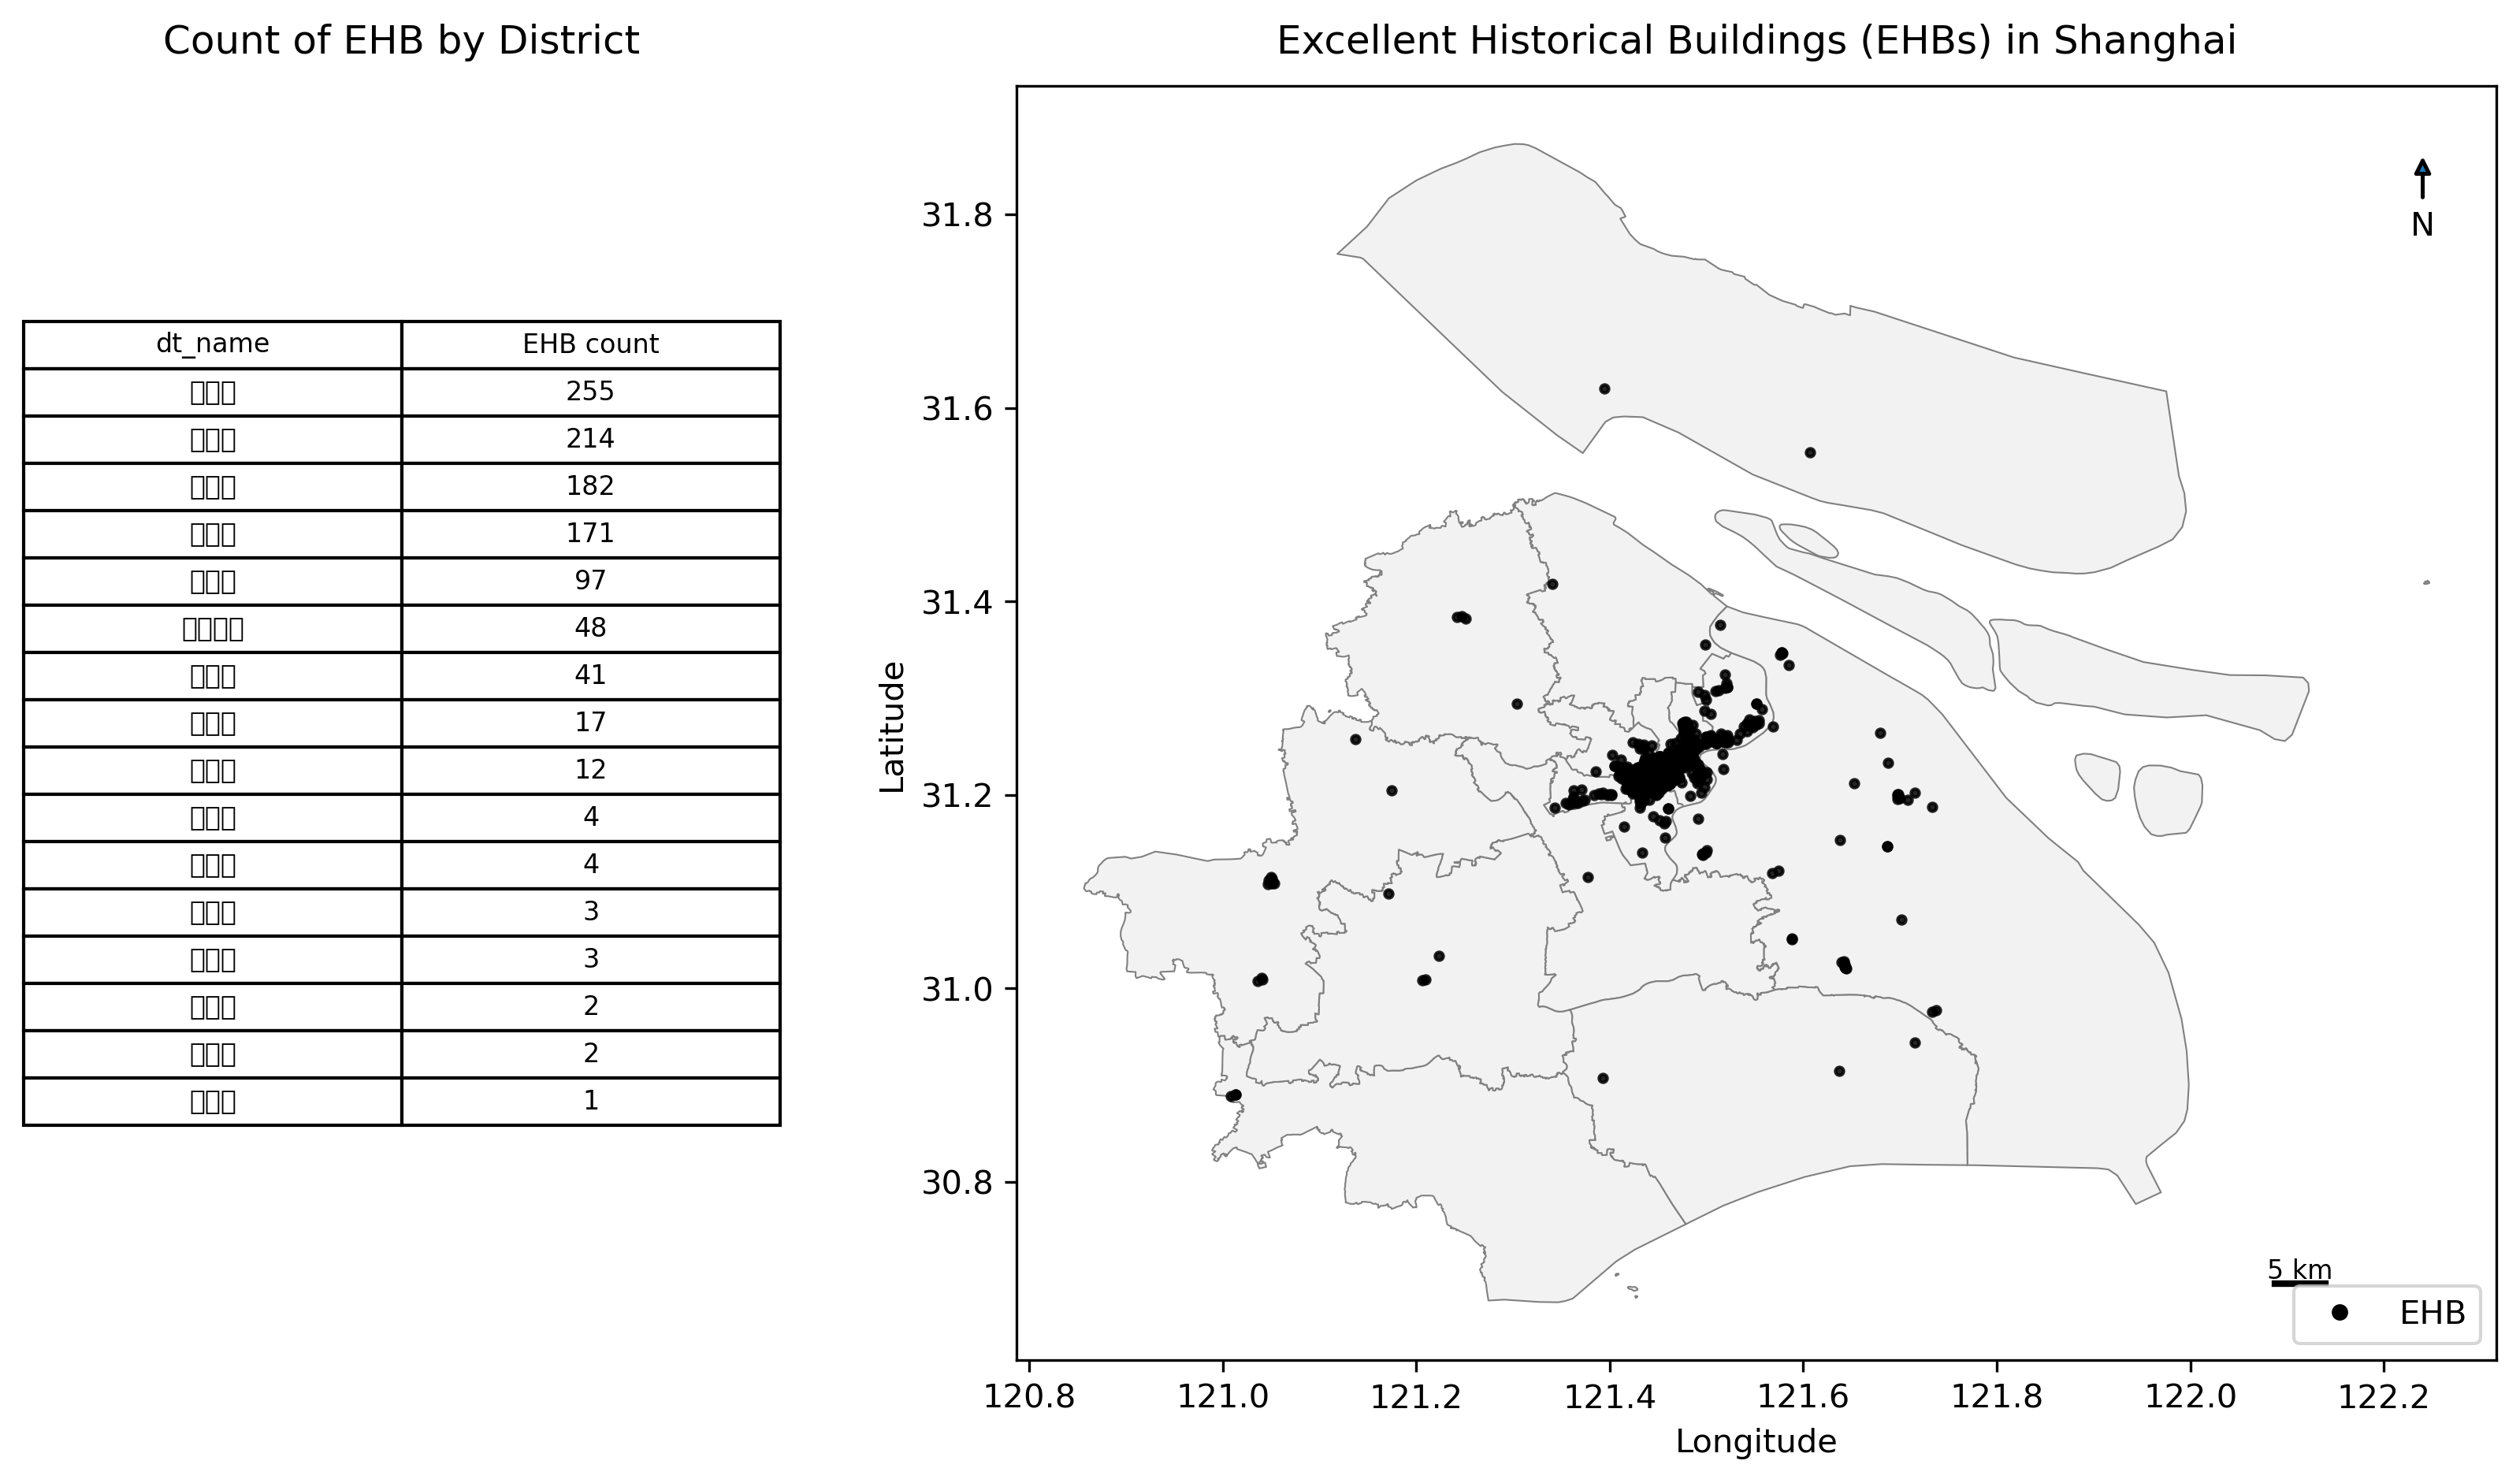

In [3]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import re

# ---------- paths (edit if needed) ----------
SHANGHAI_SHP = "/Users/sillyfish/Desktop/dissertation/DATA/data_shanghai_district/shanghai_district.shp"
EHB_XLSX     = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
OUT_PNG      = "/Users/sillyfish/Desktop/dissertation/OUTPUTS/fig_study_area_ehb_shanghai.png"
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)

# ---------- load districts ----------
districts = gpd.read_file(SHANGHAI_SHP)
if districts.crs is None:
    districts.set_crs(epsg=4326, inplace=True)
districts = districts.to_crs(epsg=4326)

# pick a district-name field (auto-guess; change if needed)
name_cols = [c for c in districts.columns if re.search("name|区|NAME|Name", c, re.I)]
DIST_NAME_FIELD = name_cols[0] if name_cols else districts.columns[0]

# ---------- load EHB points (using lon_wgs84/lat_wgs84) ----------
df = pd.read_excel(EHB_XLSX)

required = {"lon_wgs84", "lat_wgs84"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in Excel: {missing}. Expected {required}")

lon = pd.to_numeric(df["lon_wgs84"], errors="coerce")
lat = pd.to_numeric(df["lat_wgs84"], errors="coerce")
gdf_ehb = gpd.GeoDataFrame(
    df.assign(__lon=lon, __lat=lat),
    geometry=[Point(xy) if pd.notna(xy[0]) and pd.notna(xy[1]) else None for xy in zip(lon, lat)],
    crs="EPSG:4326"
).dropna(subset=["geometry"]).copy()

# ---------- count EHBs by district ----------
joined = gpd.sjoin(gdf_ehb.to_crs(districts.crs),
                   districts[[DIST_NAME_FIELD, "geometry"]],
                   how="left", predicate="within")
count_by_dist = (joined.groupby(DIST_NAME_FIELD)
                        .size()
                        .sort_values(ascending=False)
                        .rename("EHB count")
                        .to_frame())

# ---------- plot (table + map) ----------
fig = plt.figure(figsize=(14, 7), dpi=300)
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.0, 2.2], wspace=0.12)

# left: table
ax_table = fig.add_subplot(gs[0, 0])
ax_table.axis("off")
tbl = ax_table.table(
    cellText=count_by_dist.reset_index().values,
    colLabels=[DIST_NAME_FIELD, "EHB count"],
    loc="center",
    cellLoc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.2)
ax_table.set_title("Count of EHB by District", pad=10)

# right: map
ax = fig.add_subplot(gs[0, 1])
districts.plot(ax=ax, edgecolor="0.5", facecolor="0.95", linewidth=0.5)
gdf_ehb.plot(ax=ax, markersize=6, color="black", alpha=0.85)

ax.set_aspect("equal")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Excellent Historical Buildings (EHBs) in Shanghai", pad=10)

# simple legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='EHB',
                          markerfacecolor='black', markersize=6)]
ax.legend(handles=legend_elements, loc="lower right", frameon=True)

# simple north arrow
def add_north_arrow(ax, x=0.95, y=0.95, size=0.06):
    ax.annotate('N', xy=(x, y), xytext=(x, y - size),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='-|>', lw=1.2),
                ha='center', va='center', fontsize=10)
add_north_arrow(ax)

# simple scale bar (~5 km) using degree-km approx at 31°N
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
deg_per_km = 1.0 / 95.9  # approx lon degrees per km near 31°N
scale_km = 5
scale_deg = scale_km * deg_per_km
x0 = xmax - 0.15 * (xmax - xmin)
y0 = ymin + 0.06 * (ymax - ymin)
ax.plot([x0, x0 + scale_deg], [y0, y0], color="k", lw=2)
ax.text(x0 + scale_deg / 2, y0, f"{scale_km} km", ha="center", va="bottom", fontsize=8)

plt.savefig(OUT_PNG, bbox_inches="tight")
print(f"Saved figure to: {OUT_PNG}")
plt.show()


Saved:
- /Users/sillyfish/Desktop/dissertation/OUTPUTS/fig_study_area_ehb_shanghai.png
- /Users/sillyfish/Desktop/dissertation/OUTPUTS/fig_study_area_ehb_shanghai.svg


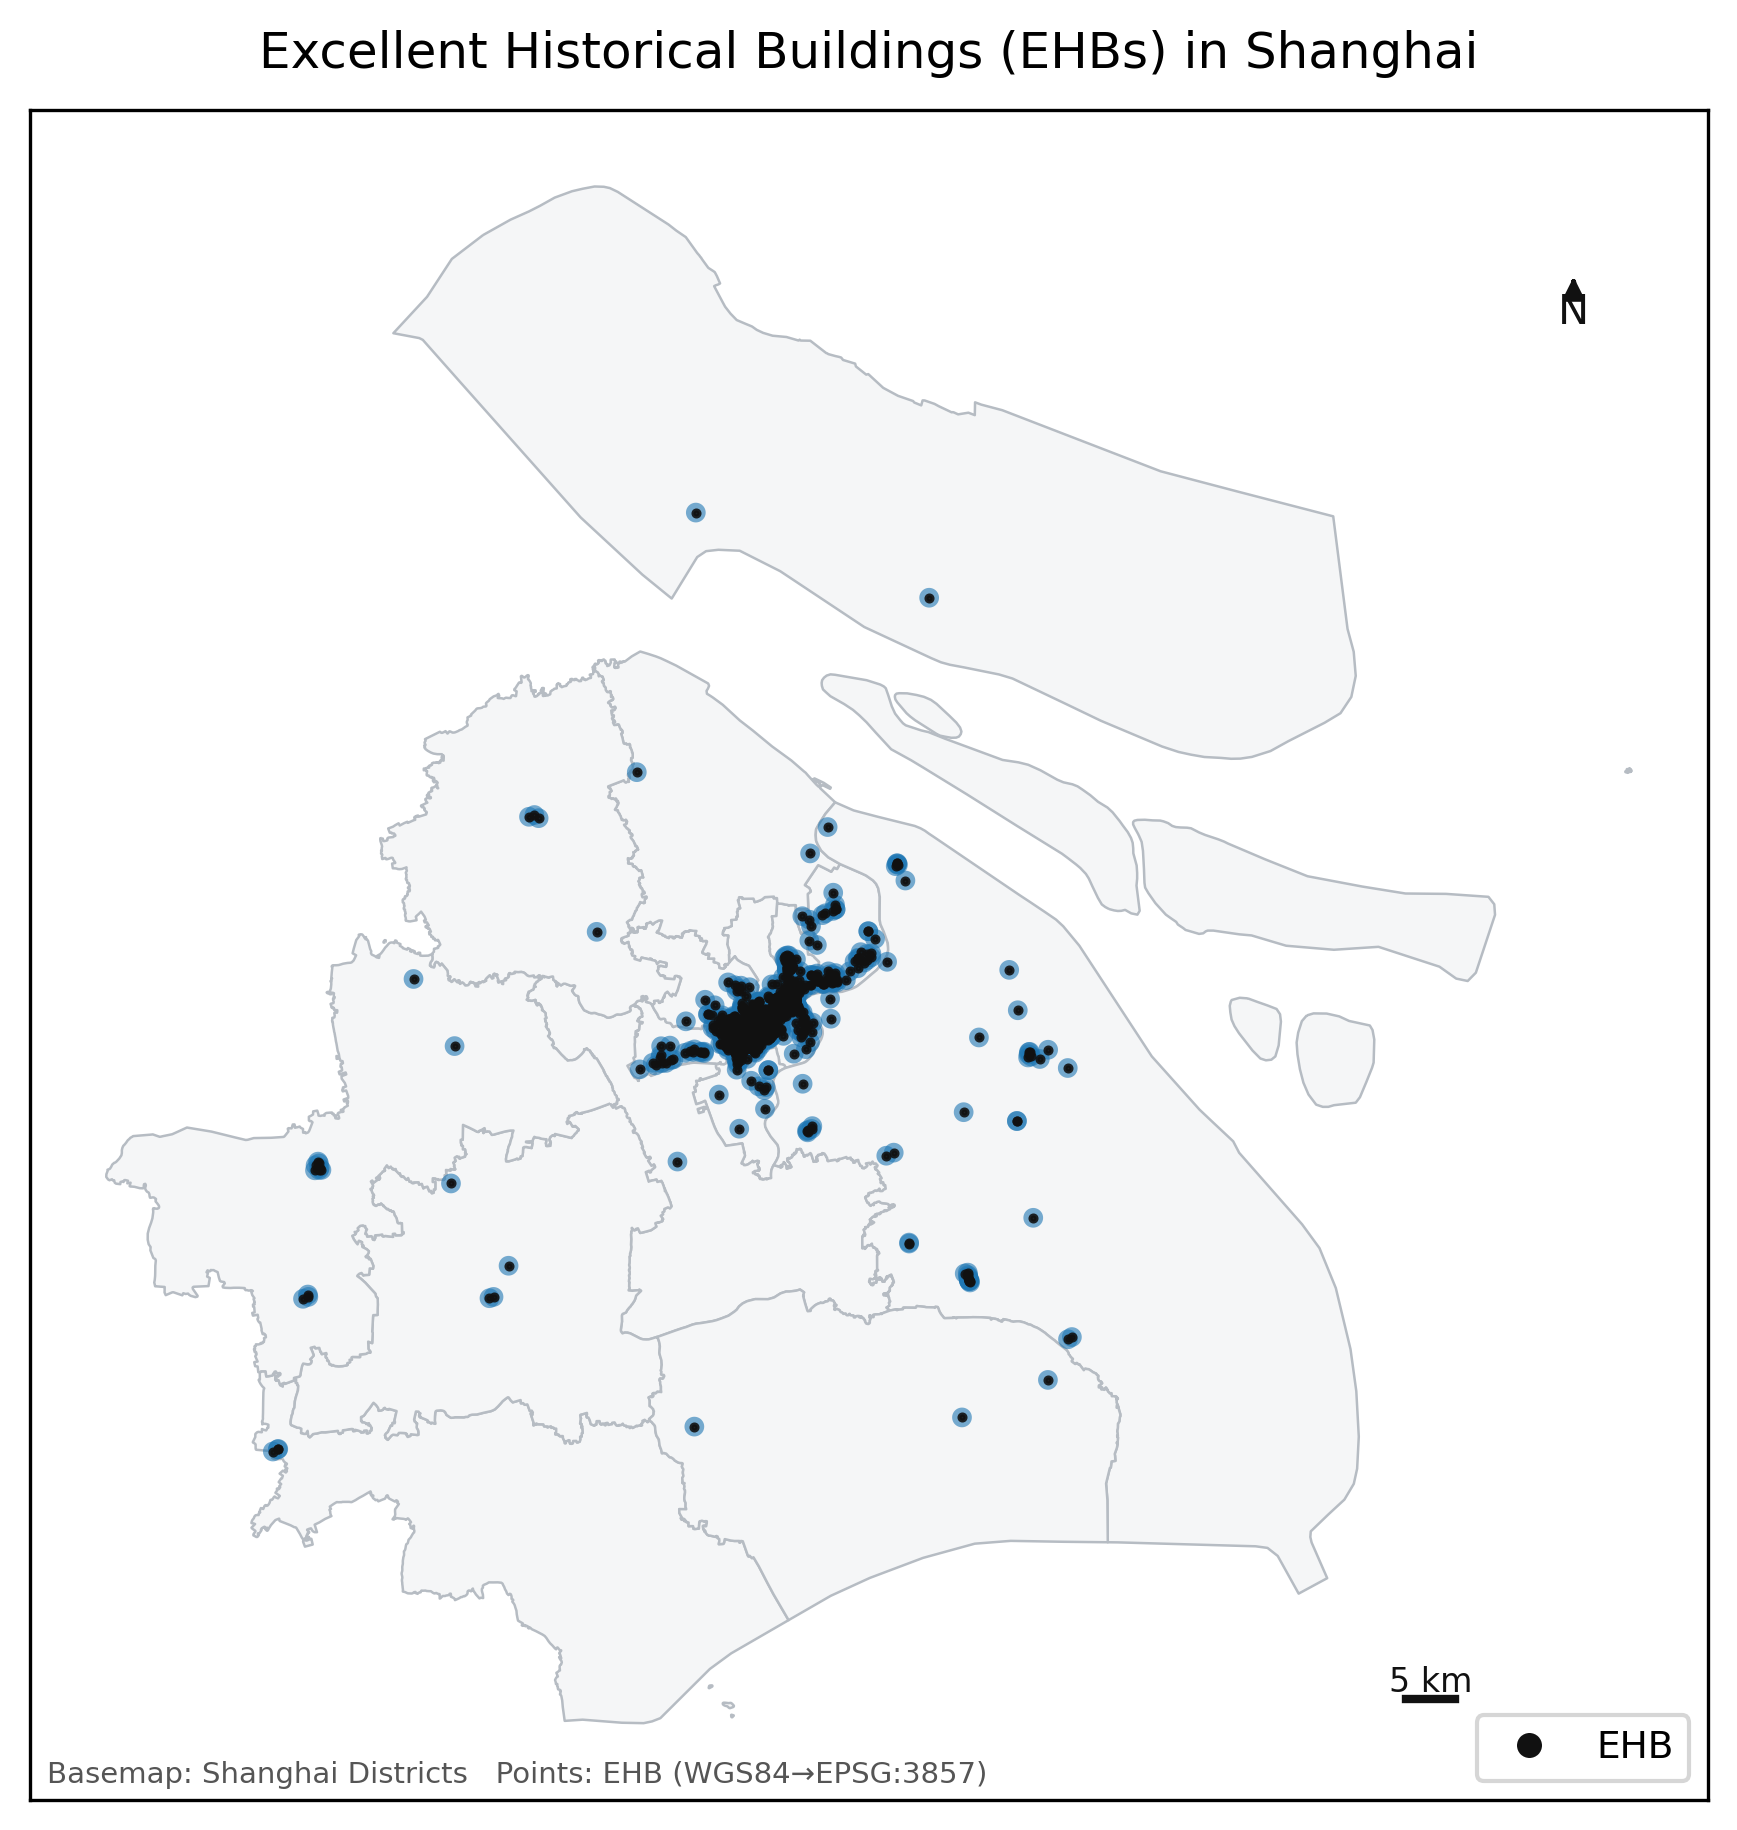

In [9]:
# -*- coding: utf-8 -*-
import os, re
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ===== 路径（按需改） =====
SHANGHAI_SHP = "/Users/sillyfish/Desktop/dissertation/DATA/data_shanghai_district/shanghai_district.shp"
EHB_XLSX     = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
OUT_DIR      = "/Users/sillyfish/Desktop/dissertation/OUTPUTS"
OUT_PNG      = os.path.join(OUT_DIR, "fig_study_area_ehb_shanghai.png")
OUT_SVG      = os.path.join(OUT_DIR, "fig_study_area_ehb_shanghai.svg")
os.makedirs(OUT_DIR, exist_ok=True)

# ===== 读取行政区，多数 shp 是经纬度；无则设为 WGS84 =====
districts = gpd.read_file(SHANGHAI_SHP)
if districts.crs is None:
    districts = districts.set_crs(epsg=4326)

# ===== 读取 EHB 点（使用 lon_wgs84 / lat_wgs84）=====
df = pd.read_excel(EHB_XLSX)
if not {"lon_wgs84", "lat_wgs84"}.issubset(df.columns):
    raise ValueError("Excel 需包含列：lon_wgs84, lat_wgs84")

ehb = gpd.GeoDataFrame(
    df.copy(),
    geometry=[Point(xy) if pd.notna(xy[0]) and pd.notna(xy[1]) else None
              for xy in zip(pd.to_numeric(df["lon_wgs84"], errors="coerce"),
                            pd.to_numeric(df["lat_wgs84"], errors="coerce"))],
    crs="EPSG:4326"
).dropna(subset=["geometry"])

# ===== 投影到 Web Mercator 以便比例尺（单位：米）=====
districts_m = districts.to_crs(epsg=3857)
ehb_m       = ehb.to_crs(epsg=3857)

# ===== 可选：绘制 1 km 透明缓冲圈（可设 False 关闭）=====
DRAW_1KM_BUFFER = True
if DRAW_1KM_BUFFER:
    ehb_buf1k = ehb_m.copy()
    ehb_buf1k["geometry"] = ehb_buf1k.buffer(1000)  # 1000 m

# ===== 画图 =====
fig, ax = plt.subplots(figsize=(8.8, 6.2), dpi=300)

# 底图样式：柔和的灰白，细边界
districts_m.plot(ax=ax, facecolor="#F5F6F7", edgecolor="#B6BCC3", linewidth=0.6)

# 1km 缓冲圈（在点的下层）
if DRAW_1KM_BUFFER:
    ehb_buf1k.plot(ax=ax, facecolor="#1f77b4", edgecolor="none", alpha=0.6)

# EHB 点（略大、稍微加深）
ehb_m.plot(ax=ax, color="#111111", markersize=2, alpha=0.9)

# —— 北箭头 —— #
def add_north_arrow(ax, size=9000):
    # 在图右上角画一个简单指北针
    xlim = ax.get_xlim(); ylim = ax.get_ylim()
    x = xlim[0] + 0.92*(xlim[1]-xlim[0])
    y = ylim[0] + 0.88*(ylim[1]-ylim[0])
    ax.annotate('N', xy=(x, y+size*0.4), xytext=(x, y),
                arrowprops=dict(arrowstyle='-|>', lw=1.2, color="#111111"),
                ha='center', va='center', fontsize=10, color="#111111")
add_north_arrow(ax)

# —— 比例尺（米制，准确） —— #
def add_scale_bar(ax, length_km=5):
    # 在右下角画一个 length_km 的比例尺
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    length_m = length_km * 1000
    xb = x1 - 0.18*(x1-x0)
    yb = y0 + 0.06*(y1-y0)
    ax.plot([xb, xb+length_m], [yb, yb], color="#111111", lw=2)
    ax.text(xb + length_m/2, yb, f"{length_km} km",
            ha="center", va="bottom", fontsize=8, color="#111111")
add_scale_bar(ax, length_km=5)

# 轴样式：去掉坐标轴刻度，让版式更“地图化”
ax.set_axisbelow(True)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_aspect('equal')

# 标题与署名
ax.set_title("Excellent Historical Buildings (EHBs) in Shanghai", fontsize=12, pad=10)
ax.text(0.01, 0.01, "Basemap: Shanghai Districts   Points: EHB (WGS84→EPSG:3857)",
        transform=ax.transAxes, fontsize=7, color="#555555")

# 图例（仅一个点符号）
legend_elements = [Line2D([0],[0], marker='o', color='w', label='EHB',
                          markerfacecolor="#111111", markersize=7)]
ax.legend(handles=legend_elements, loc="lower right", frameon=True, fontsize=9)

# 边距与导出
plt.tight_layout()
fig.savefig(OUT_PNG, dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(OUT_SVG, bbox_inches="tight", facecolor="white")
print(f"Saved:\n- {OUT_PNG}\n- {OUT_SVG}")
plt.show()


Also saved to:
- /Users/sillyfish/Desktop/dissertation/DATA/fig_study_area_ehb_shanghai.png
- /Users/sillyfish/Desktop/dissertation/DATA/fig_study_area_ehb_shanghai.svg


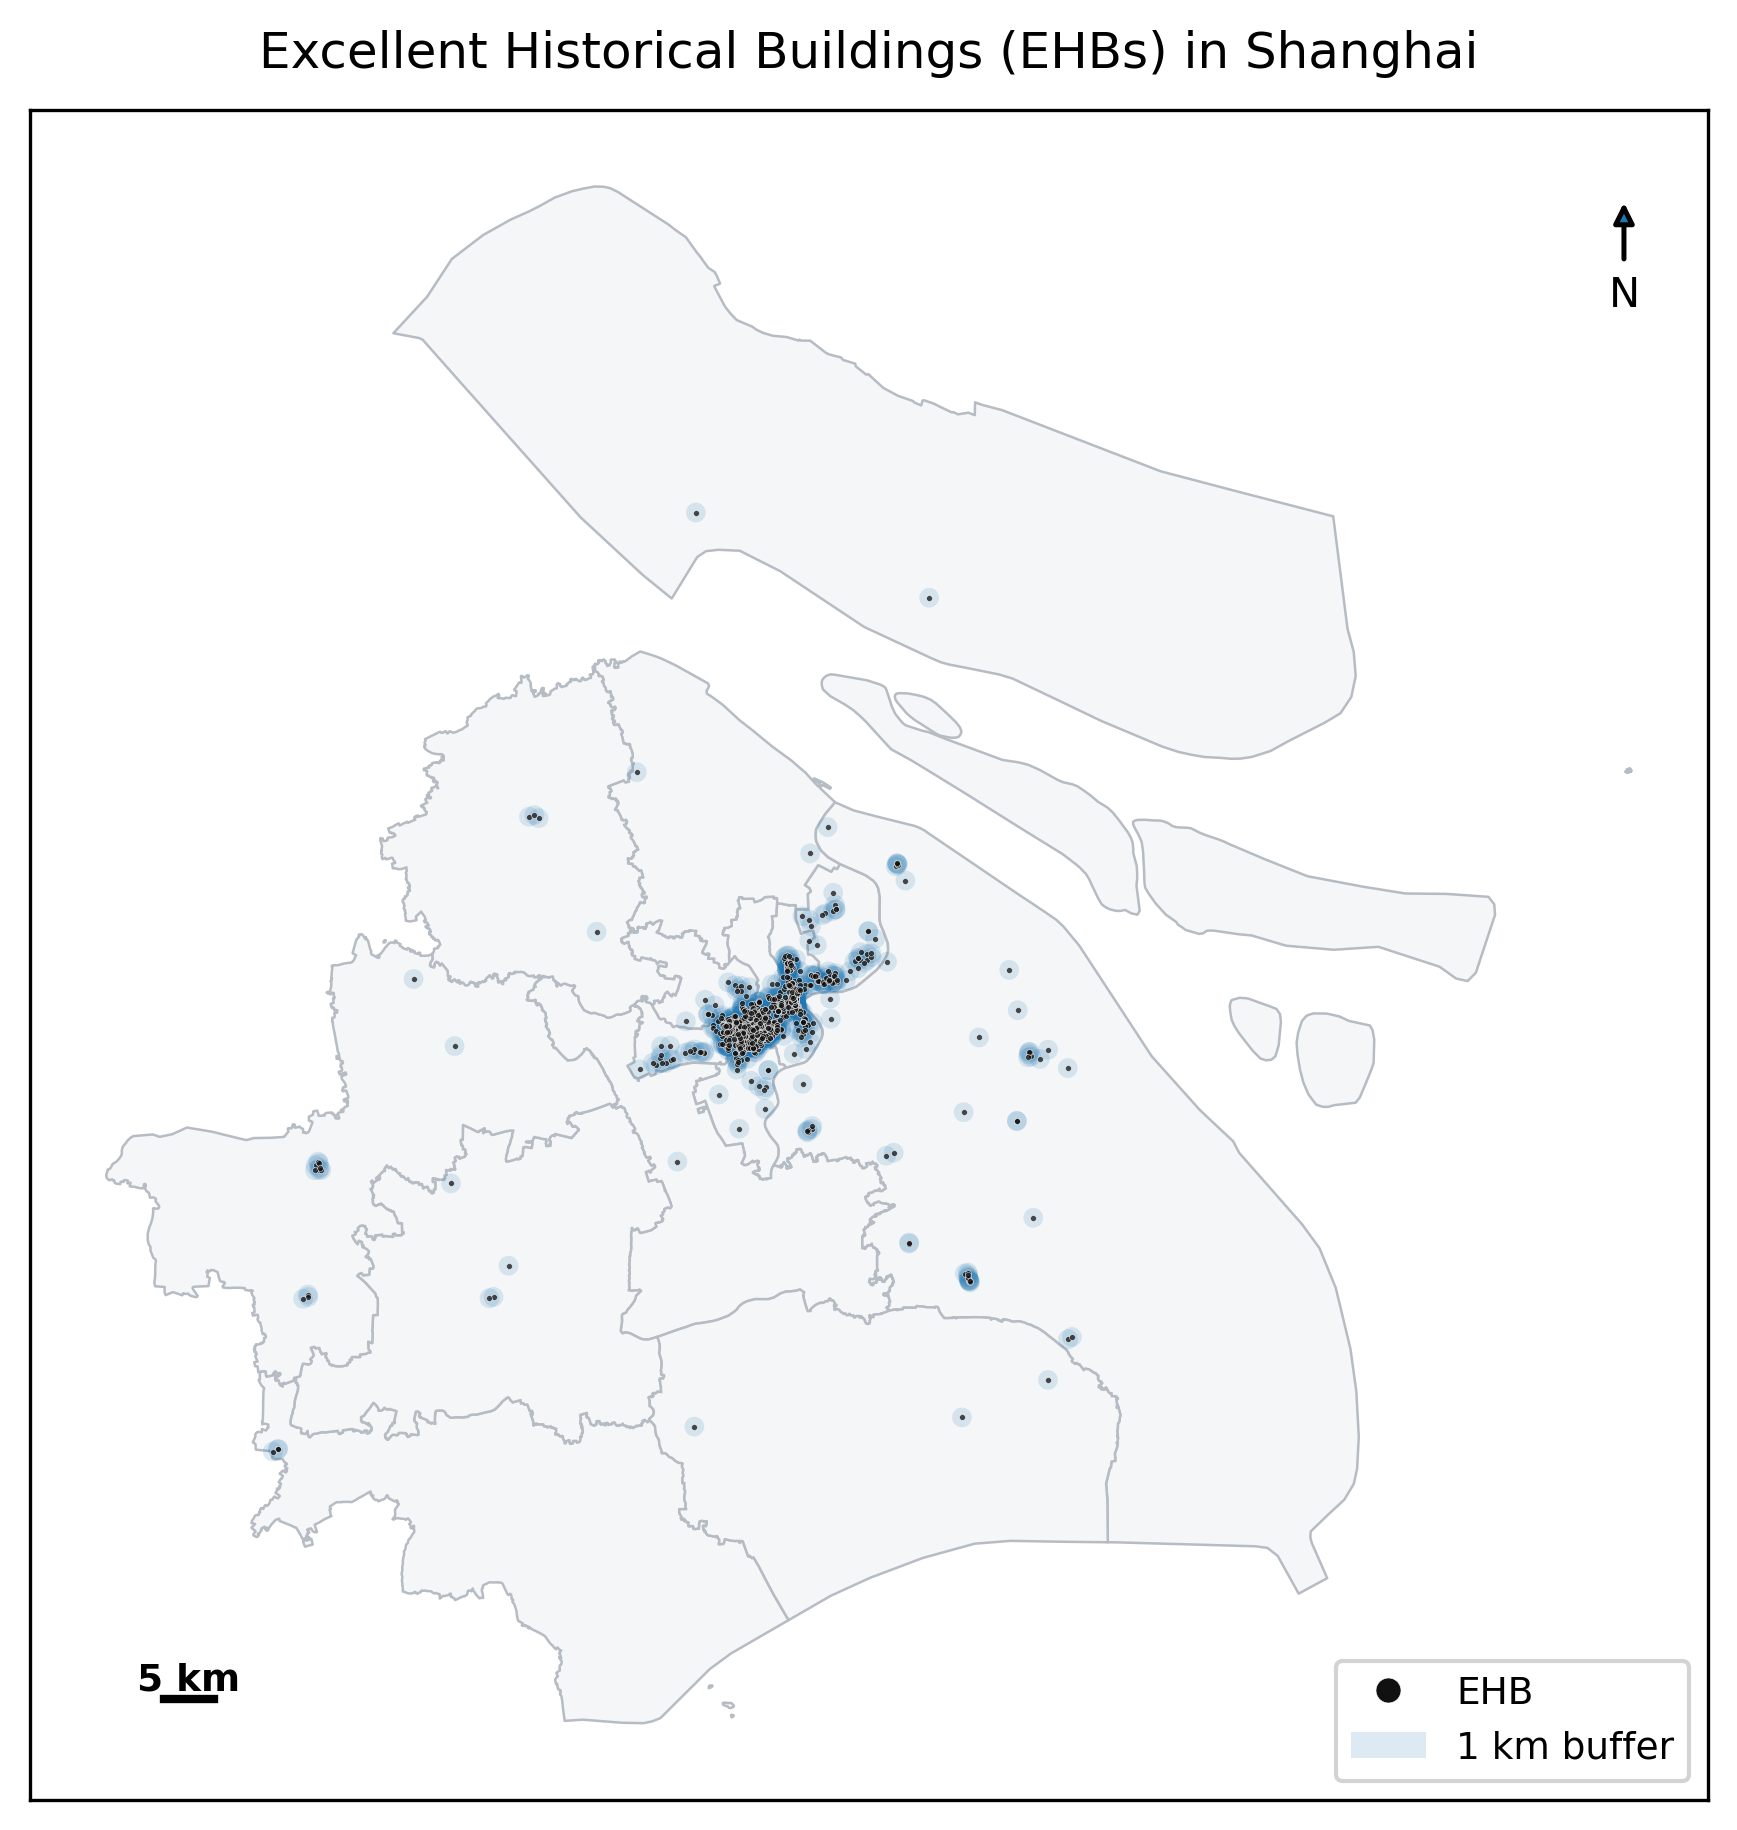

In [21]:
# ===== 画图 =====
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(8.8, 6.2), dpi=300)

# 底图样式：柔和灰白 + 细边界
districts_m.plot(ax=ax, facecolor="#F5F6F7", edgecolor="#B6BCC3", linewidth=0.6)

# 1km 缓冲圈（在点的下层；透明度降低更干净）
if DRAW_1KM_BUFFER:
    BUF_FACE = "#1f77b4"
    BUF_ALPHA = 0.15
    ehb_buf1k.plot(ax=ax, facecolor=BUF_FACE, edgecolor="none", alpha=BUF_ALPHA)

# EHB 点（更小 + 白色细描边帮助辨识）
ehb_m.plot(
    ax=ax,
    facecolor="#111111",
    edgecolor="white",
    linewidth=0.15,
    markersize=2,
    alpha=0.75
)

# simple north arrow
def add_north_arrow(ax, x=0.95, y=0.95, size=0.06):
    ax.annotate('N', xy=(x, y), xytext=(x, y - size),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='-|>', lw=1.2),
                ha='center', va='center', fontsize=10)
add_north_arrow(ax)

# —— 图例：移动到右上角，避免与比例尺重叠 —— #
legend_items = [
    Line2D([0], [0], marker='o', color='w', label='EHB',
           markerfacecolor="#111111", markeredgecolor="white", markeredgewidth=0.15,
           markersize=6),
]
if DRAW_1KM_BUFFER:
    legend_items.append(
        mpatches.Patch(facecolor=BUF_FACE, edgecolor='none', alpha=BUF_ALPHA, label='1 km buffer')
    )

ax.legend(handles=legend_items, loc="upper right", frameon=True, fontsize=9)


# 轴样式：去刻度
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_aspect('equal')

# 标题
ax.set_title("Excellent Historical Buildings (EHBs) in Shanghai", fontsize=12, pad=10)

# —— 图例：放在左下角，带半透明背景 —— #
legend_items = [
    Line2D([0], [0], marker='o', color='w', label='EHB',
           markerfacecolor="#111111", markeredgecolor="white", markeredgewidth=0.15,
           markersize=6),
]
if DRAW_1KM_BUFFER:
    legend_items.append(
        mpatches.Patch(facecolor=BUF_FACE, edgecolor='none', alpha=BUF_ALPHA, label='1 km buffer')
    )

leg = ax.legend(handles=legend_items, loc="lower right", frameon=True, fontsize=9)
leg.get_frame().set_alpha(0.85)   # 设置图例框透明度（0=完全透明，1=不透明）

# —— 左下角比例尺 —— #
def add_scale_bar_lowerleft(ax, length_km=5):
    """在左下角绘制比例尺，单位 km"""
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    length_m = length_km * 1000
    # 定位在左下角（距边界留 8% 水平 + 6% 垂直空隙）
    xb = x0 + 0.08 * (x1 - x0)
    yb = y0 + 0.06 * (y1 - y0)
    # 绘制比例尺线
    ax.plot([xb, xb + length_m], [yb, yb], color="black", lw=2)
    # 标注文字
    ax.text(xb + length_m/2, yb, f"{length_km} km",
            ha="center", va="bottom", fontsize=9, color="black", fontweight="bold")

# 使用
add_scale_bar_lowerleft(ax, length_km=5)

# ===== 额外保存到 data 文件夹 =====
OUT_DIR_DATA = "/Users/sillyfish/Desktop/dissertation/DATA"
os.makedirs(OUT_DIR_DATA, exist_ok=True)

OUT_PNG_DATA = os.path.join(OUT_DIR_DATA, "fig_study_area_ehb_shanghai.png")
OUT_SVG_DATA = os.path.join(OUT_DIR_DATA, "fig_study_area_ehb_shanghai.svg")

fig.savefig(OUT_PNG_DATA, dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(OUT_SVG_DATA, bbox_inches="tight", facecolor="white")

print(f"Also saved to:\n- {OUT_PNG_DATA}\n- {OUT_SVG_DATA}")


# 备注信息（按需保留/删除）
# ax.text(0.01, 0.01, "Basemap: Shanghai Districts   Points: EHB (WGS84→EPSG:3857)",
#         transform=ax.transAxes, fontsize=7, color="#555555")

plt.tight_layout()
fig.savefig(OUT_PNG, dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(OUT_SVG, bbox_inches="tight", facecolor="white")
plt.show()


/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_1524/3575159697.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


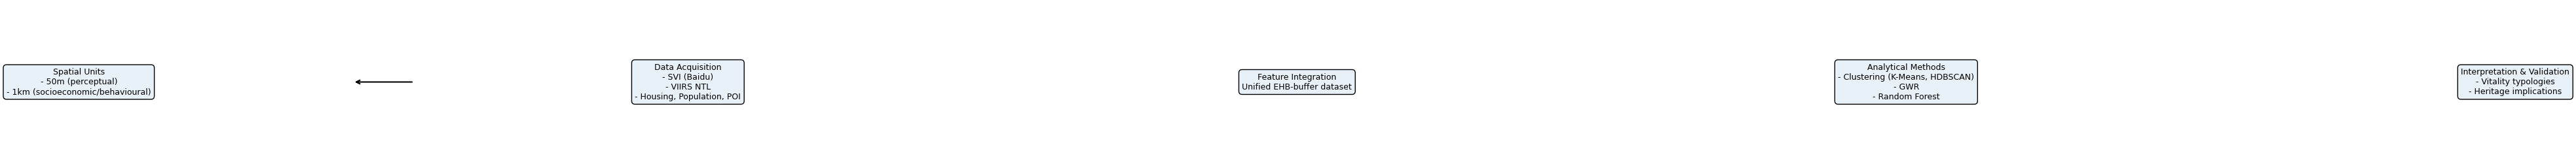

In [23]:
import matplotlib.pyplot as plt

# 流程节点
steps = [
    "Spatial Units\n- 50m (perceptual)\n- 1km (socioeconomic/behavioural)",
    "Data Acquisition\n- SVI (Baidu)\n- VIIRS NTL\n- Housing, Population, POI",
    "Feature Integration\nUnified EHB-buffer dataset",
    "Analytical Methods\n- Clustering (K-Means, HDBSCAN)\n- GWR\n- Random Forest",
    "Interpretation & Validation\n- Vitality typologies\n- Heritage implications"
]

# 画布
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis("off")

# 绘制节点
box_props = dict(boxstyle="round,pad=0.4", facecolor="#E8F0F8", edgecolor="black")
arrow_props = dict(arrowstyle="->", lw=1.5, color="black")

x_positions = range(len(steps))
y = 0.5

for i, (x, text) in enumerate(zip(x_positions, steps)):
    ax.text(x, y, text, ha="center", va="center", fontsize=9,
            bbox=box_props)
    if i < len(steps)-1:
        ax.annotate("",
                    xy=(x+0.45, y), xycoords="data",
                    xytext=(x+0.55, y), textcoords="data",
                    arrowprops=arrow_props)

plt.tight_layout()
plt.show()


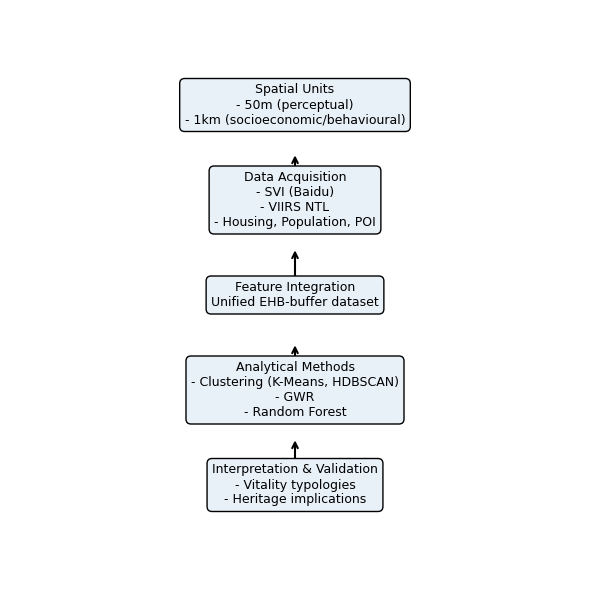

In [25]:
import matplotlib.pyplot as plt

# 流程节点
steps = [
    "Spatial Units\n- 50m (perceptual)\n- 1km (socioeconomic/behavioural)",
    "Data Acquisition\n- SVI (Baidu)\n- VIIRS NTL\n- Housing, Population, POI",
    "Feature Integration\nUnified EHB-buffer dataset",
    "Analytical Methods\n- Clustering (K-Means, HDBSCAN)\n- GWR\n- Random Forest",
    "Interpretation & Validation\n- Vitality typologies\n- Heritage implications"
]

# 画布（正方形，适合论文）
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")

# 绘制节点
box_props = dict(boxstyle="round,pad=0.4", facecolor="#E8F0F8", edgecolor="black")
arrow_props = dict(arrowstyle="->", lw=1.5, color="black")

y_positions = list(range(len(steps)))[::-1]  # 从上到下排列
x = 0.5  # 居中

for i, (y, text) in enumerate(zip(y_positions, steps)):
    ax.text(x, y, text, ha="center", va="center", fontsize=9,
            bbox=box_props)
    if i < len(steps)-1:
        ax.annotate("",
                    xy=(x, y-0.5), xycoords="data",
                    xytext=(x, y-0.9), textcoords="data",
                    arrowprops=arrow_props)

# 调整坐标范围，使布局紧凑
ax.set_xlim(0, 1)
ax.set_ylim(-1, len(steps))

plt.tight_layout()
plt.show()


In [3]:
# -*- coding: utf-8 -*-
"""
2x2 panel for Cityscapes semantic segmentation:
(a) Original (b) Mask (c) Overlay (d) Class-proportion bar

Priority: TensorFlow SavedModel (Panoptic/DeepLab, Cityscapes) -> (optional) Torch fallback
"""

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ======= 修改为你的路径 =======
MODEL_DIR  = "/Users/sillyfish/Desktop/dissertation/DATA/resnet50_beta_os32_panoptic_deeplab_cityscapes_trainfine_saved_model"
IMAGE_PATH = "/Users/sillyfish/Desktop/dissertation/DATA/00215.png"
OUT_PNG    = "/Users/sillyfish/Desktop/dissertation/OUTPUTS/seg_panel_cityscapes.png"
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)
# ============================

# Cityscapes 19 类调色板（常用）
PALETTE = np.array([
    [128,  64, 128],  # road
    [244,  35, 232],  # sidewalk
    [ 70,  70,  70],  # building
    [102, 102, 156],  # wall
    [190, 153, 153],  # fence
    [153, 153, 153],  # pole
    [250, 170,  30],  # traffic light
    [220, 220,   0],  # traffic sign
    [107, 142,  35],  # vegetation
    [152, 251, 152],  # terrain
    [ 70, 130, 180],  # sky
    [220,  20,  60],  # person
    [255,   0,   0],  # rider
    [  0,   0, 142],  # car
    [  0,   0,  70],  # truck
    [  0,  60, 100],  # bus
    [  0,  80, 100],  # train
    [  0,   0, 230],  # motorcycle
    [119,  11,  32],  # bicycle
], dtype=np.uint8)

NCLS = PALETTE.shape[0]
NAMES = [
    "road","sidewalk","building","wall","fence","pole",
    "traffic light","traffic sign","vegetation","terrain","sky",
    "person","rider","car","truck","bus","train","motorcycle","bicycle"
]

def pad_to_multiple(img_np, multiple=32, value=0):
    """pad H,W to multiples of `multiple` (OS=32 friendly)."""
    h, w = img_np.shape[:2]
    nh = (h + multiple - 1) // multiple * multiple
    nw = (w + multiple - 1) // multiple * multiple
    pad = np.ones((nh, nw, 3), dtype=img_np.dtype) * value
    pad[:h, :w] = img_np
    return pad, (h, w)

def crop_back(label, orig_hw):
    h, w = orig_hw
    return label[:h, :w]

def colorize(label):
    color = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    u = np.unique(label)
    for k in u:
        if k < 0: continue
        color[label == k] = PALETTE[k % NCLS]
    return color

def proportions(label):
    hist = np.bincount(np.clip(label, 0, NCLS-1).ravel(), minlength=NCLS).astype(float)
    p = hist / (hist.sum() + 1e-9)
    return p

# ========= 1) TF SavedModel 推理 =========
def infer_tf_saved_model(model_dir, image_np):
    try:
        import tensorflow as tf

        # 尺寸 & 类型
        img_pad, orig_hw = pad_to_multiple(image_np, 32, 0)

        # 两种常见输入规范：uint8[0,255] 或 float32[0,1]
        candidates = [
            tf.convert_to_tensor(img_pad[None, ...], dtype=tf.uint8),
            tf.convert_to_tensor(img_pad[None, ...] / 255.0, dtype=tf.float32),
        ]

        model = tf.saved_model.load(model_dir)
        sigs = list(model.signatures.keys())
        fn  = model.signatures.get("serving_default", None) or model.signatures[sigs[0]]

        out = None
        for inp in candidates:
            try:
                # 推理时不同模型可能使用不同参数名
                try:
                    out = fn(inp)
                except Exception:
                    try:
                        out = fn(image=inp)
                    except Exception:
                        out = fn(images=inp)
                break
            except Exception:
                continue
        if out is None:
            return None

        # 取语义输出：常见键
        keys = ["semantic", "semantic_pred", "segmentation", "category_mask", "panoptic_pred"]
        y = None
        for k in keys:
            if k in out:
                y = out[k]
                break
        if y is None:
            # 兜底：第一个 tensor
            y = list(out.values())[0]

        y = y[0].numpy()
        # 有些 panoptic 输出是 [H,W,2]（语义id, instance id），或 one-hot/logits
        if y.ndim == 3:
            if y.shape[-1] == 1:
                y = y[..., 0]
            elif y.shape[-1] <= 8:         # 很少见，但有的把 (sem,inst,…) 放最后通道
                y = y[..., 0]
            else:                           # 可能是 logits: [H,W,C]
                y = y.argmax(-1)

        y = y.astype(np.int32)
        y = crop_back(y, orig_hw)
        return y
    except Exception as e:
        print(f"[TF SavedModel] failed: {e}")
        return None

# ========= 2) 备选：Torch DeepLabV3 (COCO/VOC) =========
def infer_torch(image_np):
    try:
        import torch
        import torchvision.transforms as T
        from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

        img_pil = Image.fromarray(image_np)
        weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
        model = deeplabv3_resnet50(weights=weights).eval()
        trf = weights.transforms()
        inp = trf(img_pil).unsqueeze(0)
        with torch.no_grad():
            out = model(inp)["out"][0]        # [C,H,W]
            lab = out.argmax(0).cpu().numpy().astype(np.int32)
        # 注意：这是 COCO/VOC 类别映射，与 Cityscapes 不同，仅作为兜底可视化参考
        return lab
    except Exception as e:
        print(f"[Torch] failed: {e}")
        return None

def main():
    img = Image.open(IMAGE_PATH).convert("RGB")
    img_np = np.array(img)

    # 以 TF SavedModel 为主
    label = None
    if os.path.isdir(MODEL_DIR):
        label = infer_tf_saved_model(MODEL_DIR, img_np)
    # 如需强制不用 PyTorch 兜底，可直接在这里抛错
    if label is None:
        print("Falling back to torchvision DeepLabV3 (COCO/VOC)…")
        label = infer_torch(img_np)
        if label is None:
            raise RuntimeError("Both SavedModel and Torch inference failed.")

    # 面板绘制
    mask_rgb = colorize(label)
    overlay  = Image.blend(Image.fromarray(img_np).convert("RGBA"),
                           Image.fromarray(mask_rgb).convert("RGBA"),
                           alpha=0.45)

    p = proportions(label)
    # 控制台打印前几位占比，便于排错
    topk = np.argsort(-p)[:6]
    print("Top classes:", [(NAMES[i], float(p[i])) for i in topk if p[i] > 0])

    fig = plt.figure(figsize=(12, 8), dpi=220)
    gs  = fig.add_gridspec(2, 2, height_ratios=[1,1])

    ax1 = fig.add_subplot(gs[0,0]); ax1.imshow(img_np);    ax1.set_title("(a) Original"); ax1.axis("off")
    ax2 = fig.add_subplot(gs[0,1]); ax2.imshow(mask_rgb);  ax2.set_title("(b) Segmentation mask"); ax2.axis("off")
    ax3 = fig.add_subplot(gs[1,0]); ax3.imshow(overlay);   ax3.set_title("(c) Overlay"); ax3.axis("off")

    ax4 = fig.add_subplot(gs[1,1])
    # 画连续比例条
    left = 0.02
    for i, pi in enumerate(p):
        if pi <= 0: continue
        ax4.barh(0, pi, left=left, color=PALETTE[i]/255.0, edgecolor="none", height=0.28)
        left += pi
    ax4.set_xlim(0, 1); ax4.set_ylim(-0.6, 0.6); ax4.set_yticks([])
    ax4.set_xticks([0,0.25,0.5,0.75,1.0])
    ax4.set_xlabel("(d) Class proportions")
    for spine in ["top","right","left","bottom"]:
        ax4.spines[spine].set_visible(False)

    plt.tight_layout()
    fig.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
    print(f"Saved: {OUT_PNG}")
    plt.show()

if __name__ == "__main__":
    main()


Falling back to torchvision DeepLabV3 (COCO/VOC)…


ValueError: images do not match

In [5]:
# —— 确保尺寸一致后再叠加 —— #
H, W = img_np.shape[:2]
mask_rgb_resized = Image.fromarray(mask_rgb).resize((W, H), resample=Image.NEAREST)  # 语义标签用最近邻
img_pil_rgba     = Image.fromarray(img_np).convert("RGBA")
mask_pil_rgba    = mask_rgb_resized.convert("RGBA")

overlay = Image.blend(img_pil_rgba, mask_pil_rgba, alpha=0.45)


NameError: name 'img_np' is not defined

Falling back to torchvision DeepLabV3 (COCO/VOC)…
Top classes: [('road', 0.9953975591715957), ('traffic sign', 0.004031065088757389), ('bus', 0.0005713757396449693)]
Saved: /Users/sillyfish/Desktop/dissertation/OUTPUTS/seg_panel_cityscapes.png


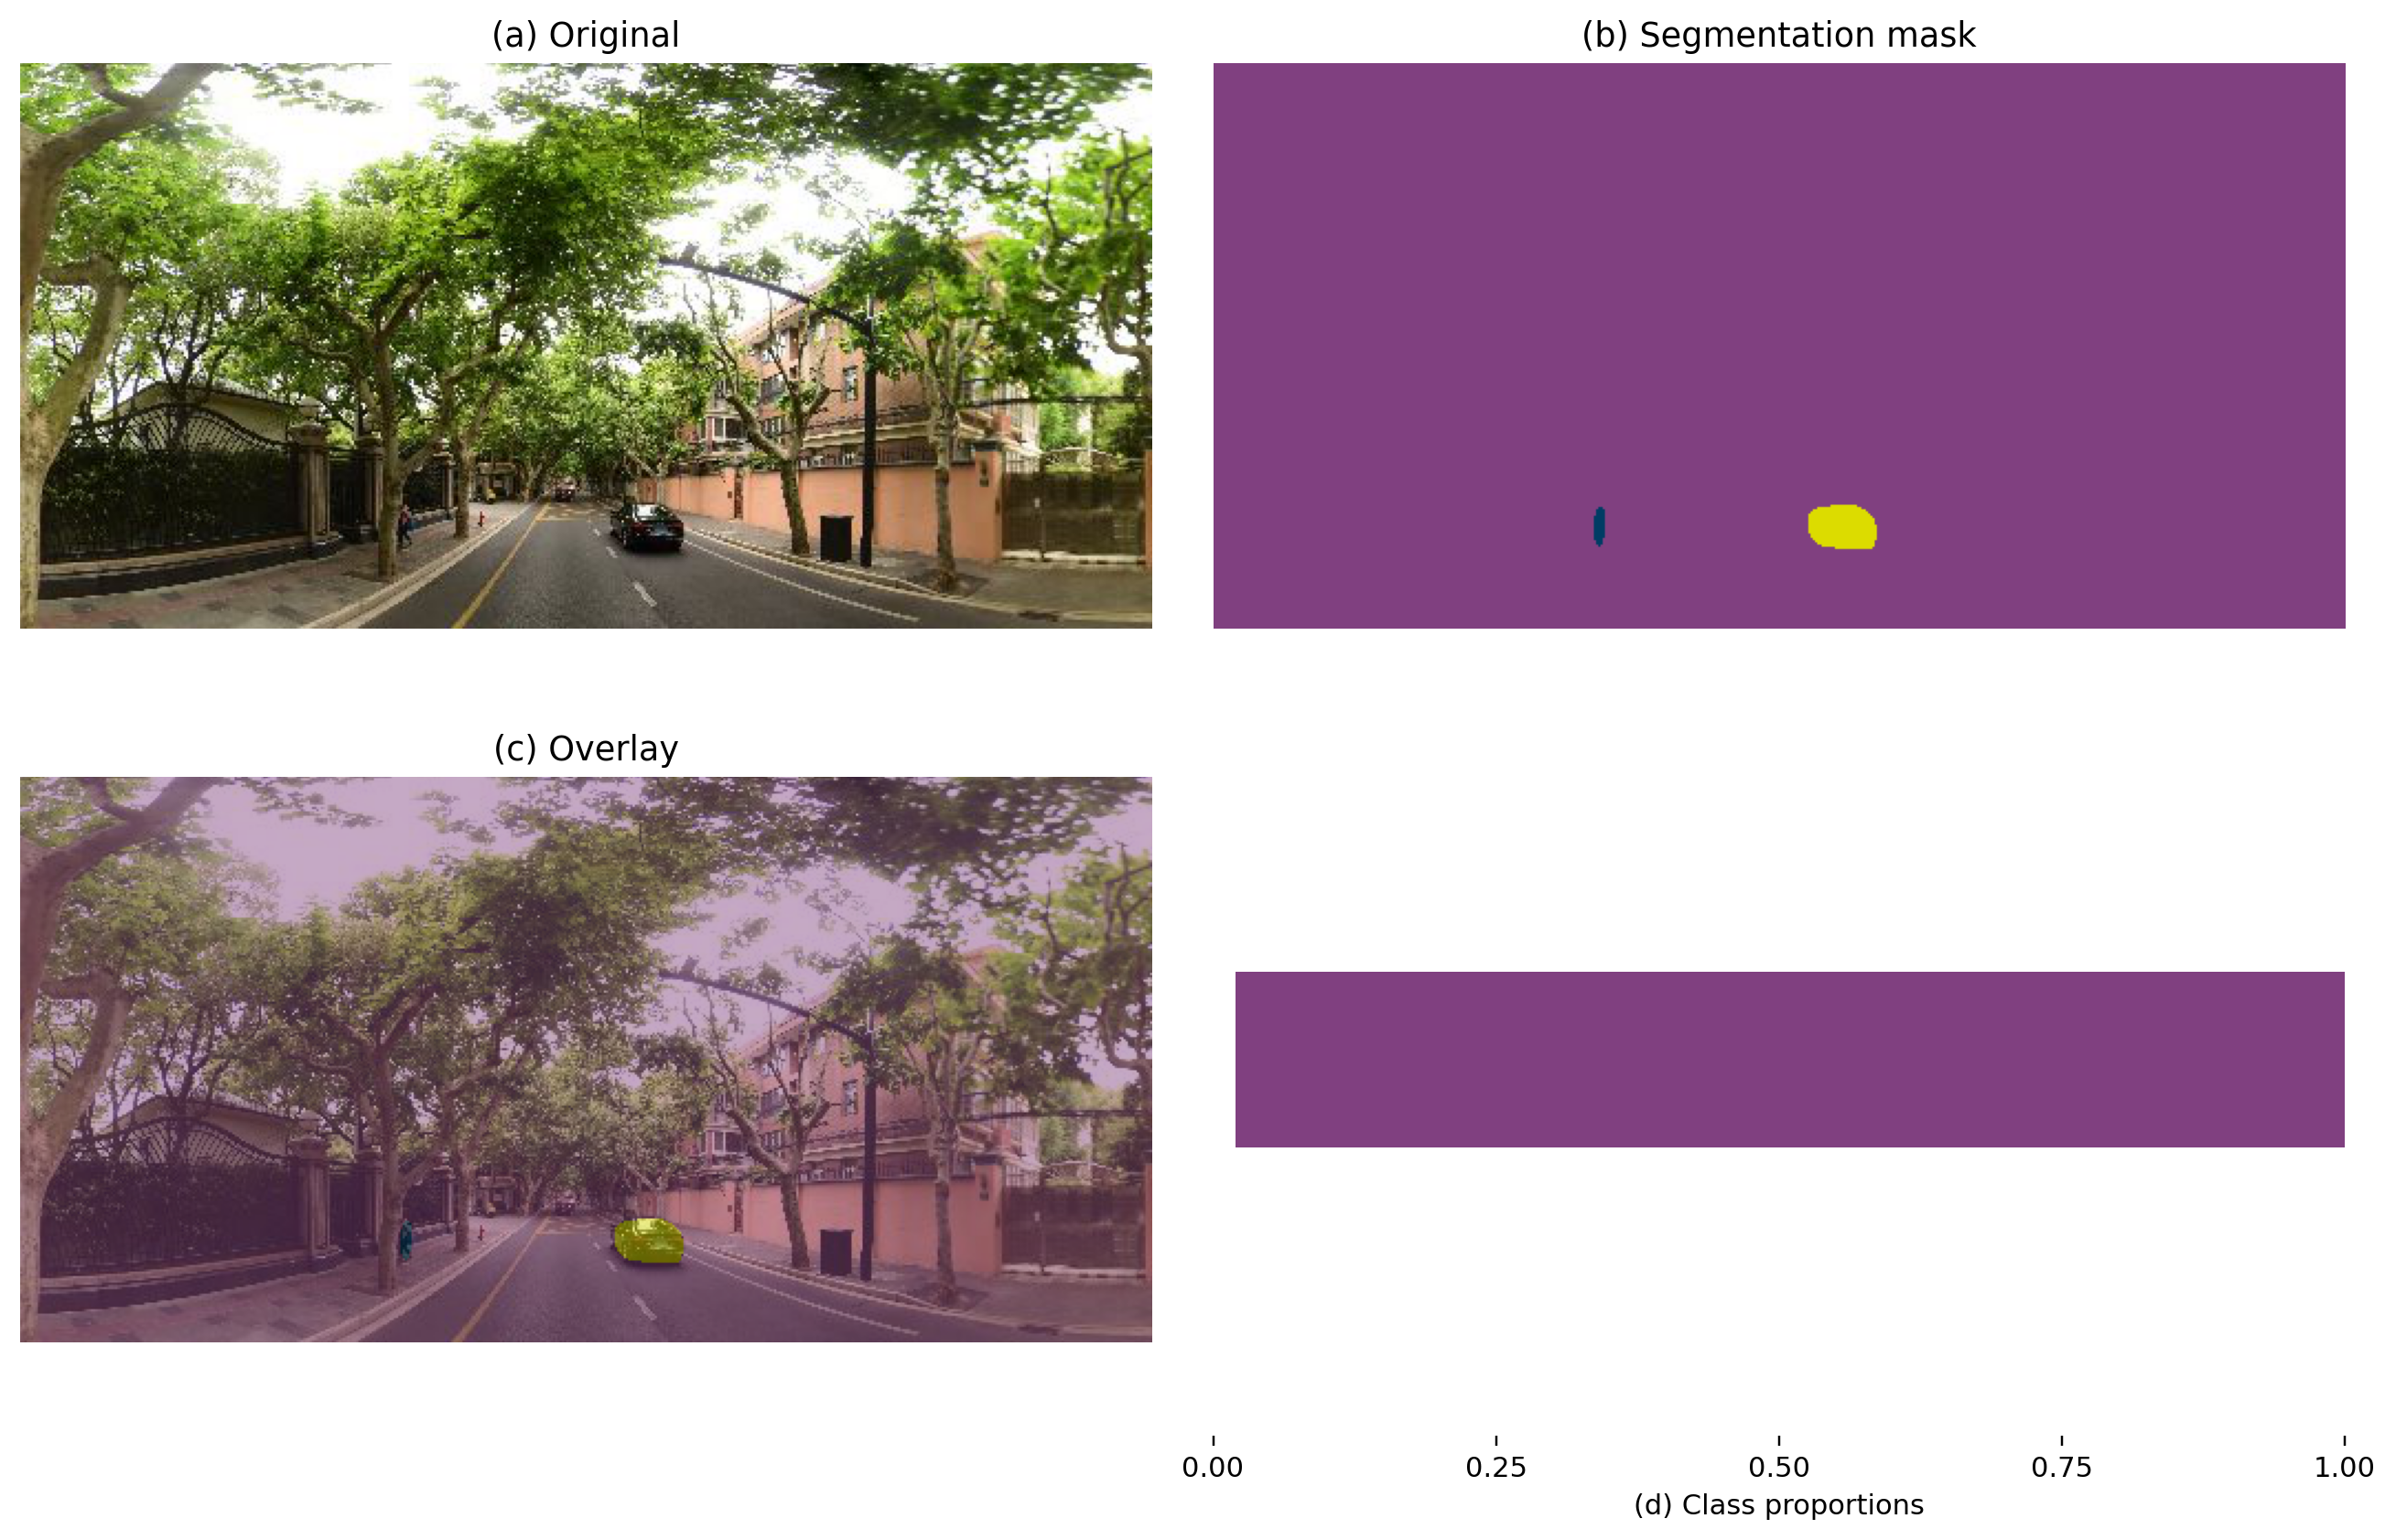

In [7]:
# -*- coding: utf-8 -*-
"""
Cityscapes semantic segmentation 2x2 panel:
(a) Original  (b) Mask  (c) Overlay  (d) Class-proportion bar

Priority: TensorFlow SavedModel (Panoptic/DeepLab, Cityscapes)
Fallback: torchvision DeepLabv3-ResNet50 (COCO/VOC-ish; for visualization only)
"""

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ========= 路径（按需修改） =========
MODEL_DIR  = "/Users/sillyfish/Desktop/dissertation/DATA/resnet50_beta_os32_panoptic_deeplab_cityscapes_trainfine_saved_model"
IMAGE_PATH = "/Users/sillyfish/Desktop/dissertation/DATA/00215.png"
OUT_PNG    = "/Users/sillyfish/Desktop/dissertation/OUTPUTS/seg_panel_cityscapes.png"
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)
# =================================

# Cityscapes 常用 19 类调色板（RGB）
PALETTE = np.array([
    [128,  64, 128],  # road
    [244,  35, 232],  # sidewalk
    [ 70,  70,  70],  # building
    [102, 102, 156],  # wall
    [190, 153, 153],  # fence
    [153, 153, 153],  # pole
    [250, 170,  30],  # traffic light
    [220, 220,   0],  # traffic sign
    [107, 142,  35],  # vegetation
    [152, 251, 152],  # terrain
    [ 70, 130, 180],  # sky
    [220,  20,  60],  # person
    [255,   0,   0],  # rider
    [  0,   0, 142],  # car
    [  0,   0,  70],  # truck
    [  0,  60, 100],  # bus
    [  0,  80, 100],  # train
    [  0,   0, 230],  # motorcycle
    [119,  11,  32],  # bicycle
], dtype=np.uint8)
NCLS = PALETTE.shape[0]
NAMES = [
    "road","sidewalk","building","wall","fence","pole",
    "traffic light","traffic sign","vegetation","terrain","sky",
    "person","rider","car","truck","bus","train","motorcycle","bicycle"
]

def pad_to_multiple(img_np, multiple=32, value=0):
    """Pad H,W 到 multiple 的倍数（适配 OS=32 的模型）"""
    h, w = img_np.shape[:2]
    nh = (h + multiple - 1) // multiple * multiple
    nw = (w + multiple - 1) // multiple * multiple
    pad = np.ones((nh, nw, 3), dtype=img_np.dtype) * value
    pad[:h, :w] = img_np
    return pad, (h, w)

def crop_back(arr, orig_hw):
    """从 padding 尺寸裁回原尺寸"""
    h, w = orig_hw
    return arr[:h, :w]

def colorize(label):
    """label(H,W)->彩色掩膜(H,W,3)"""
    color = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    u = np.unique(label)
    for k in u:
        if k < 0: continue
        color[label == k] = PALETTE[k % NCLS]
    return color

def proportions(label):
    """返回每一类的像素占比"""
    hist = np.bincount(np.clip(label, 0, NCLS-1).ravel(), minlength=NCLS).astype(float)
    return hist / (hist.sum() + 1e-9)

# ========= 1) TensorFlow SavedModel 推理（优先） =========
def infer_tf_saved_model(model_dir, image_np):
    try:
        import tensorflow as tf

        img_pad, orig_hw = pad_to_multiple(image_np, 32, 0)

        # 两种常见输入规范：uint8[0,255] 或 float32[0,1]
        candidates = [
            tf.convert_to_tensor(img_pad[None, ...], dtype=tf.uint8),
            tf.convert_to_tensor(img_pad[None, ...] / 255.0, dtype=tf.float32),
        ]

        model = tf.saved_model.load(model_dir)
        sigs = list(model.signatures.keys())
        fn  = model.signatures.get("serving_default", None) or model.signatures[sigs[0]]

        out = None
        for inp in candidates:
            try:
                try:
                    out = fn(inp)
                except Exception:
                    try:
                        out = fn(image=inp)
                    except Exception:
                        out = fn(images=inp)
                break
            except Exception:
                continue
        if out is None:
            return None

        # 常见输出键（语义/全景）
        keys = ["semantic", "semantic_pred", "segmentation", "category_mask", "panoptic_pred"]
        y = None
        for k in keys:
            if k in out:
                y = out[k]
                break
        if y is None:
            y = list(out.values())[0]

        y = y[0].numpy()
        # 兼容 [H,W,1]、[H,W,C(logits)]、[H,W,2](sem,inst) 等
        if y.ndim == 3:
            if y.shape[-1] == 1:
                y = y[..., 0]
            elif y.shape[-1] <= 8:
                y = y[..., 0]
            else:
                y = y.argmax(-1)

        y = y.astype(np.int32)
        y = crop_back(y, orig_hw)
        return y
    except Exception as e:
        print(f"[TF SavedModel] failed: {e}")
        return None

# ========= 2) 备用：torchvision DeepLabV3（COCO/VOC 类；仅为出图兜底） =========
def infer_torch(image_np):
    try:
        import torch
        from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

        img_pil = Image.fromarray(image_np)
        weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
        model = deeplabv3_resnet50(weights=weights).eval()
        trf = weights.transforms()
        inp = trf(img_pil).unsqueeze(0)

        with torch.no_grad():
            out = model(inp)["out"][0]        # [C,H,W]
            lab = out.argmax(0).cpu().numpy().astype(np.int32)
        return lab
    except Exception as e:
        print(f"[Torch] failed: {e}")
        return None

def main():
    # 读图
    img = Image.open(IMAGE_PATH).convert("RGB")
    img_np = np.array(img)

    # 推理（优先 TF SavedModel）
    label = None
    if os.path.isdir(MODEL_DIR):
        label = infer_tf_saved_model(MODEL_DIR, img_np)
    if label is None:
        print("Falling back to torchvision DeepLabV3 (COCO/VOC)…")
        label = infer_torch(img_np)
        if label is None:
            raise RuntimeError("Both SavedModel and Torch inference failed.")

    # 可视化：mask + overlay + 类别比例条
    mask_rgb = colorize(label)

    # —— 确保尺寸一致再叠加（修复 Image.blend 报错）——
    H, W = img_np.shape[:2]
    mask_rgb_resized = Image.fromarray(mask_rgb).resize((W, H), resample=Image.NEAREST)
    img_pil_rgba  = Image.fromarray(img_np).convert("RGBA")
    mask_pil_rgba = mask_rgb_resized.convert("RGBA")
    overlay = Image.blend(img_pil_rgba, mask_pil_rgba, alpha=0.45)

    # 类别占比
    p = proportions(label)
    topk = np.argsort(-p)[:6]
    print("Top classes:", [(NAMES[i] if i < len(NAMES) else i, float(p[i])) for i in topk if p[i] > 0])

    # 2×2 面板
    fig = plt.figure(figsize=(12, 8), dpi=220)
    gs  = fig.add_gridspec(2, 2, height_ratios=[1,1])

    ax1 = fig.add_subplot(gs[0,0]); ax1.imshow(img_np);               ax1.set_title("(a) Original");          ax1.axis("off")
    ax2 = fig.add_subplot(gs[0,1]); ax2.imshow(mask_rgb_resized);     ax2.set_title("(b) Segmentation mask"); ax2.axis("off")
    ax3 = fig.add_subplot(gs[1,0]); ax3.imshow(overlay);              ax3.set_title("(c) Overlay");           ax3.axis("off")

    ax4 = fig.add_subplot(gs[1,1])
    left = 0.02
    for i, pi in enumerate(p):
        if pi <= 0: continue
        ax4.barh(0, pi, left=left, color=PALETTE[i % NCLS]/255.0, edgecolor="none", height=0.28)
        left += pi
    ax4.set_xlim(0, 1); ax4.set_ylim(-0.6, 0.6); ax4.set_yticks([])
    ax4.set_xticks([0,0.25,0.5,0.75,1.0])
    ax4.set_xlabel("(d) Class proportions")
    for spine in ["top","right","left","bottom"]:
        ax4.spines[spine].set_visible(False)

    plt.tight_layout()
    fig.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
    print(f"Saved: {OUT_PNG}")
    plt.show()

if __name__ == "__main__":
    main()


In [9]:
# -*- coding: utf-8 -*-
# 作用：读取 EHB 的 VIIRS 指标，导出投稿级 PNG 图与一个 tidy CSV
# 依赖：pandas, numpy, matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= 配置 =========
INPUT_CSV = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_viirs_mean1km.csv"  # ← 改成你的路径
OUT_DIR   = "./viirs_figs"  # 输出目录（可改）
os.makedirs(OUT_DIR, exist_ok=True)

# ========= 读取与清洗 =========
df = pd.read_csv(INPUT_CSV)
df.columns = [c.strip().lower() for c in df.columns]

needed = ["name","address","lon_wgs84","lat_wgs84","viirs_mean_1km","pixels_used"]
miss = [c for c in needed if c not in df.columns]
if miss:
    raise ValueError(f"缺少列: {miss}；实际列：{list(df.columns)}")

for c in ["lon_wgs84","lat_wgs84","viirs_mean_1km","pixels_used"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=["lon_wgs84","lat_wgs84","viirs_mean_1km"]).copy()

# 基本派生：排名 + z-score
df["viirs_rank_desc"] = df["viirs_mean_1km"].rank(ascending=False, method="min").astype(int)
mean_v = df["viirs_mean_1km"].mean()
std_v  = df["viirs_mean_1km"].std(ddof=0)
df["viirs_zscore"] = (df["viirs_mean_1km"] - mean_v) / (std_v if std_v != 0 else np.nan)

# 保存整理版
tidy_csv = os.path.join(OUT_DIR, "ehb_viirs_tidy.csv")
df.to_csv(tidy_csv, index=False)

# ========= 图 1：直方图 =========
plt.figure()
plt.hist(df["viirs_mean_1km"].dropna().values, bins=30)
plt.title("Distribution of EHB VIIRS Mean (1 km)")
plt.xlabel("VIIRS mean (1 km)")
plt.ylabel("Number of EHBs")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fig_hist_viirs_mean.png"), dpi=300)
plt.close()

# ========= 图 2：ECDF =========
vals = np.sort(df["viirs_mean_1km"].dropna().values)
y = np.arange(1, len(vals)+1) / len(vals)
plt.figure()
plt.plot(vals, y, linewidth=1.5)
plt.title("Empirical CDF of EHB VIIRS Mean (1 km)")
plt.xlabel("VIIRS mean (1 km)")
plt.ylabel("Cumulative share of EHBs")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fig_ecdf_viirs_mean.png"), dpi=300)
plt.close()

# ========= 图 3：Top-20 条形图 =========
top20 = df.sort_values("viirs_mean_1km", ascending=False).head(20).copy()
plt.figure(figsize=(8, max(4, 0.3*len(top20))))
labels0 = top20["name"] + " (" + top20["address"] + ")"
labels = labels0.str.slice(0, 50) + np.where(labels0.str.len() > 50, "...", "")
plt.barh(range(len(top20)), top20["viirs_mean_1km"].values)
plt.yticks(range(len(top20)), labels)
plt.gca().invert_yaxis()
plt.xlabel("VIIRS mean (1 km)")
plt.title("Top 20 EHBs by VIIRS Mean (1 km)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fig_barh_top20_viirs.png"), dpi=300)
plt.close()

# ========= 图 4：空间散点（点大小 ∝ VIIRS） =========
plt.figure()
sizes = 20 + 80 * (df["viirs_mean_1km"] - df["viirs_mean_1km"].min()) / (df["viirs_mean_1km"].max() - df["viirs_mean_1km"].min() + 1e-9)
plt.scatter(df["lon_wgs84"], df["lat_wgs84"], s=sizes, alpha=0.7)
plt.title("EHB Points (size ~ VIIRS mean (1 km))")
plt.xlabel("Longitude (WGS84)")
plt.ylabel("Latitude (WGS84)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fig_scatter_lonlat_size_by_viirs.png"), dpi=300)
plt.close()

# ========= 图 5：Hexbin（均值聚合） =========
plt.figure()
hb = plt.hexbin(
    df["lon_wgs84"].values,
    df["lat_wgs84"].values,
    C=df["viirs_mean_1km"].values,
    reduce_C_function=np.mean,
    gridsize=40,
    mincnt=1
)
plt.colorbar(hb, label="Mean VIIRS (1 km)")
plt.title("Hexbin of EHB Locations by Mean VIIRS")
plt.xlabel("Longitude (WGS84)")
plt.ylabel("Latitude (WGS84)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fig_hexbin_viirs_mean.png"), dpi=300)
plt.close()

# ========= 图 6：像元数量 vs VIIRS 均值 =========
plt.figure()
plt.scatter(df["pixels_used"].values, df["viirs_mean_1km"].values, alpha=0.7)
plt.xlabel("Pixels used")
plt.ylabel("VIIRS mean (1 km)")
plt.title("Pixels Used vs VIIRS Mean (1 km)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fig_scatter_pixels_vs_viirs.png"), dpi=300)
plt.close()

print("完成。输出目录：", OUT_DIR)
print("整理版 CSV：", tidy_csv)


/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/4269977359.py:70: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/4269977359.py:70: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/4269977359.py:70: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/4269977359.py:70: UserWarning: Glyph 27004 (\N{CJK UNIFIED IDEOGRAPH-697C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/4269977359.py:70: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0

完成。输出目录： ./viirs_figs
整理版 CSV： ./viirs_figs/ehb_viirs_tidy.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取你的数据
df = pd.read_csv("/Users/sillyfish/Desktop/dissertation/DATA/ehb_viirs_mean1km.csv")
HIST_BLUE = "#87CEEB"  # 与 POI 图一致


plt.figure(figsize=(8,6))
plt.hist(viirs_mean, bins=30, color=HIST_BLUE, edgecolor="black")  # 仅此处改色
plt.title("Distribution of EHB VIIRS Mean (1 km)")
plt.xlabel("VIIRS mean (1 km)")
plt.ylabel("Number of EHBs")
plt.tight_layout()
plt.show()


NameError: name 'viirs_mean' is not defined

<Figure size 800x600 with 0 Axes>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 输入/输出路径
INPUT_CSV = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_viirs_mean1km.csv"
OUT_PNG   = "/Users/sillyfish/Desktop/dissertation/DATA/fig_hist_viirs_mean.png"

# 读取数据
df = pd.read_csv(INPUT_CSV)

# 绘制直方图（柱子带边框，统一为 skyblue）
plt.figure(figsize=(8, 6))
plt.hist(
    df["viirs_mean_1km"],
    bins=30,
    color="skyblue",     # 与 POI 图一致
    edgecolor="black",
    linewidth=0.8
)
plt.title("Distribution of EHB VIIRS Mean (1 km)")
plt.xlabel("VIIRS mean (1 km)")
plt.ylabel("Number of EHBs")
plt.tight_layout()

# 保存 PNG
plt.savefig(OUT_PNG, dpi=300)
plt.close()
print("输出完成，文件已保存：", OUT_PNG)


输出完成，文件已保存： /Users/sillyfish/Desktop/dissertation/DATA/fig_hist_viirs_mean.png


/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/31727290.py:25: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/31727290.py:25: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/31727290.py:25: UserWarning: Glyph 31199 (\N{CJK UNIFIED IDEOGRAPH-79DF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/31727290.py:25: UserWarning: Glyph 30028 (\N{CJK UNIFIED IDEOGRAPH-754C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/31727290.py:25: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_

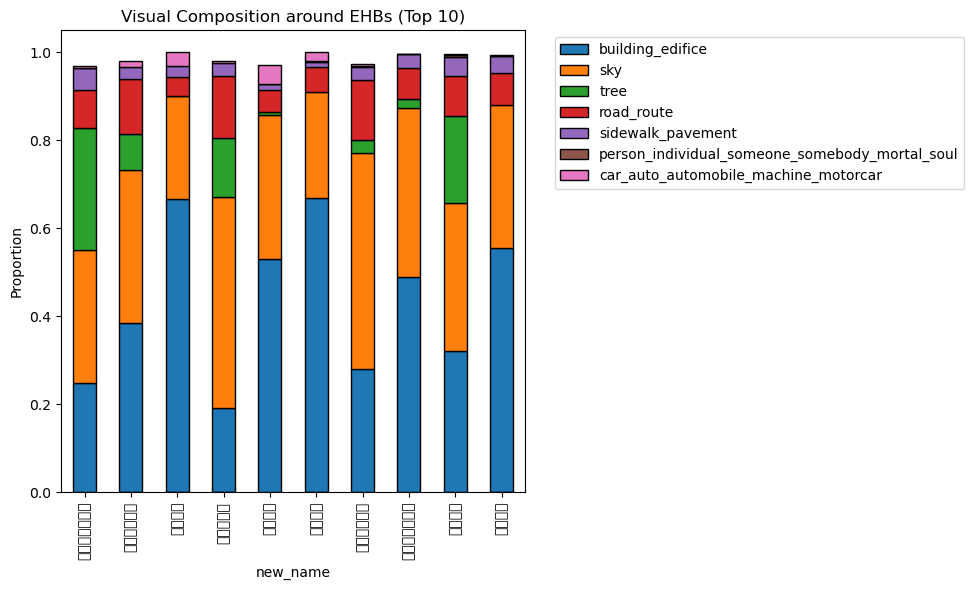

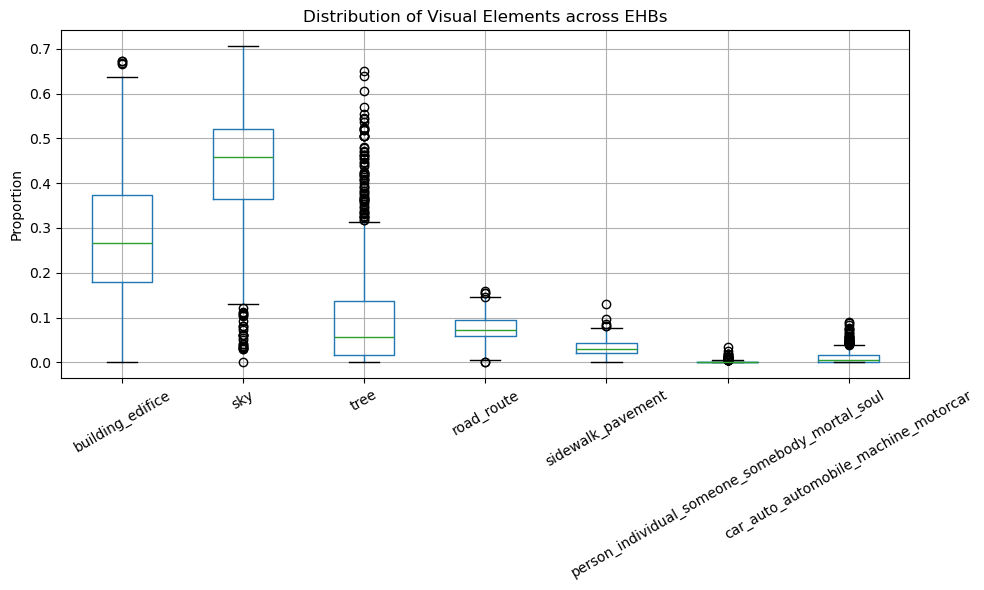

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 路径
FILE = "/Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged_aligned.xlsx"
df = pd.read_excel(FILE)

# 语义类别列
cols = [
    "building_edifice", "sky", "tree", "road_route",
    "sidewalk_pavement", "person_individual_someone_somebody_mortal_soul",
    "car_auto_automobile_machine_motorcar"
]

# ========== 方案 1：堆叠柱状图 ==========
df_plot = df[cols].head(10)  # 先取前10个示例建筑，否则太多
df_plot.index = df["new_name"].head(10)  # 横轴标签 = 建筑名

ax = df_plot.plot(
    kind="bar", stacked=True, figsize=(10,6), edgecolor="black"
)
plt.title("Visual Composition around EHBs (Top 10)")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ========== 方案 3：箱线图 ==========
plt.figure(figsize=(10,6))
df[cols].boxplot()
plt.title("Distribution of Visual Elements across EHBs")
plt.ylabel("Proportion")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [17]:
# -*- coding: utf-8 -*-
"""
生成“方案 1：堆叠柱状图（Top 10）”，并把图与前10条整理表保存到 DATA 文件夹。
输入：/Users/sillyfish/Desktop/dissertation/DATA/ehb_master_merged_aligned.xlsx
输出图：fig_stackedbar_visual_elements.png
输出表：ehb_top10_visual_elements.csv
"""

import os
import pandas as pd
import matplotlib.pyplot as plt

# ========== 路径 ==========
DATA_DIR = "/Users/sillyfish/Desktop/dissertation/DATA"
INPUT_XLSX = os.path.join(DATA_DIR, "ehb_master_merged_aligned.xlsx")
OUT_PNG   = os.path.join(DATA_DIR, "fig_stackedbar_visual_elements.png")
OUT_CSV   = os.path.join(DATA_DIR, "ehb_top10_visual_elements.csv")

# ========== 读取 ==========
# 需要 openpyxl: pip install openpyxl
df = pd.read_excel(INPUT_XLSX)  # 默认读首个工作表

# ========== 语义类别列（按你给的列名）==========
COLUMNS = [
    "building_edifice",
    "sky",
    "tree",
    "road_route",
    "sidewalk_pavement",
    "person_individual_someone_somebody_mortal_soul",
    "car_auto_automobile_machine_motorcar",
]

# 基础字段（用于索引/展示）
ID_COL = "id"
NAME_COL = "new_name"

# 列检查（避免列名错或缺失导致报错）
missing = [c for c in [ID_COL, NAME_COL] + COLUMNS if c not in df.columns]
if missing:
    raise ValueError(f"缺少以下列，请在 Excel 中检查列名是否一致：{missing}")

# 只保留需要的列，避免乱七八糟类型
df = df[[ID_COL, NAME_COL] + COLUMNS].copy()

# ========== 选取前 10 个示例 ==========
# 默认为“表中前10行”；如需换成某种排序（如 building_edifice 降序），改这里：
# df_top10 = df.sort_values("building_edifice", ascending=False).head(10).copy()
df_top10 = df.head(10).copy()

# 保存“前10条整理表”
df_top10.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

# ========== 画堆叠柱状图 ==========
# 横轴标签：使用 new_name；如含中文，为避免字体问题尽量使用英文字体/或自行配置系统字体
# 如果你系统已安装中文字体，下面这两行可选：
plt.rcParams["axes.unicode_minus"] = False
# plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "SimHei", "Noto Sans CJK SC"]

# 数据框：把语义列作为 Y 值，索引作为横轴标签
df_plot = df_top10.set_index(NAME_COL)[COLUMNS]

ax = df_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    edgecolor="black",     # 每段加边框
    linewidth=0.6
)

plt.title("Visual Composition around EHBs (Top 10)")
plt.ylabel("Proportion (0–1)")
plt.xlabel("EHB")
plt.xticks(rotation=25, ha="right")
plt.legend(title="Semantic Elements", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()

print("✅ 已输出：")
print("图：", OUT_PNG)
print("表：", OUT_CSV)


/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/3758829023.py:76: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/3758829023.py:76: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/3758829023.py:76: UserWarning: Glyph 31199 (\N{CJK UNIFIED IDEOGRAPH-79DF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/3758829023.py:76: UserWarning: Glyph 30028 (\N{CJK UNIFIED IDEOGRAPH-754C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/3758829023.py:76: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0

✅ 已输出：
图： /Users/sillyfish/Desktop/dissertation/DATA/fig_stackedbar_visual_elements.png
表： /Users/sillyfish/Desktop/dissertation/DATA/ehb_top10_visual_elements.csv


In [19]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/Users/sillyfish/Desktop/dissertation/DATA"
INPUT_XLSX = os.path.join(DATA_DIR, "ehb_master_merged_aligned.xlsx")
OUT_PNG   = os.path.join(DATA_DIR, "fig_stackedbar_visual_elements_en.png")
OUT_CSV   = os.path.join(DATA_DIR, "ehb_top10_visual_elements_en.csv")
OUT_MAP   = os.path.join(DATA_DIR, "ehb_top10_name_mapping.csv")

df = pd.read_excel(INPUT_XLSX)

COLUMNS = [
    "building_edifice", "sky", "tree", "road_route",
    "sidewalk_pavement", "person_individual_someone_somebody_mortal_soul",
    "car_auto_automobile_machine_motorcar"
]

# 建筑中文名列
ID_COL = "id"
NAME_COL = "new_name"

# 选前 10 个（如果想按某字段排序后取Top10，可改成：df.sort_values("viirs_mean_1km", ascending=False).head(10)）
df_top10 = df[[ID_COL, NAME_COL] + COLUMNS].head(10).copy()

# ——前10样例：中英文对照表——
translations = {
    "公共租界工部局": "Shanghai Municipal Council Building (Old City Hall)",
    "大上海大戏院": "Grand Shanghai Theater",
    "沙逊大厦": "Sassoon House (Peace Hotel North Building)",
    "亚西亚大楼": "Asia Building (China Pacific Insurance / Shanghai Bank)",
    "上海海关": "Shanghai Customs House",
    "和平饭店南楼": "Peace Hotel South Building",
    "东风饭店": "Dongfeng Hotel",
    "浦东发展银行": "Pudong Development Bank Building (Former HSBC Building)",
    "南京大楼": "Nissin Building (Former Jardine Matheson Building)",
    "外滩源建筑群": "Bund Origin Architectural Complex",
}

# 如果 new_name 含有括号等附加说明，也能匹配（尽量宽容匹配）
def translate_name(cn):
    if pd.isna(cn):
        return cn
    cn_str = str(cn)
    # 先精确匹配
    if cn_str in translations:
        return translations[cn_str]
    # 再尝试包含匹配（如 “沙逊大厦（和平饭店北楼）” 应映射到“沙逊大厦”）
    for k, v in translations.items():
        if k in cn_str:
            return v
    # 找不到就保留原文，避免空白
    return cn_str

# 增加英文列
df_top10["name_en"] = df_top10[NAME_COL].apply(translate_name)

# ——保存两份CSV：带英文列的数据表 + 中英文对照表——
df_top10.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

name_map = (
    df_top10[[NAME_COL, "name_en"]]
    .drop_duplicates()
    .rename(columns={NAME_COL: "name_cn"})
)
name_map.to_csv(OUT_MAP, index=False, encoding="utf-8-sig")

# ——画堆叠柱状图（英文标签）——
# 如需中文字体可启用下行（系统需安装相应字体）
plt.rcParams["axes.unicode_minus"] = False
# plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "SimHei", "Noto Sans CJK SC"]

df_plot = df_top10.set_index("name_en")[COLUMNS]
ax = df_plot.plot(
    kind="bar", stacked=True, figsize=(12, 6),
    edgecolor="black", linewidth=0.6
)
plt.title("Visual Composition around EHBs (Top 10)")
plt.ylabel("Proportion (0–1)")
plt.xlabel("EHB")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Semantic Elements", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()

print("✅ 已输出：")
print("图：", OUT_PNG)
print("表：", OUT_CSV)
print("对照表：", OUT_MAP)


/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/2988829934.py:84: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/2988829934.py:84: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/2988829934.py:84: UserWarning: Glyph 38134 (\N{CJK UNIFIED IDEOGRAPH-94F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/2988829934.py:84: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/2988829934.py:84: UserWarning: Glyph 24609 (\N{CJK UNIFIED IDEOGRAPH-6021}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0

✅ 已输出：
图： /Users/sillyfish/Desktop/dissertation/DATA/fig_stackedbar_visual_elements_en.png
表： /Users/sillyfish/Desktop/dissertation/DATA/ehb_top10_visual_elements_en.csv
对照表： /Users/sillyfish/Desktop/dissertation/DATA/ehb_top10_name_mapping.csv


In [21]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/Users/sillyfish/Desktop/dissertation/DATA"
INPUT_XLSX = os.path.join(DATA_DIR, "ehb_master_merged_aligned.xlsx")
OUT_PNG   = os.path.join(DATA_DIR, "fig_stackedbar_visual_elements_en.png")
OUT_CSV   = os.path.join(DATA_DIR, "ehb_top10_visual_elements_en.csv")
OUT_MAP   = os.path.join(DATA_DIR, "ehb_top10_name_mapping.csv")

df = pd.read_excel(INPUT_XLSX)

COLUMNS = [
    "building_edifice", "sky", "tree", "road_route",
    "sidewalk_pavement", "person_individual_someone_somebody_mortal_soul",
    "car_auto_automobile_machine_motorcar"
]

# 建筑中文名列
ID_COL = "id"
NAME_COL = "new_name"

# 选前 10 个（如果想按某字段排序后取Top10，可改成：df.sort_values("viirs_mean_1km", ascending=False).head(10)）
df_top10 = df[[ID_COL, NAME_COL] + COLUMNS].head(10).copy()

# ——前10样例：中英文对照表——
translations = {
    "公共租界工部局": "1A024",
    "大上海大戏院": "1A023",
    "沙逊大厦": "1A006",
    "亚西亚大楼": "1A001",
    "上海海关": "1A004",
    "和平饭店南楼": "1A005",
    "东风饭店": "1A002",
    "浦东发展银行": "1A003",
    "南京大楼": "1A002",
    "外滩源建筑群": "1C002",
}

# 如果 new_name 含有括号等附加说明，也能匹配（尽量宽容匹配）
def translate_name(cn):
    if pd.isna(cn):
        return cn
    cn_str = str(cn)
    # 先精确匹配
    if cn_str in translations:
        return translations[cn_str]
    # 再尝试包含匹配（如 “沙逊大厦（和平饭店北楼）” 应映射到“沙逊大厦”）
    for k, v in translations.items():
        if k in cn_str:
            return v
    # 找不到就保留原文，避免空白
    return cn_str

# 增加英文列
df_top10["name_en"] = df_top10[NAME_COL].apply(translate_name)

# ——保存两份CSV：带英文列的数据表 + 中英文对照表——
df_top10.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

name_map = (
    df_top10[[NAME_COL, "name_en"]]
    .drop_duplicates()
    .rename(columns={NAME_COL: "name_cn"})
)
name_map.to_csv(OUT_MAP, index=False, encoding="utf-8-sig")

# ——画堆叠柱状图（英文标签）——
# 如需中文字体可启用下行（系统需安装相应字体）
plt.rcParams["axes.unicode_minus"] = False
# plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "SimHei", "Noto Sans CJK SC"]

df_plot = df_top10.set_index("name_en")[COLUMNS]
ax = df_plot.plot(
    kind="bar", stacked=True, figsize=(12, 6),
    edgecolor="black", linewidth=0.6
)
plt.title("Visual Composition around EHBs (Top 10)")
plt.ylabel("Proportion (0–1)")
plt.xlabel("EHB")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Semantic Elements", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()

print("✅ 已输出：")
print("图：", OUT_PNG)
print("表：", OUT_CSV)
print("对照表：", OUT_MAP)


/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/1896990932.py:84: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/1896990932.py:84: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/1896990932.py:84: UserWarning: Glyph 38134 (\N{CJK UNIFIED IDEOGRAPH-94F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/1896990932.py:84: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0xs3t3n5y0_ghv6c0000gn/T/ipykernel_7771/1896990932.py:84: UserWarning: Glyph 24609 (\N{CJK UNIFIED IDEOGRAPH-6021}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/10/vz6mvxqd0

✅ 已输出：
图： /Users/sillyfish/Desktop/dissertation/DATA/fig_stackedbar_visual_elements_en.png
表： /Users/sillyfish/Desktop/dissertation/DATA/ehb_top10_visual_elements_en.csv
对照表： /Users/sillyfish/Desktop/dissertation/DATA/ehb_top10_name_mapping.csv


In [23]:
# -*- coding: utf-8 -*-
import os
import pandas as pd

DATA_DIR   = "/Users/sillyfish/Desktop/dissertation/DATA"
INPUT_XLSX = os.path.join(DATA_DIR, "ehb_master_merged_aligned.xlsx")
OUT_CSV    = os.path.join(DATA_DIR, "ehb_top10_names_check.csv")

# 读取（默认第一个工作表）
df = pd.read_excel(INPUT_XLSX)

# 保留需要的两列；做下清洗（去空白字符）
if "id" not in df.columns or "new_name" not in df.columns:
    raise ValueError("Excel中缺少必须列：id 或 new_name，请检查表头。")

df["id"] = df["id"].astype(str).str.strip()
df["new_name"] = df["new_name"].astype(str).str.strip()

# 取前10条（如果你想按某字段排序后取Top10，把下一行替换为：df.sort_values('某字段', ascending=False).head(10)）
top10 = df.loc[:, ["id", "new_name"]].head(10).copy()

# 打印到终端
print("=== 前10个建筑（id, new_name）===")
for i, row in top10.iterrows():
    print(f"{row['id']}\t{row['new_name']}")

# 保存到CSV
top10.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("\n✅ 已保存对照表：", OUT_CSV)


=== 前10个建筑（id, new_name）===
1A024	公共租界工部局
1A023	大上海大戏院
1A006	沙逊大厦
1A001	亚西亚大楼
1A007	中国银行
1A008	怡和银行
1A027(IE001)	董家渡天主堂
1A025	圣三一基督教堂
1A026	金城银行
2A020	广学大楼

✅ 已保存对照表： /Users/sillyfish/Desktop/dissertation/DATA/ehb_top10_names_check.csv


In [25]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt

# 路径
DATA_DIR = "/Users/sillyfish/Desktop/dissertation/DATA"
INPUT_XLSX = os.path.join(DATA_DIR, "ehb_master_merged_aligned.xlsx")
OUT_PNG   = os.path.join(DATA_DIR, "fig_stackedbar_visual_elements_id.png")
OUT_CSV   = os.path.join(DATA_DIR, "ehb_top10_visual_elements_id.csv")

# 1) 读取数据
df = pd.read_excel(INPUT_XLSX)

# 2) 需要的列
COLUMNS = [
    "building_edifice","sky","tree","road_route",
    "sidewalk_pavement","person_individual_someone_somebody_mortal_soul",
    "car_auto_automobile_machine_motorcar"
]
ID_COL   = "id"

# 3) 取前10个
df_top10 = df[[ID_COL] + COLUMNS].head(10).copy()

# 4) 保存整理表
df_top10.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

# 5) 明确用 id 作为横轴标签
values = df_top10[COLUMNS].fillna(0).to_numpy()
labels = df_top10[ID_COL].astype(str).tolist()
x = range(len(labels))

fig, ax = plt.subplots(figsize=(14,6))
bottom = [0.0]*len(labels)

for col in COLUMNS:
    heights = df_top10[col].fillna(0).to_numpy()
    ax.bar(x, heights, bottom=bottom, edgecolor="black", linewidth=0.6, label=col)
    bottom = (pd.Series(bottom) + pd.Series(heights)).to_numpy()

ax.set_title("Visual Composition around EHBs (Top 10)")
ax.set_ylabel("Proportion (0–1)")
ax.set_xlabel("EHB ID")
ax.set_xticks(list(x))
ax.set_xticklabels(labels, rotation=0)  # 横轴直接显示 ID，不旋转
ax.legend(title="Semantic Elements", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()

print("✅ 已输出：")
print("图：", OUT_PNG)
print("表：", OUT_CSV)


✅ 已输出：
图： /Users/sillyfish/Desktop/dissertation/DATA/fig_stackedbar_visual_elements_id.png
表： /Users/sillyfish/Desktop/dissertation/DATA/ehb_top10_visual_elements_id.csv


In [27]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/Users/sillyfish/Desktop/dissertation/DATA"
INPUT_XLSX = os.path.join(DATA_DIR, "ehb_master_merged_aligned.xlsx")
OUT_PNG   = os.path.join(DATA_DIR, "fig_stackedbar_visual_elements_id_customcolor.png")
OUT_CSV   = os.path.join(DATA_DIR, "ehb_top10_visual_elements_id.csv")

df = pd.read_excel(INPUT_XLSX)

COLUMNS = [
    "building_edifice","sky","tree","road_route",
    "sidewalk_pavement","person_individual_someone_somebody_mortal_soul",
    "car_auto_automobile_machine_motorcar"
]
ID_COL   = "id"

df_top10 = df[[ID_COL] + COLUMNS].head(10).copy()
df_top10.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

# 设置颜色映射（只给 sky 指定浅蓝色，其他随便挑或保持默认）
colors = {
    "building_edifice": "#1f77b4",  # 蓝
    "sky": "lightblue",             # 浅蓝色
    "tree": "#2ca02c",              # 绿
    "road_route": "#d62728",        # 红
    "sidewalk_pavement": "#9467bd", # 紫
    "person_individual_someone_somebody_mortal_soul": "#8c564b", # 棕
    "car_auto_automobile_machine_motorcar": "#e377c2"  # 粉
}

# 绘制
values = df_top10[COLUMNS].fillna(0).to_numpy()
labels = df_top10[ID_COL].astype(str).tolist()
x = range(len(labels))

fig, ax = plt.subplots(figsize=(14,6))
bottom = [0.0]*len(labels)

for col in COLUMNS:
    heights = df_top10[col].fillna(0).to_numpy()
    ax.bar(
        x, heights, bottom=bottom,
        edgecolor="black", linewidth=0.6,
        label=col, color=colors.get(col, None)  # 使用自定义颜色
    )
    bottom = (pd.Series(bottom) + pd.Series(heights)).to_numpy()

ax.set_title("Visual Composition around EHBs (Top 10)")
ax.set_ylabel("Proportion (0–1)")
ax.set_xlabel("EHB ID")
ax.set_xticks(list(x))
ax.set_xticklabels(labels, rotation=0)
ax.legend(title="Semantic Elements", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()

print("✅ 已输出：", OUT_PNG)


✅ 已输出： /Users/sillyfish/Desktop/dissertation/DATA/fig_stackedbar_visual_elements_id_customcolor.png


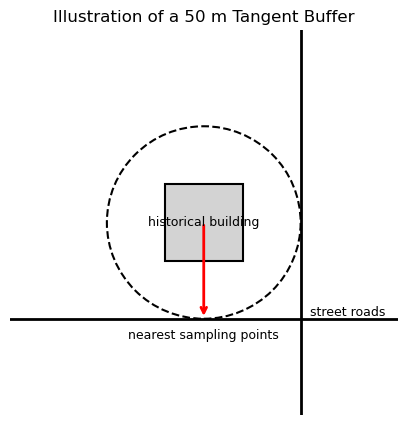

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 创建画布
fig, ax = plt.subplots(figsize=(5,5))

# 灰色矩形表示历史建筑
building = patches.Rectangle((-0.2,-0.2), 0.4, 0.4, 
                             linewidth=1.5, edgecolor="black", facecolor="lightgrey")
ax.add_patch(building)

# 50m缓冲区（用虚线圆表示）
buffer_circle = patches.Circle((0,0), radius=0.5, 
                               linewidth=1.5, edgecolor="black", facecolor="none", linestyle="--")
ax.add_patch(buffer_circle)

# 道路（黑色线）
ax.plot([-1,1],[ -0.5,-0.5], color="black", linewidth=2)
ax.plot([0.5,0.5],[-1,1], color="black", linewidth=2)

# 红色箭头 (从建筑中心到底部采样点)
ax.annotate("",
            xy=(0,-0.5), xycoords='data',
            xytext=(0,0), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="red", lw=2))

# 文字标注
ax.text(0,0,"historical building", ha="center", va="center", fontsize=9, color="black")
ax.text(0,-0.55,"nearest sampling points", ha="center", va="top", fontsize=9)
ax.text(0.55,-0.5,"street roads", ha="left", va="bottom", fontsize=9)

# 坐标范围 & 去掉坐标轴
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.axis("off")

plt.title("Illustration of a 50 m Tangent Buffer", fontsize=12)
plt.show()


In [3]:
# -*- coding: utf-8 -*-
# Generate histogram figures for: Anjuke prices, Shanghai population stats, and POI counts
# Requires: pandas, matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- File paths ----------
data_dir = Path("/Users/sillyfish/Desktop/dissertation/DATA")
price_fp = data_dir / "ehb_price_1km.csv"
pop_fp   = data_dir / "ehb_with_town_pop.csv"
poi_fp   = data_dir / "ehb_poi_1km_counts.csv"

out_dir = data_dir   # 保存到 data 文件夹
out_dir.mkdir(parents=True, exist_ok=True)

# ---------- 1) Housing Prices ----------
price_df = pd.read_csv(price_fp)
price = pd.to_numeric(price_df.get("mean_price_1km"), errors="coerce")
price = price[np.isfinite(price)]

plt.figure(figsize=(10,7))
plt.hist(price, bins=30, edgecolor="black")
plt.title("Distribution of EHB Housing Prices (1 km)")
plt.xlabel("Housing price (CNY per m²)")
plt.ylabel("Number of EHBs")
plt.tight_layout()
plt.savefig(out_dir / "hist_price_1km.png", dpi=300)
plt.close()

# ---------- 2) Population statistics ----------
pop_df = pd.read_csv(pop_fp)

def _num(s):
    return pd.to_numeric(pop_df.get(s), errors="coerce")

tot = _num("总人口（人）")
work = _num("15-59岁人口（人）")
elder = _num("60岁及以上人口（人）")

mask_valid = np.isfinite(tot) & (tot > 0)
tot = tot[mask_valid]
work = work[mask_valid]
elder = elder[mask_valid]

prop_work = (work / tot).clip(0, 1)
prop_elder = (elder / tot).clip(0, 1)

# Total population
plt.figure(figsize=(10,7))
plt.hist(tot, bins=30, edgecolor="black")
plt.title("Distribution of Linked Subdistrict Total Population")
plt.xlabel("Total population (persons)")
plt.ylabel("Number of EHBs")
plt.tight_layout()
plt.savefig(out_dir / "hist_population_total.png", dpi=300)
plt.close()

# Working-age share
plt.figure(figsize=(10,7))
plt.hist(prop_work, bins=30, edgecolor="black")
plt.title("Distribution of Working-age Share (15–59)")
plt.xlabel("Share of working-age population")
plt.ylabel("Number of EHBs")
plt.tight_layout()
plt.savefig(out_dir / "hist_working_age_share.png", dpi=300)
plt.close()

# Elderly share
plt.figure(figsize=(10,7))
plt.hist(prop_elder, bins=30, edgecolor="black")
plt.title("Distribution of Elderly Share (60+)")
plt.xlabel("Share of elderly population")
plt.ylabel("Number of EHBs")
plt.tight_layout()
plt.savefig(out_dir / "hist_elderly_share.png", dpi=300)
plt.close()

# ---------- 3) POI counts ----------
poi_df = pd.read_csv(poi_fp)
poi_total = pd.to_numeric(poi_df.get("poi_total_1km"), errors="coerce")
poi_total = poi_total[np.isfinite(poi_total)]

plt.figure(figsize=(10,7))
plt.hist(poi_total, bins=30, edgecolor="black")
plt.title("Distribution of EHB POI Counts (1 km)")
plt.xlabel("POI total within 1 km")
plt.ylabel("Number of EHBs")
plt.tight_layout()
plt.savefig(out_dir / "hist_poi_total_1km.png", dpi=300)
plt.close()

print("All histograms saved to:", out_dir.resolve())


All histograms saved to: /Users/sillyfish/Desktop/dissertation/DATA
